In [1]:
!pip install \
    surprise==0.1 \
    numpy==1.20.0 \
    scikit-learn==0.24

     |████████████████████████████████| 7.2 MB 11.1 MB/s 
  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Using cached scikit-surprise-1.1.1.tar.gz (11.8 MB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-macosx_10_15_x86_64.whl size=780844 sha256=671b812cce243acafd90f7c98c4b3f7340b19e88261a2299cb25cb7e2582f643
  Stored in directory: /Users/vldpro/Library/Caches/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
You should consider upgrading via the '/Users/vldpro/Workspace/university/recsys/.venv/bin/python -m pip install --upgrade pip' command.


### Helper functions, constants and imports
---



In [1]:
%matplotlib inlinexcode-select --install


UsageError: unrecognized arguments: --install


In [2]:
import random
import functools

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise
from sklearn.model_selection import KFold
from surprise import Dataset, Reader, SVD, accuracy, KNNBasic
from surprise.model_selection import cross_validate, train_test_split

In [141]:

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

A seed for reproducibility

In [ ]:
SEED = 814526

Notebook parameters

In [ ]:
N_ITEMS = 500
N_USERS = 2000

### Generate user and item datasets

---



A function for generating a datset with `n_rows` entries and `n_feat` features, each with value from 0 to 100

In [ ]:
def generate_random_df(*, n_rows, n_feat=4):
  np.random.seed(SEED)
  array = np.random.randint(0, 100, size=(n_rows, n_feat))
  df = pd.DataFrame(array, columns=[f"attr_{i}" for i in range(n_feat)])
  return df

In [ ]:
items_df = generate_random_df(n_rows=500)
users_df = generate_random_df(n_rows=2000)

Next, we need to make a rating matrix from the generated dataframes in order to feed it to recommendation models from `surprise` library. This function takes 2 dataframes, applies some vectorized function on them and round the value to the range [0, 5]. The default function is `cosine_similarity`

In [ ]:
def generate_rating_matrix(*, user_df, item_df, rating_scale=5, rating_function=pairwise.cosine_similarity):
  sim_matrix = rating_function(user_df, item_df)
  rating_matrix = (sim_matrix * 5).round()
  return rating_matrix

In [ ]:
rating_matrix = generate_rating_matrix(user_df=users_df, item_df=items_df)
rating_matrix

array([[5., 4., 4., ..., 4., 5., 3.],
       [4., 5., 4., ..., 5., 4., 3.],
       [4., 4., 5., ..., 4., 4., 5.],
       ...,
       [2., 4., 4., ..., 4., 4., 3.],
       [4., 5., 5., ..., 5., 5., 4.],
       [4., 4., 5., ..., 4., 5., 4.]])

Now we transform the matrix to the long table format - where each row contains the tuple `(user_id, item_id, rating)`.

In [94]:
def rating_matrix_to_long_table(rating_matrix):
  df = pd.DataFrame(rating_matrix)
  df["user_id"] = df.index
  return df.melt(id_vars=["user_id"], var_name="item_id", value_name="rating")


Thus we have `N_USERS x N_ITEMS` table with generated rating.

In [ ]:
full_rating_df = rating_matrix_to_long_table(rating_matrix)
full_rating_df

,user_id,item_id,rating
0,0,0,5.0
1,1,0,4.0
2,2,0,4.0
3,3,0,3.0
4,4,0,5.0
...,...,...,...
999995,1995,499,4.0
999996,1996,499,3.0
999997,1997,499,3.0
999998,1998,499,4.0


### Make dataset with custom distribution of ratings

---

A random sample with 5% of available data

In [ ]:
np.random.seed(SEED)
rating_sample_df = full_rating_df.sample(50000)
_rating_dist_df = rating_sample_df.groupby("item_id").count()

In [ ]:
_rating_dist_df

,user_id,rating
item_id,,
0,103,103
1,112,112
2,96,96
3,104,104
4,101,101
...,...,...
495,101,101
496,107,107
497,95,95


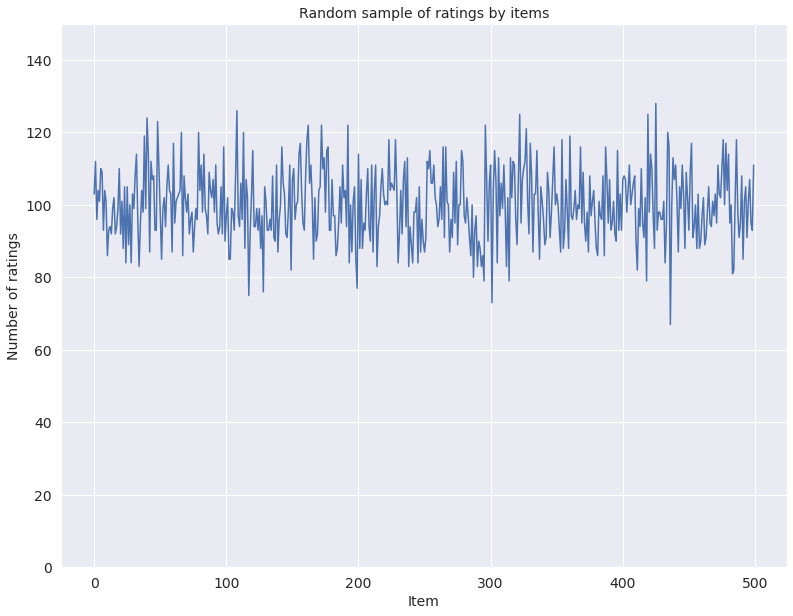

In [ ]:
_, ax = plt.subplots()
ax.set_title("Random sample of ratings by items")
ax.set_xlabel("Item")
ax.set_ylabel("Number of ratings")
ax.set_ylim(bottom=0, top=150)
sns.lineplot(data=_rating_dist_df, x=np.arange(0, len(_rating_dist_df)), ax=ax, y="rating")

Now we want to generate a sample with exponential distribution of rating. This function takes the dataframe and scale parameter of exp distribution and generates the sample.

In [ ]:
def get_exponential_sample_from_ratings_df(*, ratings_df, exp_scale):
  np.random.seed(SEED)
  exp_sample = pd.DataFrame(columns=ratings_df.columns)
  n_items = ratings_df["item_id"].nunique()
  for i in range(n_items):
    n_ratings = np.random.exponential(scale=exp_scale)
    sample = ratings_df[ratings_df["item_id"] == i].sample(int(n_ratings))
    exp_sample = pd.concat([exp_sample, sample], ignore_index=True)
  return exp_sample

In [ ]:
def _get_exp_distribution_df():
  exp_rating_df = get_exponential_sample_from_ratings_df(ratings_df=full_rating_df, exp_scale=100)
  return exp_rating_df.groupby("item_id").count()

_exp_rating_dist = _get_exp_distribution_df()

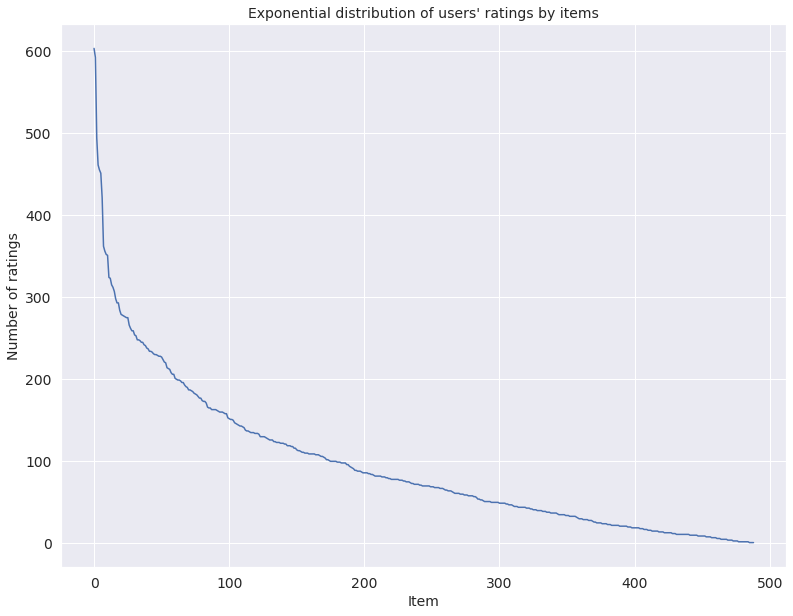

In [ ]:
_, ax = plt.subplots()
ax.set_title("Exponential distribution of users' ratings by items")
ax.set_xlabel("Item")
ax.set_ylabel("Number of ratings")
#sns.histplot(data=_exp_rating_dist, x="item_id", kde=True, ax=ax, bins=100)
_sorted_ratings = _exp_rating_dist.sort_values(by=["rating"], ascending=False)
sns.lineplot(data=_sorted_ratings, x=np.arange(0, len(_sorted_ratings)), ax=ax, y="rating")

In [ ]:
def samples(*, rating_df, n_samples):
  df_size = len(rating_df)
  for i in range(1, n_samples + 1):
    yield rating_df.sample(int(df_size / n_samples * i))

## Experiments

### Experiment: Noisy rating function (Work-In-Progress)

---



In [ ]:
def svd_train(df, cv=5):
  dataset = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  algo = SVD()
  return cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=cv, verbose=True)
  

In [ ]:
def knn_train(df, cv=5):
  dataset = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  algo = KNNBasic()
  return cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

A custom response function which generates responses based on similarity between `user_vec` and `item_vec` (can be vectors of vectors) and noise parameter `t` in range [0, 1]. The function is analytically defined as:

$f(U, I, t) = t \cdot sim(U, I) + (1 - t) \cdot r$

Where `r` is random component in range [-1, 1]

In [ ]:
def noisy_similarity_rating(user_vec, item_vec, t = 1):
  r = 2 * random.random() - 1
  return t * pairwise.cosine_similarity(user_vec, item_vec) + (1 - t) * r

We define a function for generation user responses with some noise which as defined by `t` parameter in `rating_function`. We generate 20 samples variying `t` parameter from 1 to 0  with step 0.05.

In [ ]:
def generate_noisy_samples(rating_function):
  rating_matrices = [
    generate_rating_matrix(
        user_df=users_df,
        item_df=items_df,
        rating_function=functools.partial(rating_function, t=t)
    ) for t in np.arange(1, 0, -0.05)
  ]

  rating_dfs = [
    rating_matrix_to_long_table(m) for m in rating_matrices
  ]

  samples = [
    df.sample(150_000) for df in rating_dfs
  ]
  return samples

In [ ]:
def train_model(train_fn, df_list):
  results = [train_fn(df) for df in df_list]
  return results

Next we train the **SVD** model on the generated samples.

**TODO**:
- Explore the similarity between samples

In [ ]:
np.random.seed(SEED)
random.seed(SEED)

_svd_results = train_model(
    svd_train,
    generate_noisy_samples(rating_function=noisy_similarity_rating)
)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4415  0.4346  0.4250  0.4286  0.4353  0.4330  0.0057  
MAE (testset)     0.3590  0.3535  0.3469  0.3490  0.3552  0.3527  0.0043  
Fit time          7.45    7.50    7.51    7.50    7.56    7.50    0.04    
Test time         0.25    0.23    0.23    0.44    0.24    0.28    0.08    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4588  0.4594  0.4489  0.4646  0.4561  0.4576  0.0051  
MAE (testset)     0.3602  0.3608  0.3529  0.3641  0.3581  0.3592  0.0037  
Fit time          7.44    7.52    7.54    7.52    7.55    7.51    0.04    
Test time         0.45    0.22    0.22    0.43    0.23    0.31    0.11    
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset

### Experiment: relation between MAE/RMSE and sample size

---

We define 2 helper function, the first will train the model on multiple samples with size variying from 10 to 100 % of initial sample size.

In [ ]:
def evaluate_the_model_on_multiple_samples(train_fn, df, n_samples):
  results = []
  for rating_sample in samples(rating_df=df, n_samples=n_samples):
    result = train_fn(rating_sample, cv=2)
    results.append(result)
  return results

The second one extracts **MAE** and **RMSE** from evaluation results and make a DataFrame for easier vizualization.

In [ ]:
def evaluate_on_multiple_samples(df, train_fn, n_samples):
  results = evaluate_the_model_on_multiple_samples(train_fn, df, n_samples)

  df_dict = {
      "MAE": [],
      "RMSE": [],
      "Test time": [],
      "Fit time": []
  }

  for res in results:
    df_dict["MAE"].append(np.mean(res["test_mae"]))
    df_dict["RMSE"].append(np.mean(res["test_rmse"]))
    df_dict["Fit time"].append(np.mean(res["fit_time"]))
    df_dict["Test time"].append(np.mean(res["test_time"]))

  df_dict["Sample size"] = np.arange(10, 101, 10)
  return pd.DataFrame(df_dict)

Next we evaluate **SVD** and **KNN** algorithms

In [ ]:
np.random.seed(SEED)
_svd_results = evaluate_on_multiple_samples(full_rating_df, svd_train, n_samples=10)
_svd_results

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7168  0.7174  0.7171  0.0003  
MAE (testset)     0.5663  0.5693  0.5678  0.0015  
Fit time          3.19    3.24    3.21    0.02    
Test time         0.70    0.42    0.56    0.14    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5271  0.5328  0.5299  0.0028  
MAE (testset)     0.4217  0.4264  0.4240  0.0023  
Fit time          6.52    6.51    6.51    0.00    
Test time         1.11    0.96    1.04    0.07    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3485  0.3471  0.3478  0.0007  
MAE (testset)     0.2928  0.2915  0.2921  0.0006  
Fit time          9.85    9.94    9.89    0.04    
Test time         1.56    1.71    1.64    0.08    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

,MAE,RMSE,Test time,Fit time,Sample size
0,0.567779,0.717096,0.559165,3.210653,10
1,0.424030,0.529910,1.035854,6.512970,20
2,0.292135,0.347813,1.636439,9.894275,30
3,0.270949,0.317120,2.060898,13.236589,40
4,0.265679,0.309189,2.820393,16.805928,50
5,0.262739,0.305318,3.442992,20.090049,60
6,0.261188,0.303073,4.026603,23.542403,70
7,0.259886,0.301406,4.722342,26.957048,80
8,0.258443,0.299829,5.295197,30.677535,90
9,0.257632,0.298747,6.022761,33.958388,100


In [ ]:
_knn_results = evaluate_on_multiple_samples(full_rating_df, knn_train, n_samples=10)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7074  0.7111  0.7092  0.0019  
MAE (testset)     0.5551  0.5600  0.5575  0.0025  
Fit time          0.44    0.44    0.44    0.00    
Test time         9.62    9.79    9.70    0.08    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5669  0.5632  0.5651  0.0018  
MAE (testset)     0.4447  0.4404  0.4426  0.0022  
Fit time          1.36    1.31    1.34    0.02    
Test time         30.87   30.53   30.70   0.17    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computi

Further, we reformat the results obtained in order to create a single dataset with all the results.



In [ ]:
def _reformat_data(results):
  rmse_df = results.drop(columns=["MAE"])
  mae_df = results.drop(columns=["RMSE"])
  rmse_df = rmse_df.rename(columns={"RMSE": "Error"})
  mae_df = mae_df.rename(columns={"MAE": "Error"})
  rmse_df["Kind"] = "RMSE"
  mae_df["Kind"] = "MAE"
  return pd.concat([mae_df, rmse_df])

In [ ]:
_knn_reformated_results = _reformat_data(_knn_results)

_knn_reformated_results["Algo"] = "KNN"
_reformated["Algo"] = "SVD"
_knn_svd_results = pd.concat([_knn_reformated_results, _reformated])

In [ ]:
_knn_svd_results

In [ ]:
_svd_reformated = _reformat_data(_results)

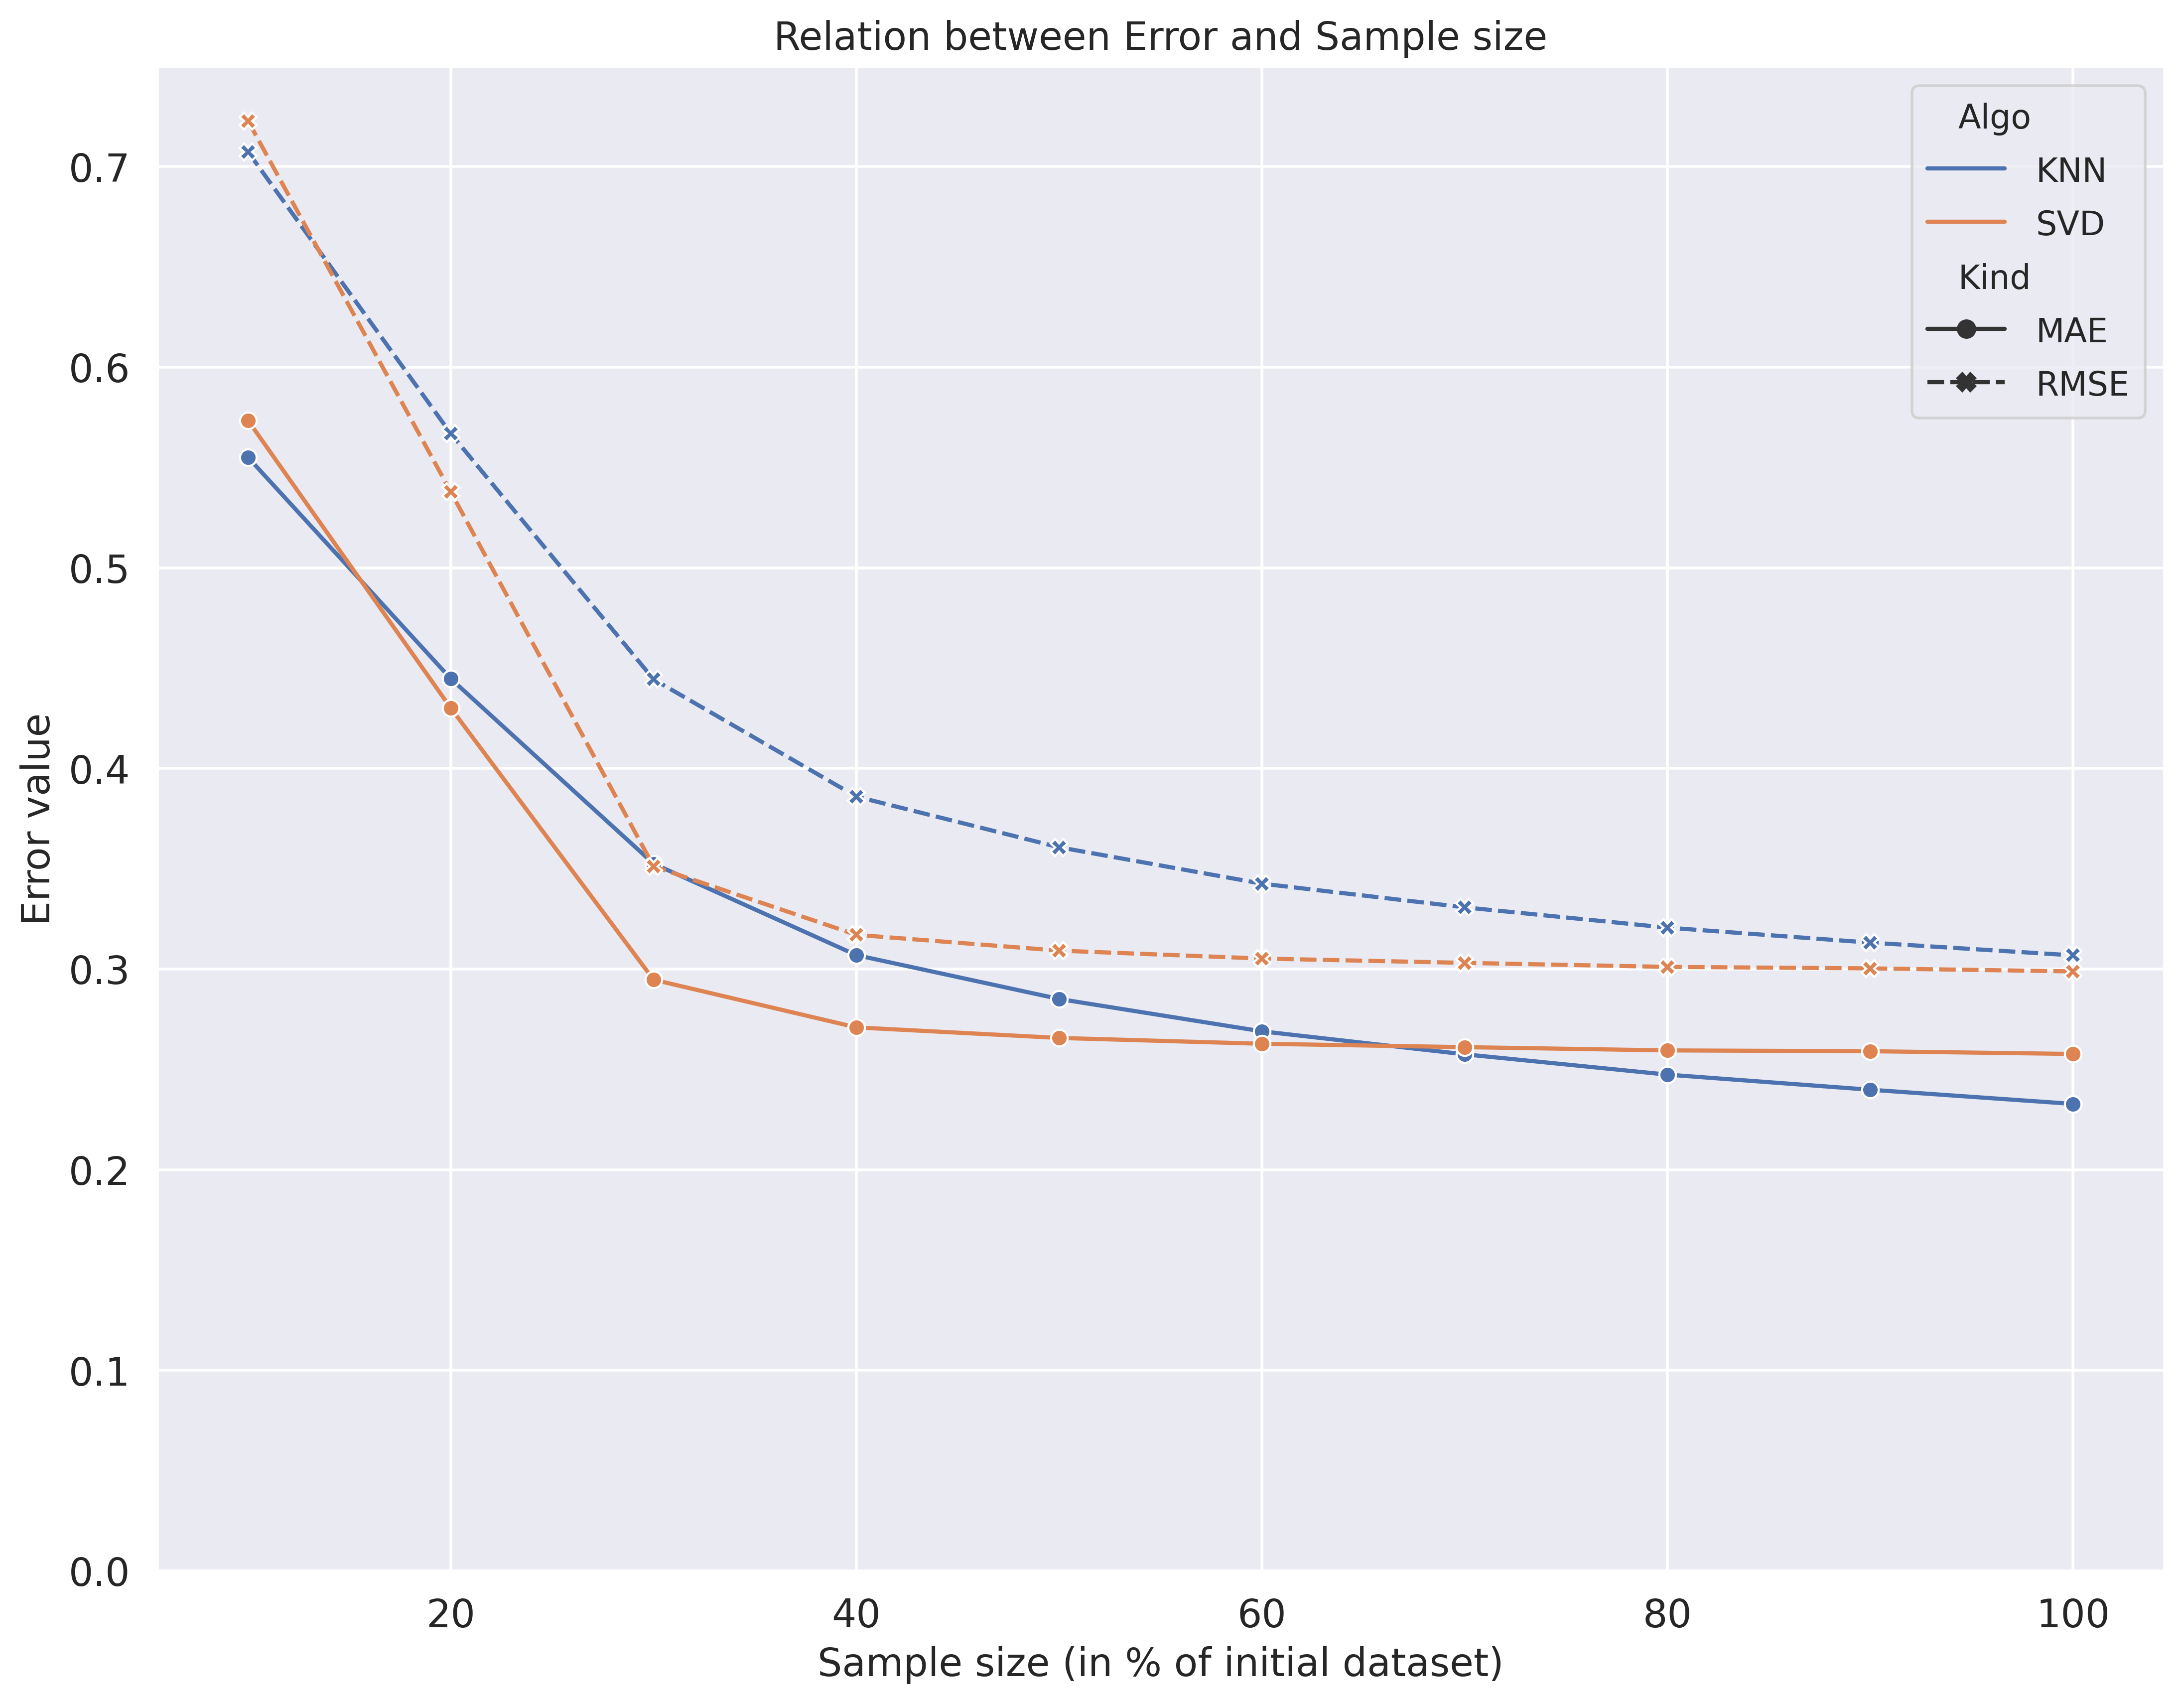

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between Error and Sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Error value")
ax.set_ylim(bottom=0, top=0.75)
sns.lineplot(
    x=_knn_svd_results["Sample size"],
    y=_knn_svd_results["Error"],
    style=_knn_svd_results["Kind"],
    hue=_knn_svd_results["Algo"],
    markers=True
)

Next we make a visualization for training time - sample size relation

In [ ]:
_knn_train_time = [
  9.62,
  30.87,
  61.07,
  107.22,
  161.60,
  228.33,
  306.47,
  392.65,
  502.85,
  611.64,
]

_knn_fit_time = [
  0.44,
  1.26,
  2.40,
  4.27,
  6.04,
  8.14,
  12.0,
  15.15,
  21.31,
  28.52,
]

In [ ]:
_svd_results

,MAE,RMSE,Test time,Fit time,Sample size
0,0.567779,0.717096,0.559165,3.210653,10
1,0.424030,0.529910,1.035854,6.512970,20
2,0.292135,0.347813,1.636439,9.894275,30
3,0.270949,0.317120,2.060898,13.236589,40
4,0.265679,0.309189,2.820393,16.805928,50
5,0.262739,0.305318,3.442992,20.090049,60
6,0.261188,0.303073,4.026603,23.542403,70
7,0.259886,0.301406,4.722342,26.957048,80
8,0.258443,0.299829,5.295197,30.677535,90
9,0.257632,0.298747,6.022761,33.958388,100


In [ ]:
_knn_tmp = _knn_results.copy()

In [ ]:
_knn_tmp["Test time"] = _knn_train_time
_knn_tmp["Fit time"] = _knn_fit_time

In [ ]:
_knn_time = _knn_tmp[["Test time", "Fit time", "Sample size"]].copy()
_knn_time["Algo"] = "KNN"
_svd_time = _svd_results[["Test time", "Fit time", "Sample size"]].copy()
_svd_time["Algo"] = "SVD"
_svd_knn_time = pd.concat([_svd_time, _knn_time])
_svd_knn_time

,Test time,Fit time,Sample size,Algo
0,0.559165,3.210653,10,SVD
1,1.035854,6.512970,20,SVD
2,1.636439,9.894275,30,SVD
3,2.060898,13.236589,40,SVD
4,2.820393,16.805928,50,SVD
5,3.442992,20.090049,60,SVD
6,4.026603,23.542403,70,SVD
7,4.722342,26.957048,80,SVD
8,5.295197,30.677535,90,SVD
9,6.022761,33.958388,100,SVD


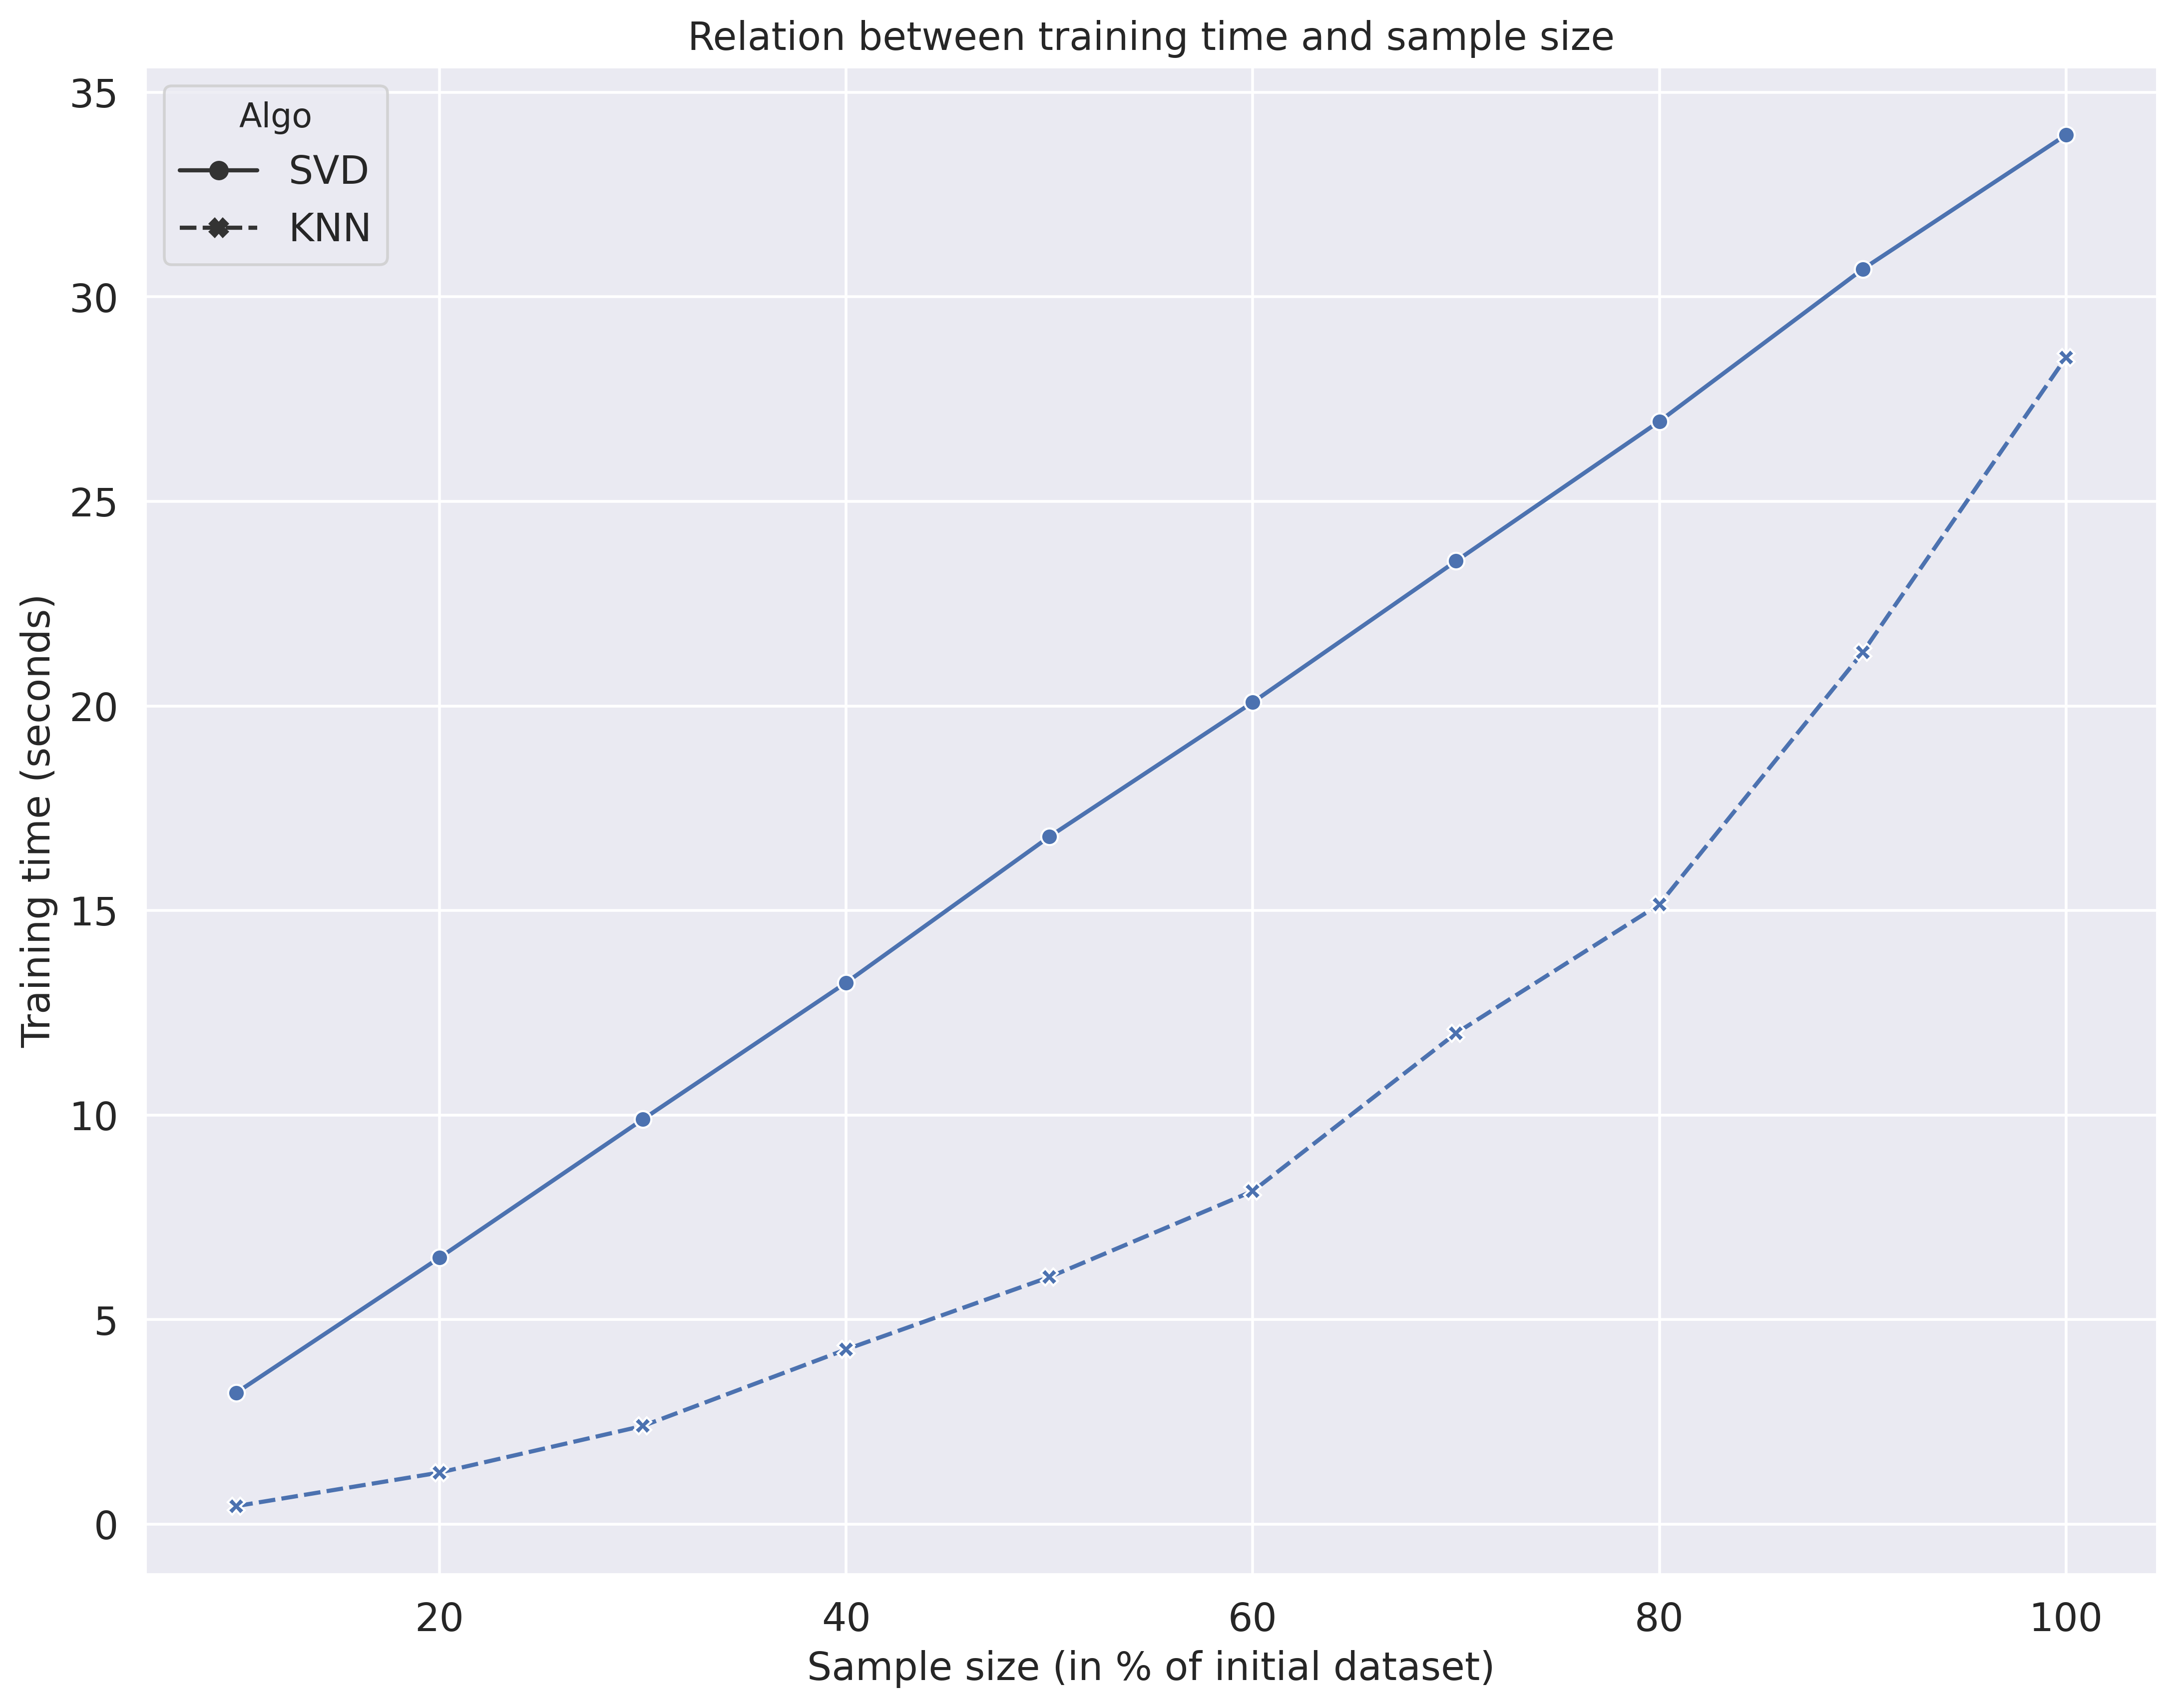

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between training time and sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Training time (seconds)")
sns.lineplot(
    x=_svd_knn_time["Sample size"],
    y=_svd_knn_time["Fit time"],
    style=_svd_knn_time["Algo"],
    markers=True,
    ax=ax
)

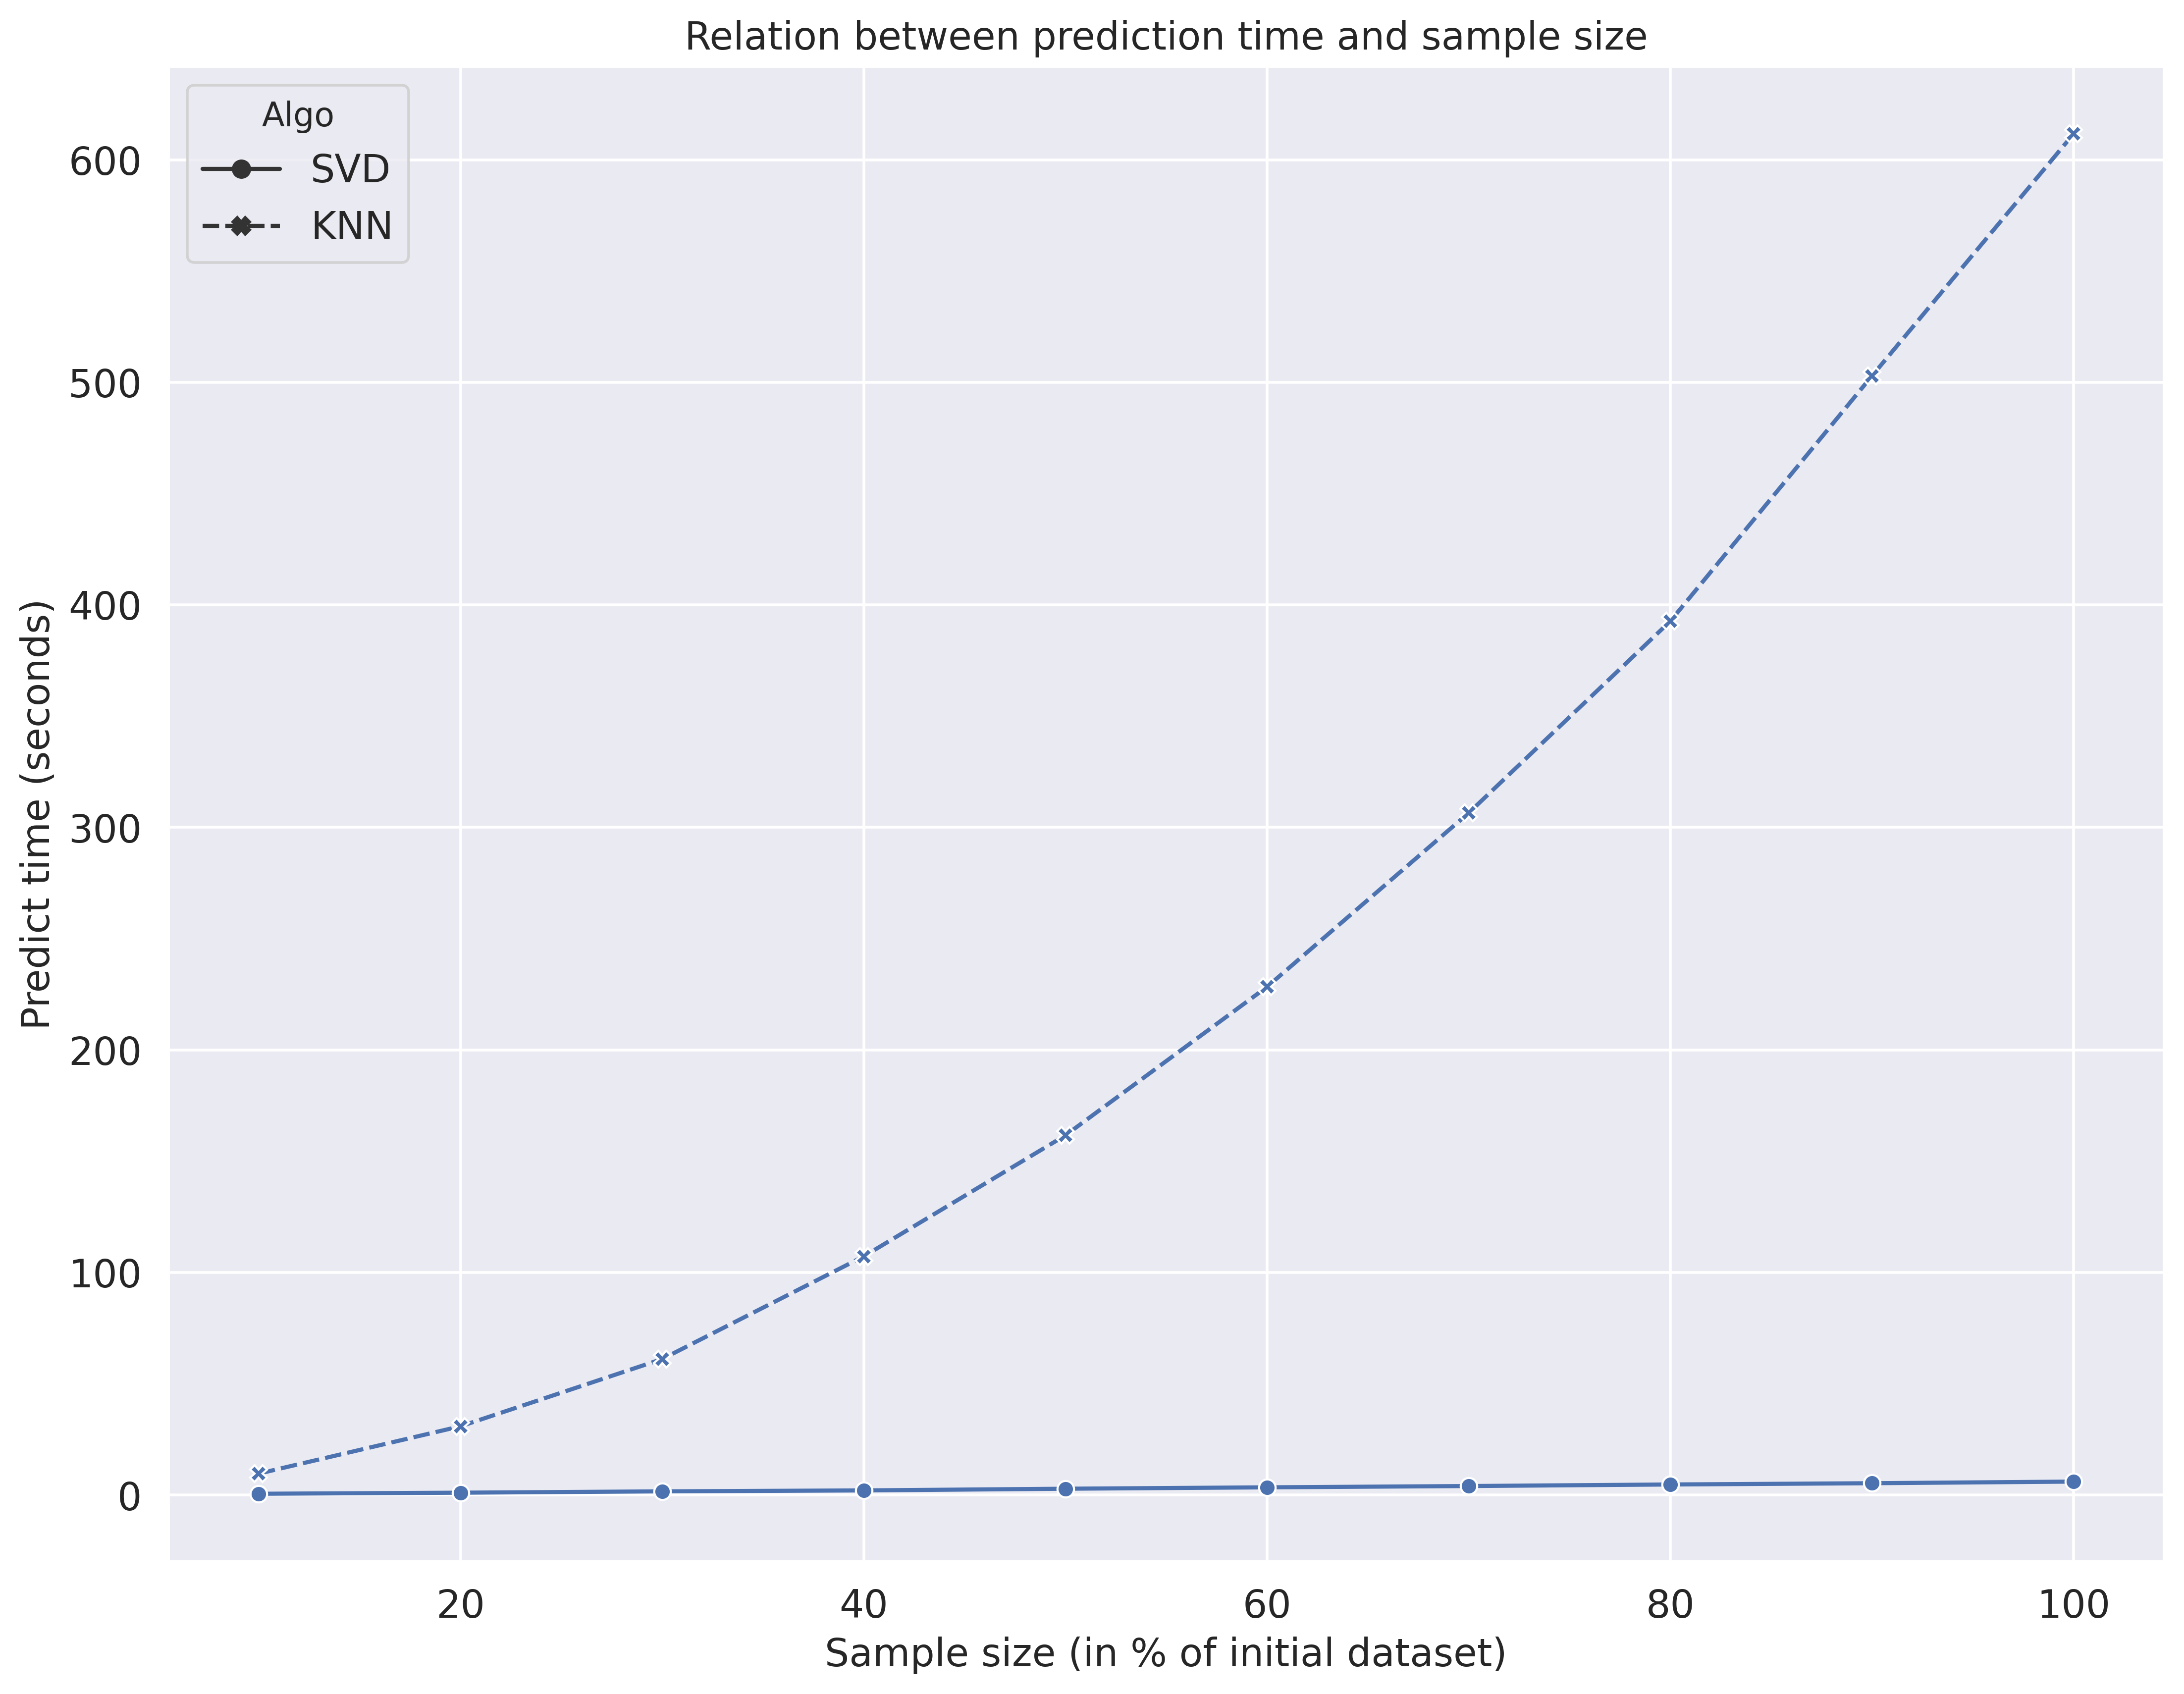

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Relation between prediction time and sample size")
ax.set_xlabel("Sample size (in % of initial dataset)")
ax.set_ylabel("Predict time (seconds)")
sns.lineplot(
    x=_svd_knn_time["Sample size"],
    y=_svd_knn_time["Test time"],
    style=_svd_knn_time["Algo"],
    markers=True,
    ax=ax
)

### Experiment: relation between sample size and training time

---



### SVD

With normally distributed ratings

In [ ]:
algo = SVD()
cross_validate(algo, surp_normal_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7399  0.7494  0.7544  0.7453  0.7479  0.7474  0.0048  
MAE (testset)     0.5846  0.5948  0.5939  0.5867  0.5917  0.5903  0.0040  
Fit time          2.42    2.42    2.40    2.40    2.40    2.41    0.01    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.00    


{'fit_time': (2.416093587875366,
  2.424466371536255,
  2.401695728302002,
  2.3973748683929443,
  2.401312828063965),
 'test_mae': array([0.58455916, 0.59481744, 0.59386181, 0.58673389, 0.59174331]),
 'test_rmse': array([0.73993019, 0.74940511, 0.75444941, 0.74533638, 0.74793703]),
 'test_time': (0.06775951385498047,
  0.06836676597595215,
  0.06949877738952637,
  0.06873345375061035,
  0.06981205940246582)}

With exponentially distributed ratings

In [ ]:
algo = SVD()
cross_validate(algo, surp_exp_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7223  0.7238  0.7209  0.7291  0.7217  0.7236  0.0029  
MAE (testset)     0.5711  0.5712  0.5678  0.5761  0.5700  0.5713  0.0027  
Fit time          2.38    2.40    2.41    2.40    2.38    2.39    0.01    
Test time         0.07    0.07    0.07    0.07    0.07    0.07    0.00    


{'fit_time': (2.3841793537139893,
  2.395214080810547,
  2.4132630825042725,
  2.396310806274414,
  2.383516550064087),
 'test_mae': array([0.57111431, 0.57118143, 0.56782242, 0.576148  , 0.5700241 ]),
 'test_rmse': array([0.72228488, 0.72377554, 0.72094066, 0.72908143, 0.72171471]),
 'test_time': (0.06815695762634277,
  0.06974506378173828,
  0.06769633293151855,
  0.06939101219177246,
  0.06750798225402832)}

#### MAE depending on dataset coverage

In [ ]:
cv_results = []

for rating_sample in samples(rating_df=full_rating_df, n_samples=10):
  algo = SVD()
  _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=2, verbose=True)
  cv_results.append(result)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.7331  0.7297  0.7314  0.0017  
MAE (testset)     0.5785  0.5749  0.5767  0.0018  
Fit time          3.02    3.03    3.03    0.01    
Test time         0.36    0.35    0.35    0.00    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.5182  0.5483  0.5333  0.0150  
MAE (testset)     0.4148  0.4374  0.4261  0.0113  
Fit time          6.14    6.17    6.16    0.01    
Test time         0.74    0.72    0.73    0.01    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3470  0.3451  0.3460  0.0010  
MAE (testset)     0.2917  0.2904  0.2910  0.0007  
Fit time          9.38    9.45    9.42    0.04    
Test time         1.09    1.10    1.10    0.01    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

In [ ]:
_results = [res["test_mae"][0] for res in cv_results]
_results

[0.5784907726502801,
 0.41478014113642936,
 0.2916966021047805,
 0.27141063046797187,
 0.2661304678380038,
 0.26357424051670864,
 0.2616142222816303,
 0.26052345029827867,
 0.2593369681530534,
 0.258092427671419]

In [ ]:
_data = pd.DataFrame()
_data["MAE"] = _results
_data["Sample_Size"] = np.arange(10, 101, 10)

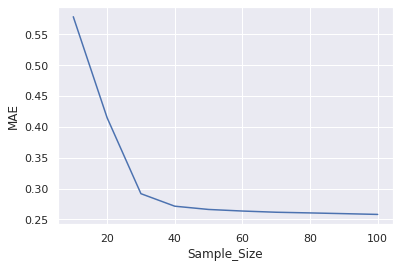

In [ ]:
sns.lineplot(data=_data, x="Sample_Size", y="MAE")

### KNN

In [ ]:
from surprise import KNNBasic


In [ ]:
knn_algo = KNNBasic(sim_options={"name": "cosine"})
cross_validate(knn_algo, surp_normal_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Computing the cosine similarity matrix...


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7957  0.7952  0.7996  0.8073  0.8015  0.7999  0.0044  
MAE (testset)     0.6292  0.6318  0.6314  0.6403  0.6329  0.6331  0.0038  
Fit time          2.03    1.61    1.64    1.59    1.63    1.70    0.17    
Test time         1.34    1.34    1.36    1.35    1.38    1.35    0.02    


{'fit_time': (2.033316135406494,
  1.6128532886505127,
  1.6398506164550781,
  1.5922119617462158,
  1.626539707183838),
 'test_mae': array([0.62917638, 0.6317954 , 0.63137438, 0.64026126, 0.63288927]),
 'test_rmse': array([0.79565065, 0.79520979, 0.79964635, 0.80730033, 0.8015056 ]),
 'test_time': (1.3403890132904053,
  1.336042881011963,
  1.3635547161102295,
  1.3521411418914795,
  1.3792345523834229)}

In [ ]:
knn_algo = KNNBasic(sim_options={"name": "cosine"})
cross_validate(knn_algo, surp_exp_rating_df, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Computing the cosine similarity matrix...


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7798  0.7823  0.7858  0.7869  0.7789  0.7827  0.0032  
MAE (testset)     0.6177  0.6183  0.6202  0.6221  0.6137  0.6184  0.0028  
Fit time          2.22    2.26    2.20    2.25    2.18    2.22    0.03    
Test time         1.83    1.78    1.83    1.83    1.89    1.83    0.03    


{'fit_time': (2.2221519947052,
  2.2577805519104004,
  2.2044942378997803,
  2.2452409267425537,
  2.181037664413452),
 'test_mae': array([0.61769565, 0.61829295, 0.62022908, 0.62205028, 0.61367367]),
 'test_rmse': array([0.77984699, 0.78234265, 0.78575353, 0.78691772, 0.77887771]),
 'test_time': (1.8283109664916992,
  1.784238576889038,
  1.827542781829834,
  1.828648567199707,
  1.8873496055603027)}

#### MAE depending on dataset **coverage**

In [ ]:
cv_results = []

for rating_sample in samples(rating_df=full_rating_df, n_samples=10):
  algo = KNNBasic(sim_options={"name": "cosine"})
  _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
  result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=2, verbose=True)
  cv_results.append(result)

  

NameError: ignored

In [ ]:
cv_results

[{'fit_time': (2.269840955734253, 2.159127950668335),
  'test_mae': array([0.62179305, 0.62561192]),
  'test_rmse': array([0.78847913, 0.79356783]),
  'test_time': (7.762932777404785, 7.735900163650513)},
 {'fit_time': (3.6298372745513916, 3.904237747192383),
  'test_mae': array([0.52065037, 0.52209213]),
  'test_rmse': array([0.65940977, 0.66409166]),
  'test_time': (25.066633939743042, 25.276814460754395)},
 {'fit_time': (5.012295722961426, 5.168306827545166),
  'test_mae': array([0.40665386, 0.40235206]),
  'test_rmse': array([0.5171993 , 0.51017608]),
  'test_time': (51.20661997795105, 52.05418610572815)},
 {'fit_time': (6.94805121421814, 6.942681074142456),
  'test_mae': array([0.35345885, 0.35491719]),
  'test_rmse': array([0.45149127, 0.45385662]),
  'test_time': (90.68943810462952, 92.98332166671753)},
 {'fit_time': (8.91606068611145, 9.074350833892822),
  'test_mae': array([0.32672662, 0.3240964 ]),
  'test_rmse': array([0.42050452, 0.4164018 ]),
  'test_time': (129.5507130622

In [ ]:
_results = [res["test_mae"][0] for res in cv_results]
_results

_data = pd.DataFrame()
_data["MAE"] = _results
_data["Sample_Size"] = np.arange(10, 101, 10)

sns.lineplot(data=_data, x="Sample_Size", y="MAE")

NameError: ignored

## Calculations with noisy data (Draft)

In [ ]:
items_df = generate_random_df(n_rows=500)
users_df = generate_random_df(n_rows=2000)

rating_matrix = generate_rating_matrix(user_df=users_df, item_df=items_df, rating_function=rating_function)

In [ ]:
rating_matrices = [
  generate_rating_matrix(
      user_df=users_df,
      item_df=items_df,
      rating_function=functools.partial(rating_function, t=t)
  ) for t in np.arange(1, 0, -0.05)
]

In [ ]:
rating_dfs = [
    rating_matrix_to_long_table(m) for m in rating_matrices
]

In [ ]:
rating_samples_dfs = [
    df.sample(150_000) for df in rating_dfs
]

In [ ]:
def calculate_svd_results(samples):
  svd_results = []
  for rating_sample in samples:
    algo = SVD()
    _dataset = Dataset.load_from_df(rating_sample[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 5)))
    result = cross_validate(algo, _dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    svd_results.append(result)

In [ ]:
svd_results = calculate_svd_results(rating_samples_dfs)

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6605  0.6581  0.6593  0.0012  
MAE (testset)     0.5235  0.5225  0.5230  0.0005  
Fit time          4.40    4.42    4.41    0.01    
Test time         0.62    0.72    0.67    0.05    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6150  0.6164  0.6157  0.0007  
MAE (testset)     0.4792  0.4800  0.4796  0.0004  
Fit time          4.44    4.44    4.44    0.00    
Test time         0.63    0.62    0.63    0.00    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6357  0.6310  0.6334  0.0023  
MAE (testset)     0.5057  0.5026  0.5042  0.0016  
Fit time          4.43    4.44    4.43    0.00    
Test time         0.72    0.62    0.67    0.05    
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  F

KeyboardInterrupt: ignored

In [ ]:
np.arange(1, 0, -0.05)

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05])

In [ ]:
def calculate_sim_results(samples):
  results = []
  for sample in samples:
    kf = KFold(n_splits=5)
    rmse_list = []
    train_sample = sample.sample(20_000)

    _users = users_df.loc[train_sample["user_id"]]
    _items = items_df.loc[train_sample["item_id"]]

    _est_rating = np.around(pairwise.cosine_similarity(_users, _items) * 5)
    print(_est_rating)
    rmse = (_est_rating - train_sample["rating"]) ** 2
    rmse = np.sqrt(np.sum(rmse))
    rmse_list.append(rmse)
    print(rmse_list)
    result.append(rmse_list)
  return results


In [ ]:
calculate_sim_results(rating_samples_dfs)

## DeepFM (Continue)



In [105]:
!pip install progressbar2

In [106]:
import progressbar

In [5]:
_nn_matrix = pd.read_csv("../data/restaurant_data_reformatted/nn_matrix_out.csv")
_heu_matrix = pd.read_csv("../data/restaurant_data_reformatted/heu_matrix_out.csv")

In [12]:
_nn_matrix = _nn_matrix.drop("user_id", axis=1)

In [13]:
_heu_matrix = _heu_matrix.drop("Unnamed: 0", axis=1)

In [121]:
resp_fn = ResponseFunction(_heu_matrix, _nn_matrix)

In [122]:
def _train_svd(data):
    dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], Reader(rating_scale=(0, 2)))
    algo = SVD()
    result = cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=2, verbose=True)
    return result
  

In [123]:
def _experiment(resp_fn):
    alphas = itertools.product(np.arange(0.0, 1.0, step=0.05), np.arange(0.0, 1.0, step=0.05))
    results = []
    with progressbar.ProgressBar(max_value=20 * 20) as bar:
        for a1 in np.arange(0.0, 1.05, step=0.05):
            for a2 in np.arange(0.0, 1.05 - a1, step=0.05):
                gt_matrix = resp_fn(a1, a2)
                ltable = rating_matrix_to_long_table(gt_matrix)
                result = _train_svd(ltable)
                results.append((a1, a2, result))
                bar += 1
                print(f"--Experiment: ({a1}, {a2}, {1 - a1 - a2})")
    return results
            

In [124]:
_experiment(resp_fn)

N/A% (0 of 400) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0301  0.0303  0.0302  0.0001  
MAE (testset)     0.0239  0.0240  0.0239  0.0000  
Fit time          4.69    4.29    4.49    0.20    
Test time         0.69    0.52    0.60    0.08    
--Experiment: (0.0, 0.0, 1.0)


  0% (2 of 400) |                        | Elapsed Time: 0:00:10 ETA:   0:35:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0624  0.0623  0.0624  0.0000  
MAE (testset)     0.0606  0.0606  0.0606  0.0000  
Fit time          4.38    4.37    4.37    0.01    
Test time         0.69    0.52    0.61    0.09    
--Experiment: (0.0, 0.05, 0.95)


  0% (3 of 400) |                        | Elapsed Time: 0:00:21 ETA:   1:14:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0726  0.0723  0.0725  0.0001  
MAE (testset)     0.0669  0.0667  0.0668  0.0001  
Fit time          4.53    4.52    4.52    0.01    
Test time         0.78    0.68    0.73    0.05    
--Experiment: (0.0, 0.1, 0.9)


  1% (4 of 400) |                        | Elapsed Time: 0:00:33 ETA:   1:14:23

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0306  0.0306  0.0306  0.0000  
MAE (testset)     0.0243  0.0243  0.0243  0.0000  
Fit time          4.63    4.63    4.63    0.00    
Test time         0.52    0.71    0.61    0.09    
--Experiment: (0.0, 0.15000000000000002, 0.85)


  1% (5 of 400) |                        | Elapsed Time: 0:00:45 ETA:   1:19:02

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1561  0.1563  0.1562  0.0001  
MAE (testset)     0.1450  0.1451  0.1450  0.0001  
Fit time          5.03    4.85    4.94    0.09    
Test time         0.62    0.77    0.69    0.07    
--Experiment: (0.0, 0.2, 0.8)


  1% (6 of 400) |                        | Elapsed Time: 0:00:56 ETA:   1:17:07

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1031  0.1026  0.1029  0.0002  
MAE (testset)     0.0824  0.0821  0.0822  0.0001  
Fit time          4.90    4.88    4.89    0.01    
Test time         0.55    0.70    0.62    0.07    
--Experiment: (0.0, 0.25, 0.75)


  1% (7 of 400) |                        | Elapsed Time: 0:01:09 ETA:   1:20:16

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0323  0.0321  0.0322  0.0001  
MAE (testset)     0.0253  0.0252  0.0252  0.0001  
Fit time          5.49    4.76    5.13    0.37    
Test time         0.57    0.69    0.63    0.06    
--Experiment: (0.0, 0.30000000000000004, 0.7)


  2% (8 of 400) |                        | Elapsed Time: 0:01:21 ETA:   1:17:59

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0328  0.0328  0.0328  0.0000  
MAE (testset)     0.0256  0.0255  0.0256  0.0000  
Fit time          4.83    4.88    4.86    0.02    
Test time         0.57    0.90    0.73    0.16    
--Experiment: (0.0, 0.35000000000000003, 0.6499999999999999)


  2% (9 of 400) |                        | Elapsed Time: 0:01:32 ETA:   1:15:14

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0335  0.0333  0.0334  0.0001  
MAE (testset)     0.0259  0.0256  0.0258  0.0001  
Fit time          4.79    4.69    4.74    0.05    
Test time         0.60    0.73    0.66    0.06    
--Experiment: (0.0, 0.4, 0.6)


  2% (10 of 400) |                       | Elapsed Time: 0:01:45 ETA:   1:20:16

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0342  0.0341  0.0341  0.0001  
MAE (testset)     0.0262  0.0260  0.0261  0.0001  
Fit time          5.30    5.05    5.18    0.13    
Test time         0.64    0.56    0.60    0.04    
--Experiment: (0.0, 0.45, 0.55)


  2% (11 of 400) |                       | Elapsed Time: 0:01:57 ETA:   1:21:34

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0352  0.0347  0.0350  0.0002  
MAE (testset)     0.0266  0.0263  0.0265  0.0001  
Fit time          5.09    5.26    5.17    0.09    
Test time         0.59    0.74    0.66    0.07    
--Experiment: (0.0, 0.5, 0.5)


  3% (12 of 400) |                       | Elapsed Time: 0:02:09 ETA:   1:16:48

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0359  0.0360  0.0360  0.0001  
MAE (testset)     0.0270  0.0271  0.0270  0.0000  
Fit time          5.00    4.97    4.99    0.02    
Test time         0.54    0.56    0.55    0.01    
--Experiment: (0.0, 0.55, 0.44999999999999996)


  3% (13 of 400) |                       | Elapsed Time: 0:02:21 ETA:   1:17:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0366  0.0370  0.0368  0.0002  
MAE (testset)     0.0270  0.0275  0.0273  0.0003  
Fit time          4.99    5.04    5.02    0.03    
Test time         0.68    0.56    0.62    0.06    
--Experiment: (0.0, 0.6000000000000001, 0.3999999999999999)


  3% (14 of 400) |                       | Elapsed Time: 0:02:33 ETA:   1:14:54

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0380  0.0380  0.0380  0.0000  
MAE (testset)     0.0280  0.0277  0.0278  0.0001  
Fit time          4.92    4.62    4.77    0.15    
Test time         0.72    0.56    0.64    0.08    
--Experiment: (0.0, 0.65, 0.35)


  3% (15 of 400) |                       | Elapsed Time: 0:02:45 ETA:   1:16:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0393  0.0393  0.0393  0.0000  
MAE (testset)     0.0285  0.0286  0.0285  0.0000  
Fit time          4.86    4.71    4.79    0.08    
Test time         0.79    0.66    0.72    0.06    
--Experiment: (0.0, 0.7000000000000001, 0.29999999999999993)


  4% (16 of 400) |                       | Elapsed Time: 0:02:56 ETA:   1:14:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0408  0.0405  0.0406  0.0001  
MAE (testset)     0.0292  0.0287  0.0290  0.0003  
Fit time          4.92    4.69    4.81    0.12    
Test time         0.70    0.52    0.61    0.09    
--Experiment: (0.0, 0.75, 0.25)


  4% (17 of 400) |                       | Elapsed Time: 0:03:08 ETA:   1:14:54

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0425  0.0419  0.0422  0.0003  
MAE (testset)     0.0300  0.0298  0.0299  0.0001  
Fit time          5.02    4.72    4.87    0.15    
Test time         0.70    0.55    0.63    0.07    
--Experiment: (0.0, 0.8, 0.19999999999999996)


  4% (18 of 400) |#                      | Elapsed Time: 0:03:20 ETA:   1:17:01

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0430  0.0429  0.0429  0.0001  
MAE (testset)     0.0302  0.0300  0.0301  0.0001  
Fit time          4.98    5.02    5.00    0.02    
Test time         0.73    0.61    0.67    0.06    
--Experiment: (0.0, 0.8500000000000001, 0.1499999999999999)


  4% (19 of 400) |#                      | Elapsed Time: 0:03:32 ETA:   1:13:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0450  0.0444  0.0447  0.0003  
MAE (testset)     0.0310  0.0308  0.0309  0.0001  
Fit time          4.83    4.65    4.74    0.09    
Test time         0.75    0.57    0.66    0.09    
--Experiment: (0.0, 0.9, 0.09999999999999998)


  5% (20 of 400) |#                      | Elapsed Time: 0:03:44 ETA:   1:19:05

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0521  0.0518  0.0519  0.0001  
MAE (testset)     0.0332  0.0331  0.0332  0.0001  
Fit time          5.27    4.98    5.12    0.14    
Test time         0.69    0.77    0.73    0.04    
--Experiment: (0.0, 0.9500000000000001, 0.04999999999999993)


  5% (21 of 400) |#                      | Elapsed Time: 0:04:11 ETA:   2:47:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0590  0.0599  0.0595  0.0005  
MAE (testset)     0.0348  0.0354  0.0351  0.0003  
Fit time          5.88    13.02   9.45    3.57    
Test time         3.40    3.26    3.33    0.07    
--Experiment: (0.0, 1.0, 0.0)


  5% (22 of 400) |#                      | Elapsed Time: 0:04:23 ETA:   1:21:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0320  0.0320  0.0320  0.0000  
MAE (testset)     0.0254  0.0254  0.0254  0.0000  
Fit time          5.30    5.43    5.37    0.06    
Test time         0.61    0.81    0.71    0.10    
--Experiment: (0.05, 0.05, 0.8999999999999999)


  5% (23 of 400) |#                      | Elapsed Time: 0:04:41 ETA:   1:49:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0323  0.0320  0.0321  0.0002  
MAE (testset)     0.0257  0.0254  0.0256  0.0001  
Fit time          8.65    6.16    7.40    1.25    
Test time         0.86    0.82    0.84    0.02    
--Experiment: (0.05, 0.1, 0.85)
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0324  0.0324  0.0324  0.0000  
MAE (testset)     0.0257  0.0259  0.0258  0.0001  
Fit time          5.05    6.88    5.97    0.92    
Test time         0.60    3.56    2.08    1.48    


  6% (24 of 400) |#                      | Elapsed Time: 0:04:59 ETA:   1:50:31

--Experiment: (0.05, 0.15000000000000002, 0.7999999999999999)


  6% (25 of 400) |#                      | Elapsed Time: 0:05:39 ETA:   4:15:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0327  0.0326  0.0327  0.0000  
MAE (testset)     0.0259  0.0259  0.0259  0.0000  
Fit time          9.84    22.87   16.36   6.52    
Test time         1.31    3.98    2.65    1.34    
--Experiment: (0.05, 0.2, 0.75)


  6% (26 of 400) |#                      | Elapsed Time: 0:06:02 ETA:   2:23:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0334  0.0332  0.0333  0.0001  
MAE (testset)     0.0265  0.0263  0.0264  0.0001  
Fit time          10.04   9.50    9.77    0.27    
Test time         0.93    1.11    1.02    0.09    
--Experiment: (0.05, 0.25, 0.7)


  6% (27 of 400) |#                      | Elapsed Time: 0:06:20 ETA:   1:49:15

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0335  0.0337  0.0336  0.0001  
MAE (testset)     0.0265  0.0266  0.0265  0.0000  
Fit time          6.83    7.98    7.40    0.58    
Test time         0.83    0.93    0.88    0.05    
--Experiment: (0.05, 0.3, 0.6499999999999999)


  7% (28 of 400) |#                      | Elapsed Time: 0:06:37 ETA:   1:44:25

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0548  0.0549  0.0549  0.0000  
MAE (testset)     0.0362  0.0362  0.0362  0.0000  
Fit time          6.38    7.37    6.87    0.49    
Test time         0.77    1.14    0.95    0.19    
--Experiment: (0.05, 0.35000000000000003, 0.5999999999999999)


  7% (29 of 400) |#                      | Elapsed Time: 0:06:55 ETA:   1:51:08

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0348  0.0344  0.0346  0.0002  
MAE (testset)     0.0272  0.0269  0.0271  0.0001  
Fit time          8.74    6.43    7.59    1.15    
Test time         1.03    0.74    0.89    0.15    
--Experiment: (0.05, 0.4, 0.5499999999999999)


  7% (30 of 400) |#                      | Elapsed Time: 0:07:11 ETA:   1:38:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0347  0.0352  0.0350  0.0003  
MAE (testset)     0.0270  0.0273  0.0272  0.0002  
Fit time          6.94    6.39    6.66    0.27    
Test time         0.89    0.85    0.87    0.02    
--Experiment: (0.05, 0.45, 0.49999999999999994)


  7% (31 of 400) |#                      | Elapsed Time: 0:07:31 ETA:   2:01:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0367  0.0366  0.0367  0.0000  
MAE (testset)     0.0281  0.0281  0.0281  0.0000  
Fit time          6.89    9.12    8.00    1.11    
Test time         1.15    1.49    1.32    0.17    
--Experiment: (0.05, 0.5, 0.44999999999999996)


  8% (32 of 400) |#                      | Elapsed Time: 0:07:49 ETA:   1:53:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0367  0.0366  0.0366  0.0000  
MAE (testset)     0.0280  0.0280  0.0280  0.0000  
Fit time          8.78    6.67    7.73    1.06    
Test time         1.10    0.87    0.98    0.12    
--Experiment: (0.05, 0.55, 0.3999999999999999)


  8% (33 of 400) |#                      | Elapsed Time: 0:08:05 ETA:   1:36:14

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0375  0.0376  0.0376  0.0000  
MAE (testset)     0.0284  0.0283  0.0284  0.0001  
Fit time          6.35    6.67    6.51    0.16    
Test time         0.95    0.76    0.86    0.10    
--Experiment: (0.05, 0.6000000000000001, 0.34999999999999987)


  8% (34 of 400) |#                      | Elapsed Time: 0:08:24 ETA:   1:56:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0398  0.0395  0.0397  0.0001  
MAE (testset)     0.0296  0.0292  0.0294  0.0002  
Fit time          6.52    9.22    7.87    1.35    
Test time         1.34    0.98    1.16    0.18    
--Experiment: (0.05, 0.6500000000000001, 0.2999999999999998)


  8% (35 of 400) |##                     | Elapsed Time: 0:08:41 ETA:   1:45:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0395  0.0394  0.0394  0.0001  
MAE (testset)     0.0292  0.0292  0.0292  0.0000  
Fit time          7.98    6.32    7.15    0.83    
Test time         0.95    0.85    0.90    0.05    
--Experiment: (0.05, 0.7000000000000001, 0.2499999999999999)


  9% (36 of 400) |##                     | Elapsed Time: 0:08:57 ETA:   1:36:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0410  0.0405  0.0407  0.0002  
MAE (testset)     0.0296  0.0298  0.0297  0.0001  
Fit time          6.23    6.40    6.32    0.09    
Test time         1.03    1.13    1.08    0.05    
--Experiment: (0.05, 0.7500000000000001, 0.19999999999999984)


  9% (37 of 400) |##                     | Elapsed Time: 0:09:16 ETA:   1:52:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0419  0.0416  0.0417  0.0001  
MAE (testset)     0.0304  0.0302  0.0303  0.0001  
Fit time          8.35    6.87    7.61    0.74    
Test time         0.98    1.24    1.11    0.13    
--Experiment: (0.05, 0.8, 0.1499999999999999)


  9% (38 of 400) |##                     | Elapsed Time: 0:09:40 ETA:   2:23:42

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0427  0.0431  0.0429  0.0002  
MAE (testset)     0.0308  0.0305  0.0306  0.0001  
Fit time          12.63   7.44    10.04   2.59    
Test time         1.14    1.46    1.30    0.16    
--Experiment: (0.05, 0.8500000000000001, 0.09999999999999987)


  9% (39 of 400) |##                     | Elapsed Time: 0:09:57 ETA:   1:44:36

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0453  0.0442  0.0448  0.0006  
MAE (testset)     0.0316  0.0312  0.0314  0.0002  
Fit time          8.41    6.13    7.27    1.14    
Test time         0.86    0.96    0.91    0.05    
--Experiment: (0.05, 0.9000000000000001, 0.04999999999999982)


 10% (40 of 400) |##                     | Elapsed Time: 0:10:12 ETA:   1:32:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0519  0.0517  0.0518  0.0001  
MAE (testset)     0.0338  0.0338  0.0338  0.0000  
Fit time          6.38    6.27    6.32    0.05    
Test time         0.91    0.97    0.94    0.03    
--Experiment: (0.05, 0.9500000000000001, -1.1102230246251565e-16)


 10% (41 of 400) |##                     | Elapsed Time: 0:10:30 ETA:   1:44:49

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0608  0.0606  0.0607  0.0001  
MAE (testset)     0.0364  0.0360  0.0362  0.0002  
Fit time          6.60    7.61    7.10    0.51    
Test time         1.05    1.19    1.12    0.07    
--Experiment: (0.05, 1.0, -0.050000000000000044)


 10% (42 of 400) |##                     | Elapsed Time: 0:10:46 ETA:   1:35:54

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0377  0.0382  0.0379  0.0002  
MAE (testset)     0.0298  0.0302  0.0300  0.0002  
Fit time          6.88    6.61    6.74    0.13    
Test time         0.75    0.90    0.82    0.07    
--Experiment: (0.1, 0.1, 0.8)


 10% (43 of 400) |##                     | Elapsed Time: 0:11:02 ETA:   1:34:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0384  0.0385  0.0384  0.0000  
MAE (testset)     0.0299  0.0300  0.0300  0.0001  
Fit time          6.16    6.74    6.45    0.29    
Test time         0.71    1.40    1.05    0.35    
--Experiment: (0.1, 0.15000000000000002, 0.75)


 11% (44 of 400) |##                     | Elapsed Time: 0:11:18 ETA:   1:37:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0383  0.0385  0.0384  0.0001  
MAE (testset)     0.0303  0.0305  0.0304  0.0001  
Fit time          7.41    6.27    6.84    0.57    
Test time         0.82    0.75    0.78    0.04    
--Experiment: (0.1, 0.20000000000000004, 0.7)


 11% (45 of 400) |##                     | Elapsed Time: 0:11:34 ETA:   1:32:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0386  0.0383  0.0385  0.0002  
MAE (testset)     0.0306  0.0303  0.0304  0.0002  
Fit time          6.41    6.20    6.30    0.11    
Test time         0.69    1.02    0.85    0.16    
--Experiment: (0.1, 0.25000000000000006, 0.6499999999999999)


 11% (46 of 400) |##                     | Elapsed Time: 0:11:51 ETA:   1:40:31

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0388  0.0385  0.0387  0.0002  
MAE (testset)     0.0307  0.0304  0.0305  0.0002  
Fit time          6.84    7.37    7.10    0.26    
Test time         0.88    0.82    0.85    0.03    
--Experiment: (0.1, 0.30000000000000004, 0.6)


 11% (47 of 400) |##                     | Elapsed Time: 0:12:07 ETA:   1:34:17

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2350  0.2345  0.2347  0.0003  
MAE (testset)     0.2046  0.2041  0.2043  0.0002  
Fit time          6.88    5.84    6.36    0.52    
Test time         1.60    0.74    1.17    0.43    
--Experiment: (0.1, 0.3500000000000001, 0.5499999999999999)


 12% (48 of 400) |##                     | Elapsed Time: 0:12:22 ETA:   1:25:42

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0389  0.0394  0.0391  0.0002  
MAE (testset)     0.0305  0.0309  0.0307  0.0002  
Fit time          6.08    6.03    6.05    0.03    
Test time         0.91    0.71    0.81    0.10    
--Experiment: (0.1, 0.40000000000000013, 0.4999999999999999)


 12% (49 of 400) |##                     | Elapsed Time: 0:12:38 ETA:   1:33:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0399  0.0397  0.0398  0.0001  
MAE (testset)     0.0312  0.0310  0.0311  0.0001  
Fit time          5.92    7.01    6.47    0.55    
Test time         1.17    0.84    1.01    0.17    
--Experiment: (0.1, 0.45000000000000007, 0.44999999999999996)


 12% (50 of 400) |##                     | Elapsed Time: 0:12:54 ETA:   1:33:10

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0402  0.0399  0.0400  0.0001  
MAE (testset)     0.0312  0.0311  0.0311  0.0001  
Fit time          7.25    6.05    6.65    0.60    
Test time         1.01    0.64    0.83    0.19    
--Experiment: (0.1, 0.5000000000000001, 0.3999999999999999)


 12% (51 of 400) |##                     | Elapsed Time: 0:13:08 ETA:   1:22:05

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0412  0.0408  0.0410  0.0002  
MAE (testset)     0.0319  0.0316  0.0317  0.0001  
Fit time          5.87    5.72    5.80    0.07    
Test time         0.88    0.68    0.78    0.10    
--Experiment: (0.1, 0.5500000000000002, 0.34999999999999987)


 13% (52 of 400) |##                     | Elapsed Time: 0:13:28 ETA:   1:56:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0418  0.0420  0.0419  0.0001  
MAE (testset)     0.0321  0.0323  0.0322  0.0001  
Fit time          6.42    9.83    8.13    1.70    
Test time         1.54    1.03    1.28    0.26    
--Experiment: (0.1, 0.6000000000000002, 0.2999999999999998)


 13% (53 of 400) |###                    | Elapsed Time: 0:13:46 ETA:   1:44:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0428  0.0420  0.0424  0.0004  
MAE (testset)     0.0327  0.0320  0.0324  0.0003  
Fit time          6.36    8.39    7.38    1.02    
Test time         1.39    0.75    1.07    0.32    
--Experiment: (0.1, 0.6500000000000001, 0.2499999999999999)


 13% (54 of 400) |###                    | Elapsed Time: 0:14:01 ETA:   1:30:25

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0432  0.0433  0.0432  0.0000  
MAE (testset)     0.0327  0.0326  0.0327  0.0001  
Fit time          5.99    6.90    6.45    0.46    
Test time         0.68    1.08    0.88    0.20    
--Experiment: (0.1, 0.7000000000000002, 0.19999999999999984)


 13% (55 of 400) |###                    | Elapsed Time: 0:14:18 ETA:   1:33:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0442  0.0443  0.0442  0.0001  
MAE (testset)     0.0332  0.0333  0.0333  0.0001  
Fit time          7.45    6.14    6.80    0.66    
Test time         0.69    0.86    0.77    0.08    
--Experiment: (0.1, 0.7500000000000002, 0.1499999999999998)


 14% (56 of 400) |###                    | Elapsed Time: 0:14:33 ETA:   1:26:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0448  0.0448  0.0448  0.0000  
MAE (testset)     0.0332  0.0334  0.0333  0.0001  
Fit time          6.08    6.15    6.12    0.04    
Test time         0.79    1.04    0.91    0.12    
--Experiment: (0.1, 0.8000000000000002, 0.09999999999999987)


 14% (57 of 400) |###                    | Elapsed Time: 0:14:50 ETA:   1:37:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0455  0.0466  0.0461  0.0006  
MAE (testset)     0.0335  0.0341  0.0338  0.0003  
Fit time          7.01    6.82    6.92    0.09    
Test time         0.75    1.25    1.00    0.25    
--Experiment: (0.1, 0.8500000000000002, 0.04999999999999982)


 14% (58 of 400) |###                    | Elapsed Time: 0:15:06 ETA:   1:30:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0486  0.0490  0.0488  0.0002  
MAE (testset)     0.0348  0.0351  0.0350  0.0002  
Fit time          6.98    6.05    6.52    0.47    
Test time         0.82    0.95    0.88    0.06    
--Experiment: (0.1, 0.9000000000000002, -2.220446049250313e-16)


 14% (59 of 400) |###                    | Elapsed Time: 0:15:20 ETA:   1:22:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0546  0.0553  0.0550  0.0004  
MAE (testset)     0.0372  0.0372  0.0372  0.0000  
Fit time          5.99    6.03    6.01    0.02    
Test time         0.71    0.89    0.80    0.09    
--Experiment: (0.1, 0.9500000000000003, -0.050000000000000266)


 15% (60 of 400) |###                    | Elapsed Time: 0:15:37 ETA:   1:38:17

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0647  0.0645  0.0646  0.0001  
MAE (testset)     0.0405  0.0399  0.0402  0.0003  
Fit time          6.50    7.58    7.04    0.54    
Test time         1.02    1.05    1.03    0.01    
--Experiment: (0.1, 1.0000000000000004, -0.10000000000000042)


 15% (61 of 400) |###                    | Elapsed Time: 0:15:53 ETA:   1:27:55

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.8135  0.8144  0.8139  0.0005  
MAE (testset)     0.8090  0.8100  0.8095  0.0005  
Fit time          7.27    5.96    6.61    0.65    
Test time         0.69    0.70    0.70    0.00    
--Experiment: (0.15000000000000002, 0.15000000000000002, 0.7)


 15% (62 of 400) |###                    | Elapsed Time: 0:16:08 ETA:   1:23:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.6560  0.6562  0.6561  0.0001  
MAE (testset)     0.6489  0.6489  0.6489  0.0000  
Fit time          6.18    6.04    6.11    0.07    
Test time         0.70    0.89    0.80    0.10    
--Experiment: (0.15000000000000002, 0.2, 0.6499999999999999)


 15% (63 of 400) |###                    | Elapsed Time: 0:16:25 ETA:   1:36:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0464  0.0456  0.0460  0.0004  
MAE (testset)     0.0363  0.0360  0.0361  0.0002  
Fit time          7.09    7.43    7.26    0.17    
Test time         0.87    0.79    0.83    0.04    
--Experiment: (0.15000000000000002, 0.25, 0.6)


 16% (64 of 400) |###                    | Elapsed Time: 0:16:40 ETA:   1:25:57

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0463  0.0461  0.0462  0.0001  
MAE (testset)     0.0363  0.0362  0.0363  0.0000  
Fit time          6.78    5.88    6.33    0.45    
Test time         0.96    0.71    0.84    0.12    
--Experiment: (0.15000000000000002, 0.3, 0.55)


 16% (65 of 400) |###                    | Elapsed Time: 0:16:55 ETA:   1:23:29

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0484  0.0485  0.0485  0.0000  
MAE (testset)     0.0374  0.0374  0.0374  0.0000  
Fit time          6.38    6.08    6.23    0.15    
Test time         0.86    0.75    0.81    0.06    
--Experiment: (0.15000000000000002, 0.35, 0.5)


 16% (66 of 400) |###                    | Elapsed Time: 0:17:11 ETA:   1:29:18

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2431  0.2429  0.2430  0.0001  
MAE (testset)     0.2060  0.2054  0.2057  0.0003  
Fit time          6.26    6.95    6.61    0.34    
Test time         0.93    0.95    0.94    0.01    
--Experiment: (0.15000000000000002, 0.39999999999999997, 0.45)


 16% (67 of 400) |###                    | Elapsed Time: 0:17:27 ETA:   1:27:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0469  0.0471  0.0470  0.0001  
MAE (testset)     0.0369  0.0369  0.0369  0.0000  
Fit time          6.86    5.96    6.41    0.45    
Test time         0.97    0.69    0.83    0.14    
--Experiment: (0.15000000000000002, 0.44999999999999996, 0.4)


 17% (68 of 400) |###                    | Elapsed Time: 0:17:43 ETA:   1:24:46

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0474  0.0473  0.0474  0.0001  
MAE (testset)     0.0369  0.0370  0.0369  0.0000  
Fit time          6.01    6.53    6.27    0.26    
Test time         0.89    0.85    0.87    0.02    
--Experiment: (0.15000000000000002, 0.49999999999999994, 0.35000000000000003)


 17% (69 of 400) |###                    | Elapsed Time: 0:18:00 ETA:   1:36:27

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0476  0.0474  0.0475  0.0001  
MAE (testset)     0.0372  0.0368  0.0370  0.0002  
Fit time          7.18    7.22    7.20    0.02    
Test time         1.32    0.74    1.03    0.29    
--Experiment: (0.15000000000000002, 0.5499999999999999, 0.30000000000000004)


 17% (70 of 400) |####                   | Elapsed Time: 0:18:15 ETA:   1:20:29

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0492  0.0497  0.0495  0.0002  
MAE (testset)     0.0380  0.0382  0.0381  0.0001  
Fit time          5.78    6.06    5.92    0.14    
Test time         0.91    0.94    0.93    0.01    
--Experiment: (0.15000000000000002, 0.5999999999999999, 0.2500000000000001)


 17% (71 of 400) |####                   | Elapsed Time: 0:18:31 ETA:   1:27:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0485  0.0494  0.0489  0.0004  
MAE (testset)     0.0374  0.0380  0.0377  0.0003  
Fit time          6.03    7.03    6.53    0.50    
Test time         0.68    1.20    0.94    0.26    
--Experiment: (0.15000000000000002, 0.6499999999999999, 0.20000000000000007)


 18% (72 of 400) |####                   | Elapsed Time: 0:18:46 ETA:   1:26:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0490  0.0497  0.0493  0.0004  
MAE (testset)     0.0375  0.0381  0.0378  0.0003  
Fit time          7.05    6.01    6.53    0.52    
Test time         0.69    1.00    0.85    0.15    
--Experiment: (0.15000000000000002, 0.6999999999999998, 0.15000000000000013)


 18% (73 of 400) |####                   | Elapsed Time: 0:19:02 ETA:   1:23:59

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0503  0.0502  0.0502  0.0001  
MAE (testset)     0.0384  0.0385  0.0384  0.0000  
Fit time          6.08    6.58    6.33    0.25    
Test time         0.79    0.96    0.87    0.08    
--Experiment: (0.15000000000000002, 0.7499999999999999, 0.10000000000000009)


 18% (74 of 400) |####                   | Elapsed Time: 0:19:19 ETA:   1:35:10

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0510  0.0515  0.0512  0.0002  
MAE (testset)     0.0387  0.0390  0.0389  0.0001  
Fit time          6.06    8.40    7.23    1.17    
Test time         0.92    1.12    1.02    0.10    
--Experiment: (0.15000000000000002, 0.7999999999999999, 0.050000000000000044)


 18% (75 of 400) |####                   | Elapsed Time: 0:19:34 ETA:   1:19:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0518  0.0516  0.0517  0.0001  
MAE (testset)     0.0390  0.0388  0.0389  0.0001  
Fit time          6.10    5.97    6.03    0.06    
Test time         0.67    0.89    0.78    0.11    
--Experiment: (0.15000000000000002, 0.8499999999999999, 1.1102230246251565e-16)


 19% (76 of 400) |####                   | Elapsed Time: 0:19:50 ETA:   1:23:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0542  0.0548  0.0545  0.0003  
MAE (testset)     0.0399  0.0406  0.0403  0.0003  
Fit time          6.26    6.24    6.25    0.01    
Test time         0.96    1.04    1.00    0.04    
--Experiment: (0.15000000000000002, 0.8999999999999998, -0.04999999999999982)


 19% (77 of 400) |####                   | Elapsed Time: 0:20:07 ETA:   1:34:00

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0606  0.0609  0.0608  0.0001  
MAE (testset)     0.0423  0.0428  0.0426  0.0002  
Fit time          6.74    7.63    7.19    0.45    
Test time         0.91    1.08    0.99    0.08    
--Experiment: (0.15000000000000002, 0.9499999999999998, -0.09999999999999987)


 19% (78 of 400) |####                   | Elapsed Time: 0:20:22 ETA:   1:19:46

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0709  0.0712  0.0711  0.0002  
MAE (testset)     0.0460  0.0461  0.0460  0.0000  
Fit time          6.02    6.15    6.08    0.06    
Test time         0.79    0.83    0.81    0.02    
--Experiment: (0.15000000000000002, 0.9999999999999999, -0.1499999999999999)


 19% (79 of 400) |####                   | Elapsed Time: 0:20:37 ETA:   1:18:20

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3104  0.3096  0.3100  0.0004  
MAE (testset)     0.2889  0.2878  0.2884  0.0005  
Fit time          5.83    6.03    5.93    0.10    
Test time         0.78    0.90    0.84    0.06    
--Experiment: (0.2, 0.2, 0.6000000000000001)


 20% (80 of 400) |####                   | Elapsed Time: 0:20:54 ETA:   1:32:49

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0550  0.0546  0.0548  0.0002  
MAE (testset)     0.0430  0.0427  0.0429  0.0001  
Fit time          7.30    7.10    7.20    0.10    
Test time         0.93    0.95    0.94    0.01    
--Experiment: (0.2, 0.25, 0.55)


 20% (81 of 400) |####                   | Elapsed Time: 0:21:09 ETA:   1:18:12

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0923  0.0923  0.0923  0.0000  
MAE (testset)     0.0727  0.0728  0.0728  0.0000  
Fit time          6.32    5.81    6.06    0.26    
Test time         0.85    0.71    0.78    0.07    
--Experiment: (0.2, 0.3, 0.5)


 20% (82 of 400) |####                   | Elapsed Time: 0:21:23 ETA:   1:18:29

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0551  0.0552  0.0552  0.0000  
MAE (testset)     0.0430  0.0432  0.0431  0.0001  
Fit time          6.04    6.16    6.10    0.06    
Test time         0.98    0.70    0.84    0.14    
--Experiment: (0.2, 0.35, 0.45000000000000007)


 20% (83 of 400) |####                   | Elapsed Time: 0:21:40 ETA:   1:29:17

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0558  0.0552  0.0555  0.0003  
MAE (testset)     0.0437  0.0433  0.0435  0.0002  
Fit time          7.20    6.87    7.03    0.17    
Test time         1.12    0.71    0.91    0.20    
--Experiment: (0.2, 0.39999999999999997, 0.4000000000000001)


 21% (84 of 400) |####                   | Elapsed Time: 0:21:56 ETA:   1:22:34

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0555  0.0557  0.0556  0.0001  
MAE (testset)     0.0434  0.0433  0.0434  0.0001  
Fit time          6.78    6.04    6.41    0.37    
Test time         0.91    0.67    0.79    0.12    
--Experiment: (0.2, 0.44999999999999996, 0.3500000000000001)


 21% (85 of 400) |####                   | Elapsed Time: 0:22:12 ETA:   1:21:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0561  0.0559  0.0560  0.0001  
MAE (testset)     0.0438  0.0439  0.0438  0.0000  
Fit time          6.17    6.49    6.33    0.16    
Test time         0.98    0.86    0.92    0.06    
--Experiment: (0.2, 0.49999999999999994, 0.3000000000000001)


 21% (86 of 400) |####                   | Elapsed Time: 0:22:29 ETA:   1:31:11

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0561  0.0564  0.0562  0.0002  
MAE (testset)     0.0439  0.0440  0.0439  0.0001  
Fit time          7.65    6.62    7.13    0.51    
Test time         1.06    0.91    0.99    0.08    
--Experiment: (0.2, 0.5499999999999999, 0.2500000000000001)


 21% (87 of 400) |#####                  | Elapsed Time: 0:22:45 ETA:   1:22:43

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0567  0.0562  0.0565  0.0002  
MAE (testset)     0.0440  0.0438  0.0439  0.0001  
Fit time          6.90    6.00    6.45    0.45    
Test time         0.88    0.94    0.91    0.03    
--Experiment: (0.2, 0.5999999999999999, 0.20000000000000018)


 22% (88 of 400) |#####                  | Elapsed Time: 0:23:00 ETA:   1:18:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0568  0.0570  0.0569  0.0001  
MAE (testset)     0.0440  0.0444  0.0442  0.0002  
Fit time          6.35    6.09    6.22    0.13    
Test time         0.78    0.89    0.84    0.05    
--Experiment: (0.2, 0.6499999999999999, 0.15000000000000013)


 22% (89 of 400) |#####                  | Elapsed Time: 0:23:18 ETA:   1:30:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0573  0.0570  0.0571  0.0001  
MAE (testset)     0.0442  0.0443  0.0443  0.0000  
Fit time          7.43    7.22    7.32    0.11    
Test time         0.85    1.05    0.95    0.10    
--Experiment: (0.2, 0.7, 0.10000000000000009)


 22% (90 of 400) |#####                  | Elapsed Time: 0:23:33 ETA:   1:19:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0579  0.0581  0.0580  0.0001  
MAE (testset)     0.0447  0.0449  0.0448  0.0001  
Fit time          6.68    6.24    6.46    0.22    
Test time         0.67    0.84    0.75    0.08    
--Experiment: (0.2, 0.7499999999999998, 0.050000000000000266)


 22% (91 of 400) |#####                  | Elapsed Time: 0:23:49 ETA:   1:24:09

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0581  0.0587  0.0584  0.0003  
MAE (testset)     0.0446  0.0451  0.0449  0.0003  
Fit time          5.89    7.64    6.76    0.87    
Test time         0.71    1.08    0.89    0.19    
--Experiment: (0.2, 0.7999999999999998, 2.220446049250313e-16)


 23% (92 of 400) |#####                  | Elapsed Time: 0:24:07 ETA:   1:29:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0592  0.0592  0.0592  0.0000  
MAE (testset)     0.0453  0.0450  0.0452  0.0001  
Fit time          6.89    7.67    7.28    0.39    
Test time         0.85    0.93    0.89    0.04    
--Experiment: (0.2, 0.8499999999999999, -0.04999999999999982)


 23% (93 of 400) |#####                  | Elapsed Time: 0:24:22 ETA:   1:18:10

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0620  0.0621  0.0621  0.0001  
MAE (testset)     0.0466  0.0468  0.0467  0.0001  
Fit time          5.88    6.43    6.15    0.27    
Test time         0.88    1.09    0.98    0.10    
--Experiment: (0.2, 0.8999999999999999, -0.09999999999999987)


 23% (94 of 400) |#####                  | Elapsed Time: 0:24:38 ETA:   1:21:08

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0680  0.0685  0.0682  0.0002  
MAE (testset)     0.0489  0.0492  0.0491  0.0001  
Fit time          5.90    6.98    6.44    0.54    
Test time         0.87    1.11    0.99    0.12    
--Experiment: (0.2, 0.9499999999999997, -0.1499999999999997)


 23% (95 of 400) |#####                  | Elapsed Time: 0:24:54 ETA:   1:22:25

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0787  0.0797  0.0792  0.0005  
MAE (testset)     0.0529  0.0533  0.0531  0.0002  
Fit time          7.68    6.00    6.84    0.84    
Test time         0.75    0.76    0.76    0.01    
--Experiment: (0.2, 0.9999999999999998, -0.19999999999999973)


 24% (96 of 400) |#####                  | Elapsed Time: 0:25:08 ETA:   1:12:24

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0650  0.0644  0.0647  0.0003  
MAE (testset)     0.0508  0.0502  0.0505  0.0003  
Fit time          5.94    5.70    5.82    0.12    
Test time         0.65    0.85    0.75    0.10    
--Experiment: (0.25, 0.25, 0.5)


 24% (97 of 400) |#####                  | Elapsed Time: 0:25:24 ETA:   1:16:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2138  0.2134  0.2136  0.0002  
MAE (testset)     0.1877  0.1877  0.1877  0.0000  
Fit time          5.72    6.89    6.30    0.58    
Test time         0.73    0.89    0.81    0.08    
--Experiment: (0.25, 0.3, 0.45)


 24% (98 of 400) |#####                  | Elapsed Time: 0:25:40 ETA:   1:20:41

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0651  0.0646  0.0648  0.0002  
MAE (testset)     0.0507  0.0505  0.0506  0.0001  
Fit time          7.05    6.09    6.57    0.48    
Test time         1.09    0.69    0.89    0.20    
--Experiment: (0.25, 0.35, 0.4)


 24% (99 of 400) |#####                  | Elapsed Time: 0:25:56 ETA:   1:19:26

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0656  0.0646  0.0651  0.0005  
MAE (testset)     0.0512  0.0503  0.0508  0.0005  
Fit time          6.73    6.53    6.63    0.10    
Test time         0.96    0.66    0.81    0.15    
--Experiment: (0.25, 0.39999999999999997, 0.35000000000000003)


 25% (100 of 400) |#####                 | Elapsed Time: 0:26:12 ETA:   1:24:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0646  0.0652  0.0649  0.0003  
MAE (testset)     0.0505  0.0509  0.0507  0.0002  
Fit time          6.66    7.22    6.94    0.28    
Test time         1.14    0.81    0.98    0.16    
--Experiment: (0.25, 0.44999999999999996, 0.30000000000000004)


 25% (101 of 400) |#####                 | Elapsed Time: 0:26:28 ETA:   1:17:59

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0651  0.0652  0.0652  0.0000  
MAE (testset)     0.0509  0.0508  0.0509  0.0001  
Fit time          6.73    6.18    6.45    0.27    
Test time         0.95    0.71    0.83    0.12    
--Experiment: (0.25, 0.49999999999999994, 0.25000000000000006)


 25% (102 of 400) |#####                 | Elapsed Time: 0:26:43 ETA:   1:12:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0652  0.0643  0.0648  0.0004  
MAE (testset)     0.0508  0.0501  0.0505  0.0004  
Fit time          6.04    5.78    5.91    0.13    
Test time         1.04    0.75    0.90    0.15    
--Experiment: (0.25, 0.5499999999999999, 0.20000000000000007)


 25% (103 of 400) |#####                 | Elapsed Time: 0:27:00 ETA:   1:27:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0645  0.0660  0.0652  0.0007  
MAE (testset)     0.0504  0.0512  0.0508  0.0004  
Fit time          7.05    7.56    7.31    0.26    
Test time         1.22    0.80    1.01    0.21    
--Experiment: (0.25, 0.5999999999999999, 0.15000000000000013)


 26% (104 of 400) |#####                 | Elapsed Time: 0:27:16 ETA:   1:19:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0653  0.0664  0.0658  0.0005  
MAE (testset)     0.0509  0.0517  0.0513  0.0004  
Fit time          7.03    6.10    6.57    0.46    
Test time         1.05    0.86    0.96    0.09    
--Experiment: (0.25, 0.6499999999999999, 0.10000000000000009)


 26% (105 of 400) |#####                 | Elapsed Time: 0:27:56 ETA:   3:12:26

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0656  0.0666  0.0661  0.0005  
MAE (testset)     0.0509  0.0518  0.0513  0.0005  
Fit time          16.88   13.75   15.31   1.56    
Test time         2.90    3.01    2.96    0.05    
--Experiment: (0.25, 0.7, 0.050000000000000044)


 26% (106 of 400) |#####                 | Elapsed Time: 0:28:13 ETA:   1:23:41

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0665  0.0667  0.0666  0.0001  
MAE (testset)     0.0513  0.0519  0.0516  0.0003  
Fit time          8.25    5.94    7.09    1.16    
Test time         0.82    0.86    0.84    0.02    
--Experiment: (0.25, 0.7499999999999999, 1.1102230246251565e-16)


 26% (107 of 400) |#####                 | Elapsed Time: 0:28:28 ETA:   1:15:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0667  0.0666  0.0667  0.0000  
MAE (testset)     0.0517  0.0514  0.0515  0.0001  
Fit time          6.31    6.50    6.40    0.09    
Test time         0.73    0.98    0.86    0.12    
--Experiment: (0.25, 0.7999999999999998, -0.04999999999999982)


 27% (108 of 400) |#####                 | Elapsed Time: 0:28:43 ETA:   1:11:27

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0673  0.0679  0.0676  0.0003  
MAE (testset)     0.0521  0.0524  0.0522  0.0001  
Fit time          5.90    5.96    5.93    0.03    
Test time         0.79    1.08    0.94    0.15    
--Experiment: (0.25, 0.8499999999999999, -0.09999999999999987)


 27% (109 of 400) |#####                 | Elapsed Time: 0:29:01 ETA:   1:27:23

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0701  0.0707  0.0704  0.0003  
MAE (testset)     0.0533  0.0537  0.0535  0.0002  
Fit time          7.90    6.95    7.43    0.48    
Test time         0.86    1.08    0.97    0.11    
--Experiment: (0.25, 0.8999999999999999, -0.1499999999999999)


 27% (110 of 400) |######                | Elapsed Time: 0:29:15 ETA:   1:09:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0770  0.0768  0.0769  0.0001  
MAE (testset)     0.0563  0.0562  0.0563  0.0000  
Fit time          5.76    6.01    5.88    0.12    
Test time         0.74    0.98    0.86    0.12    
--Experiment: (0.25, 0.9499999999999998, -0.19999999999999984)


 27% (111 of 400) |######                | Elapsed Time: 0:29:37 ETA:   1:45:54

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0894  0.0895  0.0894  0.0000  
MAE (testset)     0.0618  0.0614  0.0616  0.0002  
Fit time          8.86    9.26    9.06    0.20    
Test time         1.40    1.40    1.40    0.00    
--Experiment: (0.25, 0.9999999999999998, -0.24999999999999978)


 28% (112 of 400) |######                | Elapsed Time: 0:29:57 ETA:   1:37:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0750  0.0747  0.0748  0.0002  
MAE (testset)     0.0588  0.0583  0.0586  0.0002  
Fit time          10.95   6.56    8.76    2.19    
Test time         0.94    0.68    0.81    0.13    
--Experiment: (0.30000000000000004, 0.30000000000000004, 0.3999999999999999)


 28% (113 of 400) |######                | Elapsed Time: 0:30:12 ETA:   1:11:48

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0743  0.0749  0.0746  0.0003  
MAE (testset)     0.0583  0.0584  0.0583  0.0001  
Fit time          5.97    6.11    6.04    0.07    
Test time         0.72    0.92    0.82    0.10    
--Experiment: (0.30000000000000004, 0.35000000000000003, 0.3499999999999999)


 28% (114 of 400) |######                | Elapsed Time: 0:30:29 ETA:   1:17:51

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0747  0.0747  0.0747  0.0000  
MAE (testset)     0.0586  0.0582  0.0584  0.0002  
Fit time          6.17    7.49    6.83    0.66    
Test time         0.90    0.80    0.85    0.05    
--Experiment: (0.30000000000000004, 0.4, 0.29999999999999993)


 28% (115 of 400) |######                | Elapsed Time: 0:30:45 ETA:   1:18:55

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0744  0.0747  0.0745  0.0001  
MAE (testset)     0.0580  0.0585  0.0582  0.0003  
Fit time          7.61    6.08    6.85    0.77    
Test time         1.12    0.73    0.92    0.19    
--Experiment: (0.30000000000000004, 0.45, 0.24999999999999994)


 29% (116 of 400) |######                | Elapsed Time: 0:31:01 ETA:   1:11:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0752  0.0746  0.0749  0.0003  
MAE (testset)     0.0587  0.0586  0.0587  0.0001  
Fit time          5.96    6.64    6.30    0.34    
Test time         0.96    0.71    0.83    0.13    
--Experiment: (0.30000000000000004, 0.5, 0.19999999999999996)


 29% (117 of 400) |######                | Elapsed Time: 0:31:17 ETA:   1:17:41

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0752  0.0754  0.0753  0.0001  
MAE (testset)     0.0589  0.0588  0.0588  0.0001  
Fit time          5.89    7.80    6.84    0.96    
Test time         1.00    0.84    0.92    0.08    
--Experiment: (0.30000000000000004, 0.55, 0.1499999999999999)


 29% (118 of 400) |######                | Elapsed Time: 0:31:32 ETA:   1:08:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0741  0.0751  0.0746  0.0005  
MAE (testset)     0.0578  0.0584  0.0581  0.0003  
Fit time          6.27    5.83    6.05    0.22    
Test time         0.91    0.70    0.80    0.10    
--Experiment: (0.30000000000000004, 0.6, 0.09999999999999998)


 29% (119 of 400) |######                | Elapsed Time: 0:31:47 ETA:   1:10:27

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0747  0.0757  0.0752  0.0005  
MAE (testset)     0.0582  0.0594  0.0588  0.0006  
Fit time          5.79    6.54    6.17    0.38    
Test time         0.87    0.82    0.84    0.02    
--Experiment: (0.30000000000000004, 0.6499999999999999, 0.050000000000000044)


 30% (120 of 400) |######                | Elapsed Time: 0:32:04 ETA:   1:18:11

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0764  0.0752  0.0758  0.0006  
MAE (testset)     0.0598  0.0588  0.0593  0.0005  
Fit time          6.88    6.87    6.87    0.01    
Test time         1.08    0.83    0.95    0.12    
--Experiment: (0.30000000000000004, 0.7, 0.0)


 30% (121 of 400) |######                | Elapsed Time: 0:32:19 ETA:   1:13:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0754  0.0751  0.0753  0.0001  
MAE (testset)     0.0583  0.0585  0.0584  0.0001  
Fit time          7.11    6.00    6.56    0.56    
Test time         0.98    0.71    0.84    0.13    
--Experiment: (0.30000000000000004, 0.75, -0.050000000000000044)


 30% (122 of 400) |######                | Elapsed Time: 0:32:34 ETA:   1:09:09

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0751  0.0753  0.0752  0.0001  
MAE (testset)     0.0583  0.0584  0.0583  0.0000  
Fit time          6.31    5.97    6.14    0.17    
Test time         0.78    0.90    0.84    0.06    
--Experiment: (0.30000000000000004, 0.7999999999999999, -0.09999999999999998)


 30% (123 of 400) |######                | Elapsed Time: 0:32:51 ETA:   1:15:23

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0757  0.0763  0.0760  0.0003  
MAE (testset)     0.0586  0.0592  0.0589  0.0003  
Fit time          6.00    7.57    6.78    0.78    
Test time         0.72    1.06    0.89    0.17    
--Experiment: (0.30000000000000004, 0.8499999999999999, -0.1499999999999999)


 31% (124 of 400) |######                | Elapsed Time: 0:33:07 ETA:   1:14:47

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0794  0.0804  0.0799  0.0005  
MAE (testset)     0.0607  0.0617  0.0612  0.0005  
Fit time          7.28    6.26    6.77    0.51    
Test time         0.80    0.86    0.83    0.03    
--Experiment: (0.30000000000000004, 0.8999999999999999, -0.19999999999999996)


 31% (125 of 400) |######                | Elapsed Time: 0:33:22 ETA:   1:07:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0871  0.0880  0.0876  0.0004  
MAE (testset)     0.0645  0.0652  0.0648  0.0004  
Fit time          5.88    6.34    6.11    0.23    
Test time         0.69    0.94    0.81    0.12    
--Experiment: (0.30000000000000004, 0.95, -0.25)


 31% (126 of 400) |######                | Elapsed Time: 0:33:38 ETA:   1:15:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1007  0.1012  0.1009  0.0002  
MAE (testset)     0.0705  0.0705  0.0705  0.0000  
Fit time          6.18    7.24    6.71    0.53    
Test time         0.97    1.13    1.05    0.08    
--Experiment: (0.30000000000000004, 0.9999999999999999, -0.29999999999999993)


 31% (127 of 400) |######                | Elapsed Time: 0:33:55 ETA:   1:14:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0849  0.0850  0.0850  0.0000  
MAE (testset)     0.0666  0.0662  0.0664  0.0002  
Fit time          7.72    5.98    6.85    0.87    
Test time         0.81    0.94    0.88    0.07    
--Experiment: (0.35000000000000003, 0.35000000000000003, 0.2999999999999999)


 32% (128 of 400) |#######               | Elapsed Time: 0:34:09 ETA:   1:05:18

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0848  0.0843  0.0846  0.0003  
MAE (testset)     0.0667  0.0655  0.0661  0.0006  
Fit time          6.00    5.83    5.92    0.09    
Test time         0.78    0.93    0.86    0.08    
--Experiment: (0.35000000000000003, 0.4, 0.2499999999999999)


 32% (129 of 400) |#######               | Elapsed Time: 0:34:26 ETA:   1:16:37

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0841  0.0835  0.0838  0.0003  
MAE (testset)     0.0656  0.0649  0.0652  0.0004  
Fit time          6.60    7.74    7.17    0.57    
Test time         0.83    0.78    0.80    0.02    
--Experiment: (0.35000000000000003, 0.45, 0.1999999999999999)


 32% (130 of 400) |#######               | Elapsed Time: 0:34:41 ETA:   1:09:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0835  0.0842  0.0838  0.0003  
MAE (testset)     0.0651  0.0657  0.0654  0.0003  
Fit time          6.16    6.58    6.37    0.21    
Test time         0.66    0.97    0.82    0.16    
--Experiment: (0.35000000000000003, 0.5, 0.1499999999999999)


 32% (131 of 400) |#######               | Elapsed Time: 0:34:56 ETA:   1:07:37

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0832  0.0856  0.0844  0.0012  
MAE (testset)     0.0648  0.0671  0.0659  0.0011  
Fit time          6.18    6.29    6.23    0.06    
Test time         0.72    1.03    0.87    0.15    
--Experiment: (0.35000000000000003, 0.55, 0.09999999999999987)


 33% (132 of 400) |#######               | Elapsed Time: 0:35:14 ETA:   1:16:09

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0835  0.0843  0.0839  0.0004  
MAE (testset)     0.0651  0.0662  0.0657  0.0006  
Fit time          7.92    6.34    7.13    0.79    
Test time         1.04    0.69    0.86    0.17    
--Experiment: (0.35000000000000003, 0.6, 0.04999999999999993)


 33% (133 of 400) |#######               | Elapsed Time: 0:35:28 ETA:   1:06:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0849  0.0847  0.0848  0.0001  
MAE (testset)     0.0661  0.0662  0.0661  0.0000  
Fit time          6.15    6.14    6.14    0.00    
Test time         0.89    0.64    0.77    0.12    
--Experiment: (0.35000000000000003, 0.6499999999999999, 0.0)


 33% (134 of 400) |#######               | Elapsed Time: 0:35:44 ETA:   1:08:26

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0849  0.0848  0.0849  0.0000  
MAE (testset)     0.0665  0.0659  0.0662  0.0003  
Fit time          6.22    6.41    6.32    0.09    
Test time         0.97    0.84    0.90    0.06    
--Experiment: (0.35000000000000003, 0.7, -0.050000000000000044)


 33% (135 of 400) |#######               | Elapsed Time: 0:36:03 ETA:   1:23:15

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0845  0.0847  0.0846  0.0001  
MAE (testset)     0.0657  0.0660  0.0659  0.0002  
Fit time          9.82    6.26    8.04    1.78    
Test time         0.97    0.71    0.84    0.13    
--Experiment: (0.35000000000000003, 0.75, -0.10000000000000009)


 34% (136 of 400) |#######               | Elapsed Time: 0:36:17 ETA:   1:02:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0847  0.0850  0.0848  0.0001  
MAE (testset)     0.0661  0.0663  0.0662  0.0001  
Fit time          5.97    5.10    5.53    0.44    
Test time         1.58    0.65    1.11    0.46    
--Experiment: (0.35000000000000003, 0.7999999999999999, -0.15000000000000002)


 34% (137 of 400) |#######               | Elapsed Time: 0:36:29 ETA:   0:54:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0867  0.0859  0.0863  0.0004  
MAE (testset)     0.0677  0.0668  0.0672  0.0004  
Fit time          5.25    4.93    5.09    0.16    
Test time         0.74    0.57    0.65    0.09    
--Experiment: (0.35000000000000003, 0.8499999999999999, -0.19999999999999996)


 34% (138 of 400) |#######               | Elapsed Time: 0:36:42 ETA:   0:55:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0909  0.0902  0.0905  0.0003  
MAE (testset)     0.0700  0.0696  0.0698  0.0002  
Fit time          5.36    5.10    5.23    0.13    
Test time         0.86    0.64    0.75    0.11    
--Experiment: (0.35000000000000003, 0.8999999999999999, -0.25)


 34% (139 of 400) |#######               | Elapsed Time: 0:36:55 ETA:   0:57:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0989  0.0972  0.0981  0.0008  
MAE (testset)     0.0736  0.0720  0.0728  0.0008  
Fit time          5.35    5.57    5.46    0.11    
Test time         0.64    0.78    0.71    0.07    
--Experiment: (0.35000000000000003, 0.95, -0.30000000000000004)


 35% (140 of 400) |#######               | Elapsed Time: 0:37:09 ETA:   0:57:51

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1147  0.1143  0.1145  0.0002  
MAE (testset)     0.0811  0.0806  0.0808  0.0002  
Fit time          5.94    5.04    5.49    0.45    
Test time         0.74    0.73    0.74    0.00    
--Experiment: (0.35000000000000003, 1.0, -0.3500000000000001)


 35% (141 of 400) |#######               | Elapsed Time: 0:37:20 ETA:   0:49:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0937  0.0926  0.0931  0.0006  
MAE (testset)     0.0732  0.0723  0.0727  0.0004  
Fit time          4.67    4.82    4.74    0.07    
Test time         0.58    0.72    0.65    0.07    
--Experiment: (0.4, 0.4, 0.19999999999999996)


 35% (142 of 400) |#######               | Elapsed Time: 0:37:32 ETA:   0:50:28

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0943  0.0935  0.0939  0.0004  
MAE (testset)     0.0735  0.0730  0.0732  0.0003  
Fit time          4.90    4.74    4.82    0.08    
Test time         0.60    0.76    0.68    0.08    
--Experiment: (0.4, 0.45, 0.14999999999999997)


 35% (143 of 400) |#######               | Elapsed Time: 0:37:44 ETA:   0:49:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0934  0.0936  0.0935  0.0001  
MAE (testset)     0.0730  0.0729  0.0729  0.0001  
Fit time          4.73    4.83    4.78    0.05    
Test time         0.65    0.69    0.67    0.02    
--Experiment: (0.4, 0.5, 0.09999999999999998)


 36% (144 of 400) |#######               | Elapsed Time: 0:37:56 ETA:   0:51:15

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0923  0.0945  0.0934  0.0011  
MAE (testset)     0.0719  0.0739  0.0729  0.0010  
Fit time          5.10    4.86    4.98    0.12    
Test time         0.55    0.71    0.63    0.08    
--Experiment: (0.4, 0.55, 0.04999999999999993)


 36% (145 of 400) |#######               | Elapsed Time: 0:38:07 ETA:   0:49:11

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0935  0.0929  0.0932  0.0003  
MAE (testset)     0.0728  0.0729  0.0729  0.0000  
Fit time          4.76    4.77    4.77    0.01    
Test time         0.54    0.72    0.63    0.09    
--Experiment: (0.4, 0.6, 0.0)


 36% (146 of 400) |########              | Elapsed Time: 0:38:20 ETA:   0:52:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0929  0.0925  0.0927  0.0002  
MAE (testset)     0.0722  0.0721  0.0722  0.0000  
Fit time          4.61    5.94    5.28    0.66    
Test time         0.56    0.58    0.57    0.01    
--Experiment: (0.4, 0.6499999999999999, -0.04999999999999993)


 36% (147 of 400) |########              | Elapsed Time: 0:38:32 ETA:   0:52:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0934  0.0949  0.0942  0.0008  
MAE (testset)     0.0729  0.0742  0.0736  0.0007  
Fit time          5.05    4.94    5.00    0.05    
Test time         0.76    0.79    0.77    0.01    
--Experiment: (0.4, 0.7, -0.09999999999999998)


 37% (148 of 400) |########              | Elapsed Time: 0:38:43 ETA:   0:47:09

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0915  0.0946  0.0930  0.0015  
MAE (testset)     0.0714  0.0736  0.0725  0.0011  
Fit time          4.70    4.70    4.70    0.00    
Test time         0.57    0.54    0.55    0.01    
--Experiment: (0.4, 0.75, -0.15000000000000002)


 37% (149 of 400) |########              | Elapsed Time: 0:38:55 ETA:   0:48:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0938  0.0926  0.0932  0.0006  
MAE (testset)     0.0734  0.0724  0.0729  0.0005  
Fit time          4.81    4.72    4.76    0.05    
Test time         0.75    0.58    0.67    0.09    
--Experiment: (0.4, 0.7999999999999999, -0.19999999999999996)


 37% (150 of 400) |########              | Elapsed Time: 0:39:07 ETA:   0:48:22

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0962  0.0951  0.0957  0.0005  
MAE (testset)     0.0756  0.0738  0.0747  0.0009  
Fit time          4.88    4.65    4.77    0.11    
Test time         0.73    0.54    0.64    0.09    
--Experiment: (0.4, 0.8499999999999999, -0.2499999999999999)


 37% (151 of 400) |########              | Elapsed Time: 0:39:18 ETA:   0:46:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0998  0.0985  0.0991  0.0007  
MAE (testset)     0.0763  0.0754  0.0758  0.0004  
Fit time          4.64    4.69    4.67    0.02    
Test time         0.69    0.54    0.62    0.08    
--Experiment: (0.4, 0.8999999999999999, -0.29999999999999993)


 38% (152 of 400) |########              | Elapsed Time: 0:39:30 ETA:   0:48:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1102  0.1096  0.1099  0.0003  
MAE (testset)     0.0819  0.0813  0.0816  0.0003  
Fit time          5.00    4.74    4.87    0.13    
Test time         0.78    0.55    0.66    0.12    
--Experiment: (0.4, 0.9499999999999998, -0.34999999999999987)


 38% (153 of 400) |########              | Elapsed Time: 0:39:41 ETA:   0:47:27

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1276  0.1291  0.1284  0.0007  
MAE (testset)     0.0897  0.0915  0.0906  0.0009  
Fit time          4.67    4.81    4.74    0.07    
Test time         0.71    0.58    0.65    0.07    
--Experiment: (0.4, 0.9999999999999999, -0.3999999999999999)


 38% (154 of 400) |########              | Elapsed Time: 0:39:55 ETA:   0:55:26

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1029  0.1020  0.1025  0.0005  
MAE (testset)     0.0804  0.0792  0.0798  0.0006  
Fit time          4.65    5.70    5.18    0.53    
Test time         1.08    1.14    1.11    0.03    
--Experiment: (0.45, 0.45, 0.10000000000000003)


 38% (155 of 400) |########              | Elapsed Time: 0:40:10 ETA:   1:01:24

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1031  0.0994  0.1012  0.0019  
MAE (testset)     0.0804  0.0772  0.0788  0.0016  
Fit time          5.77    6.40    6.09    0.32    
Test time         0.93    0.92    0.93    0.00    
--Experiment: (0.45, 0.5, 0.050000000000000044)


 39% (156 of 400) |########              | Elapsed Time: 0:40:26 ETA:   1:05:27

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.0987  0.1021  0.1004  0.0017  
MAE (testset)     0.0766  0.0797  0.0781  0.0016  
Fit time          6.65    6.29    6.47    0.18    
Test time         1.03    0.98    1.00    0.02    
--Experiment: (0.45, 0.55, 0.0)


 39% (157 of 400) |########              | Elapsed Time: 0:40:40 ETA:   0:56:59

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1034  0.1012  0.1023  0.0011  
MAE (testset)     0.0803  0.0789  0.0796  0.0007  
Fit time          5.65    6.03    5.84    0.19    
Test time         0.66    0.87    0.77    0.10    
--Experiment: (0.45, 0.6, -0.04999999999999993)


 39% (158 of 400) |########              | Elapsed Time: 0:40:56 ETA:   1:04:47

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1014  0.1025  0.1019  0.0006  
MAE (testset)     0.0790  0.0798  0.0794  0.0004  
Fit time          5.99    7.25    6.62    0.63    
Test time         0.69    1.01    0.85    0.16    
--Experiment: (0.45, 0.6499999999999999, -0.09999999999999987)


 39% (159 of 400) |########              | Elapsed Time: 0:41:12 ETA:   1:05:05

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1037  0.1034  0.1036  0.0002  
MAE (testset)     0.0811  0.0803  0.0807  0.0004  
Fit time          7.09    6.14    6.62    0.48    
Test time         0.95    0.83    0.89    0.06    
--Experiment: (0.45, 0.7, -0.1499999999999999)


 40% (160 of 400) |########              | Elapsed Time: 0:41:27 ETA:   0:59:15

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1041  0.1006  0.1023  0.0017  
MAE (testset)     0.0814  0.0783  0.0798  0.0016  
Fit time          5.94    6.01    5.97    0.03    
Test time         0.67    1.25    0.96    0.29    
--Experiment: (0.45, 0.75, -0.19999999999999996)


 40% (161 of 400) |########              | Elapsed Time: 0:41:43 ETA:   1:03:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1030  0.1002  0.1016  0.0014  
MAE (testset)     0.0801  0.0778  0.0790  0.0011  
Fit time          5.86    6.96    6.41    0.55    
Test time         0.81    1.33    1.07    0.26    
--Experiment: (0.45, 0.7999999999999999, -0.2499999999999999)


 40% (162 of 400) |########              | Elapsed Time: 0:42:02 ETA:   1:14:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1046  0.1056  0.1051  0.0005  
MAE (testset)     0.0812  0.0819  0.0816  0.0004  
Fit time          8.21    7.03    7.62    0.59    
Test time         1.20    1.14    1.17    0.03    
--Experiment: (0.45, 0.8499999999999999, -0.2999999999999998)


 40% (163 of 400) |########              | Elapsed Time: 0:42:18 ETA:   1:03:04

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1136  0.1105  0.1121  0.0015  
MAE (testset)     0.0875  0.0845  0.0860  0.0015  
Fit time          6.55    6.45    6.50    0.05    
Test time         0.85    0.88    0.87    0.02    
--Experiment: (0.45, 0.8999999999999999, -0.34999999999999987)


 41% (164 of 400) |#########             | Elapsed Time: 0:42:37 ETA:   1:16:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1239  0.1232  0.1236  0.0004  
MAE (testset)     0.0918  0.0918  0.0918  0.0000  
Fit time          8.14    7.62    7.88    0.26    
Test time         0.97    1.25    1.11    0.14    
--Experiment: (0.45, 0.95, -0.3999999999999999)


 41% (165 of 400) |#########             | Elapsed Time: 0:42:55 ETA:   1:09:56

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1446  0.1436  0.1441  0.0005  
MAE (testset)     0.1020  0.1015  0.1017  0.0003  
Fit time          7.87    6.99    7.43    0.44    
Test time         0.91    0.85    0.88    0.03    
--Experiment: (0.45, 0.9999999999999998, -0.44999999999999973)


 41% (166 of 400) |#########             | Elapsed Time: 0:43:12 ETA:   1:05:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1703  0.1707  0.1705  0.0002  
MAE (testset)     0.1150  0.1158  0.1154  0.0004  
Fit time          6.98    7.03    7.01    0.03    
Test time         1.05    0.78    0.92    0.14    
--Experiment: (0.45, 1.0499999999999998, -0.4999999999999998)


 41% (167 of 400) |#########             | Elapsed Time: 0:43:28 ETA:   1:03:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1067  0.1110  0.1089  0.0022  
MAE (testset)     0.0826  0.0866  0.0846  0.0020  
Fit time          6.72    6.84    6.78    0.06    
Test time         0.98    0.83    0.91    0.07    
--Experiment: (0.5, 0.5, 0.0)


 42% (168 of 400) |#########             | Elapsed Time: 0:43:43 ETA:   0:55:15

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1123  0.1100  0.1112  0.0011  
MAE (testset)     0.0880  0.0855  0.0867  0.0013  
Fit time          5.95    5.83    5.89    0.06    
Test time         0.88    0.71    0.79    0.09    
--Experiment: (0.5, 0.55, -0.050000000000000044)


 42% (169 of 400) |#########             | Elapsed Time: 0:44:02 ETA:   1:13:08

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1105  0.1108  0.1107  0.0001  
MAE (testset)     0.0863  0.0857  0.0860  0.0003  
Fit time          8.79    7.08    7.94    0.85    
Test time         1.09    0.89    0.99    0.10    
--Experiment: (0.5, 0.6000000000000001, -0.10000000000000009)


 42% (170 of 400) |#########             | Elapsed Time: 0:44:18 ETA:   1:04:17

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1123  0.1109  0.1116  0.0007  
MAE (testset)     0.0875  0.0862  0.0869  0.0006  
Fit time          6.78    6.64    6.71    0.07    
Test time         1.03    1.05    1.04    0.01    
--Experiment: (0.5, 0.6500000000000001, -0.15000000000000013)


 42% (171 of 400) |#########             | Elapsed Time: 0:44:34 ETA:   0:57:54

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1098  0.1108  0.1103  0.0005  
MAE (testset)     0.0851  0.0866  0.0858  0.0007  
Fit time          6.37    5.81    6.09    0.28    
Test time         0.96    0.72    0.84    0.12    
--Experiment: (0.5, 0.7000000000000002, -0.20000000000000018)


 43% (172 of 400) |#########             | Elapsed Time: 0:44:48 ETA:   0:55:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1087  0.1119  0.1103  0.0016  
MAE (testset)     0.0850  0.0871  0.0860  0.0011  
Fit time          6.02    5.96    5.99    0.03    
Test time         0.90    0.69    0.79    0.11    
--Experiment: (0.5, 0.7500000000000002, -0.2500000000000002)


 43% (173 of 400) |#########             | Elapsed Time: 0:45:05 ETA:   1:05:36

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1091  0.1100  0.1096  0.0004  
MAE (testset)     0.0847  0.0853  0.0850  0.0003  
Fit time          6.80    7.39    7.09    0.29    
Test time         1.05    1.01    1.03    0.02    
--Experiment: (0.5, 0.8000000000000003, -0.30000000000000027)


 43% (174 of 400) |#########             | Elapsed Time: 0:45:23 ETA:   1:05:21

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1136  0.1128  0.1132  0.0004  
MAE (testset)     0.0877  0.0866  0.0872  0.0005  
Fit time          7.09    7.27    7.18    0.09    
Test time         0.88    0.94    0.91    0.03    
--Experiment: (0.5, 0.8500000000000003, -0.3500000000000003)


 43% (175 of 400) |#########             | Elapsed Time: 0:45:38 ETA:   0:56:05

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1216  0.1227  0.1221  0.0006  
MAE (testset)     0.0924  0.0933  0.0929  0.0004  
Fit time          6.27    6.10    6.18    0.09    
Test time         0.77    0.85    0.81    0.04    
--Experiment: (0.5, 0.9000000000000004, -0.40000000000000036)


 44% (176 of 400) |#########             | Elapsed Time: 0:45:58 ETA:   1:13:55

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1380  0.1379  0.1379  0.0001  
MAE (testset)     0.1024  0.1011  0.1017  0.0007  
Fit time          6.19    9.92    8.05    1.87    
Test time         0.89    1.66    1.27    0.39    
--Experiment: (0.5, 0.9500000000000004, -0.4500000000000004)


 44% (177 of 400) |#########             | Elapsed Time: 0:46:20 ETA:   1:21:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1601  0.1577  0.1589  0.0012  
MAE (testset)     0.1123  0.1096  0.1109  0.0014  
Fit time          8.61    7.49    8.05    0.56    
Test time         3.22    1.08    2.15    1.07    
--Experiment: (0.5, 1.0000000000000004, -0.5000000000000004)


 44% (178 of 400) |#########             | Elapsed Time: 0:46:34 ETA:   0:54:49

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1193  0.1204  0.1199  0.0006  
MAE (testset)     0.0924  0.0943  0.0933  0.0009  
Fit time          5.91    5.82    5.86    0.04    
Test time         0.93    1.13    1.03    0.10    
--Experiment: (0.55, 0.55, -0.10000000000000009)


 44% (179 of 400) |#########             | Elapsed Time: 0:46:51 ETA:   1:00:49

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1168  0.1178  0.1173  0.0005  
MAE (testset)     0.0902  0.0916  0.0909  0.0007  
Fit time          6.95    6.72    6.83    0.11    
Test time         0.89    0.86    0.88    0.01    
--Experiment: (0.55, 0.6000000000000001, -0.15000000000000013)


 45% (180 of 400) |#########             | Elapsed Time: 0:47:05 ETA:   0:53:00

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1172  0.1165  0.1168  0.0004  
MAE (testset)     0.0907  0.0901  0.0904  0.0003  
Fit time          6.08    5.76    5.92    0.16    
Test time         0.75    0.86    0.81    0.06    
--Experiment: (0.55, 0.6500000000000001, -0.20000000000000018)


 45% (181 of 400) |#########             | Elapsed Time: 0:47:20 ETA:   0:53:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1189  0.1162  0.1175  0.0013  
MAE (testset)     0.0925  0.0893  0.0909  0.0016  
Fit time          5.66    5.92    5.79    0.13    
Test time         0.66    1.31    0.98    0.33    
--Experiment: (0.55, 0.7000000000000002, -0.2500000000000002)


 45% (182 of 400) |##########            | Elapsed Time: 0:47:37 ETA:   1:03:02

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1168  0.1188  0.1178  0.0010  
MAE (testset)     0.0908  0.0925  0.0916  0.0008  
Fit time          7.53    6.93    7.23    0.30    
Test time         0.92    0.70    0.81    0.11    
--Experiment: (0.55, 0.7500000000000002, -0.30000000000000027)


 45% (183 of 400) |##########            | Elapsed Time: 0:47:53 ETA:   0:56:34

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1177  0.1149  0.1163  0.0014  
MAE (testset)     0.0903  0.0886  0.0894  0.0009  
Fit time          5.93    6.99    6.46    0.53    
Test time         0.91    0.76    0.83    0.07    
--Experiment: (0.55, 0.8000000000000003, -0.3500000000000003)


 46% (184 of 400) |##########            | Elapsed Time: 0:48:10 ETA:   0:59:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1248  0.1222  0.1235  0.0013  
MAE (testset)     0.0965  0.0943  0.0954  0.0011  
Fit time          6.32    7.07    6.69    0.37    
Test time         1.27    0.88    1.08    0.20    
--Experiment: (0.55, 0.8500000000000003, -0.40000000000000036)


 46% (185 of 400) |##########            | Elapsed Time: 0:48:28 ETA:   1:05:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1321  0.1332  0.1327  0.0006  
MAE (testset)     0.0994  0.1002  0.0998  0.0004  
Fit time          7.61    7.18    7.39    0.21    
Test time         1.46    0.71    1.08    0.37    
--Experiment: (0.55, 0.9000000000000004, -0.4500000000000004)


 46% (186 of 400) |##########            | Elapsed Time: 0:48:43 ETA:   0:53:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1513  0.1502  0.1507  0.0005  
MAE (testset)     0.1094  0.1093  0.1094  0.0000  
Fit time          6.40    5.94    6.17    0.23    
Test time         0.89    0.88    0.89    0.00    
--Experiment: (0.55, 0.9500000000000004, -0.5000000000000004)


 46% (187 of 400) |##########            | Elapsed Time: 0:49:00 ETA:   1:01:14

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1754  0.1760  0.1757  0.0003  
MAE (testset)     0.1219  0.1219  0.1219  0.0000  
Fit time          6.00    7.85    6.93    0.93    
Test time         1.26    1.06    1.16    0.10    
--Experiment: (0.55, 1.0000000000000004, -0.5500000000000005)


 47% (188 of 400) |##########            | Elapsed Time: 0:49:17 ETA:   1:00:30

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1236  0.1248  0.1242  0.0006  
MAE (testset)     0.0948  0.0966  0.0957  0.0009  
Fit time          6.72    7.40    7.06    0.34    
Test time         1.07    0.87    0.97    0.10    
--Experiment: (0.6000000000000001, 0.6000000000000001, -0.20000000000000018)


 47% (189 of 400) |##########            | Elapsed Time: 0:49:32 ETA:   0:52:02

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1214  0.1210  0.1212  0.0002  
MAE (testset)     0.0928  0.0933  0.0931  0.0002  
Fit time          6.09    6.05    6.07    0.02    
Test time         0.94    0.75    0.85    0.10    
--Experiment: (0.6000000000000001, 0.6500000000000001, -0.2500000000000002)


 47% (190 of 400) |##########            | Elapsed Time: 0:49:47 ETA:   0:50:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1236  0.1232  0.1234  0.0002  
MAE (testset)     0.0951  0.0951  0.0951  0.0000  
Fit time          5.91    5.95    5.93    0.02    
Test time         0.75    0.85    0.80    0.05    
--Experiment: (0.6000000000000001, 0.7000000000000002, -0.30000000000000027)


 47% (191 of 400) |##########            | Elapsed Time: 0:50:04 ETA:   1:02:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1217  0.1205  0.1211  0.0006  
MAE (testset)     0.0933  0.0921  0.0927  0.0006  
Fit time          7.44    7.53    7.49    0.05    
Test time         0.84    1.07    0.95    0.11    
--Experiment: (0.6000000000000001, 0.7500000000000002, -0.3500000000000003)


 48% (192 of 400) |##########            | Elapsed Time: 0:50:21 ETA:   0:58:22

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1287  0.1213  0.1250  0.0037  
MAE (testset)     0.0992  0.0928  0.0960  0.0032  
Fit time          7.07    6.77    6.92    0.15    
Test time         0.85    0.97    0.91    0.06    
--Experiment: (0.6000000000000001, 0.8000000000000003, -0.40000000000000036)


 48% (193 of 400) |##########            | Elapsed Time: 0:50:37 ETA:   0:52:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1327  0.1308  0.1317  0.0009  
MAE (testset)     0.1012  0.0993  0.1003  0.0009  
Fit time          6.24    6.37    6.30    0.06    
Test time         0.73    0.96    0.84    0.12    
--Experiment: (0.6000000000000001, 0.8500000000000003, -0.4500000000000004)


 48% (194 of 400) |##########            | Elapsed Time: 0:50:52 ETA:   0:51:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1425  0.1467  0.1446  0.0021  
MAE (testset)     0.1043  0.1094  0.1068  0.0025  
Fit time          5.93    6.17    6.05    0.12    
Test time         0.76    1.17    0.96    0.21    
--Experiment: (0.6000000000000001, 0.9000000000000004, -0.5000000000000004)


 48% (195 of 400) |##########            | Elapsed Time: 0:51:11 ETA:   1:07:32

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1679  0.1677  0.1678  0.0001  
MAE (testset)     0.1213  0.1209  0.1211  0.0002  
Fit time          9.56    6.98    8.27    1.29    
Test time         0.94    1.03    0.99    0.04    
--Experiment: (0.6000000000000001, 0.9500000000000004, -0.5500000000000005)


 49% (196 of 400) |##########            | Elapsed Time: 0:51:29 ETA:   0:59:13

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1955  0.1936  0.1945  0.0010  
MAE (testset)     0.1366  0.1337  0.1352  0.0015  
Fit time          8.01    6.12    7.06    0.94    
Test time         0.82    0.94    0.88    0.06    
--Experiment: (0.6000000000000001, 1.0000000000000004, -0.6000000000000005)


 49% (197 of 400) |##########            | Elapsed Time: 0:51:45 ETA:   0:53:53

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1292  0.1284  0.1288  0.0004  
MAE (testset)     0.0992  0.0980  0.0986  0.0006  
Fit time          5.87    7.19    6.53    0.66    
Test time         0.79    0.93    0.86    0.07    
--Experiment: (0.65, 0.65, -0.30000000000000004)


 49% (198 of 400) |##########            | Elapsed Time: 0:52:03 ETA:   1:02:17

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1274  0.1298  0.1286  0.0012  
MAE (testset)     0.0985  0.0995  0.0990  0.0005  
Fit time          8.67    6.90    7.78    0.88    
Test time         0.72    0.98    0.85    0.13    
--Experiment: (0.65, 0.7000000000000001, -0.3500000000000001)


 49% (199 of 400) |##########            | Elapsed Time: 0:52:17 ETA:   0:47:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1263  0.1252  0.1257  0.0005  
MAE (testset)     0.0958  0.0955  0.0956  0.0001  
Fit time          6.00    5.88    5.94    0.06    
Test time         0.74    0.71    0.73    0.02    
--Experiment: (0.65, 0.7500000000000001, -0.40000000000000013)


 50% (200 of 400) |###########           | Elapsed Time: 0:52:33 ETA:   0:50:38

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1286  0.1332  0.1309  0.0023  
MAE (testset)     0.0968  0.1020  0.0994  0.0026  
Fit time          6.30    6.18    6.24    0.06    
Test time         0.96    0.84    0.90    0.06    
--Experiment: (0.65, 0.8000000000000002, -0.4500000000000002)


 50% (201 of 400) |###########           | Elapsed Time: 0:52:47 ETA:   0:47:26

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1441  0.1388  0.1414  0.0026  
MAE (testset)     0.1092  0.1037  0.1065  0.0027  
Fit time          5.84    5.94    5.89    0.05    
Test time         0.87    0.70    0.78    0.09    
--Experiment: (0.65, 0.8500000000000002, -0.5000000000000002)


 50% (202 of 400) |###########           | Elapsed Time: 0:53:02 ETA:   0:50:02

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1549  0.1591  0.1570  0.0021  
MAE (testset)     0.1119  0.1164  0.1142  0.0022  
Fit time          6.25    6.33    6.29    0.04    
Test time         1.07    0.58    0.83    0.25    
--Experiment: (0.65, 0.9000000000000002, -0.5500000000000003)


 50% (203 of 400) |###########           | Elapsed Time: 0:53:14 ETA:   0:38:05

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1828  0.1803  0.1816  0.0012  
MAE (testset)     0.1290  0.1271  0.1281  0.0010  
Fit time          4.86    4.72    4.79    0.07    
Test time         0.70    0.55    0.63    0.08    
--Experiment: (0.65, 0.9500000000000003, -0.6000000000000003)


 51% (204 of 400) |###########           | Elapsed Time: 0:53:25 ETA:   0:37:40

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2101  0.2104  0.2103  0.0001  
MAE (testset)     0.1422  0.1426  0.1424  0.0002  
Fit time          4.67    4.77    4.72    0.05    
Test time         0.70    0.61    0.66    0.04    
--Experiment: (0.65, 1.0000000000000004, -0.6500000000000005)


 51% (205 of 400) |###########           | Elapsed Time: 0:53:37 ETA:   0:38:35

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1313  0.1292  0.1302  0.0011  
MAE (testset)     0.0993  0.0983  0.0988  0.0005  
Fit time          5.20    4.68    4.94    0.26    
Test time         0.70    0.54    0.62    0.08    
--Experiment: (0.7000000000000001, 0.7000000000000001, -0.40000000000000013)


 51% (206 of 400) |###########           | Elapsed Time: 0:53:49 ETA:   0:36:48

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1342  0.1295  0.1319  0.0024  
MAE (testset)     0.1018  0.0977  0.0997  0.0021  
Fit time          4.67    4.70    4.68    0.02    
Test time         0.74    0.56    0.65    0.09    
--Experiment: (0.7000000000000001, 0.7500000000000001, -0.4500000000000002)


 51% (207 of 400) |###########           | Elapsed Time: 0:54:01 ETA:   0:40:03

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1370  0.1359  0.1364  0.0006  
MAE (testset)     0.1021  0.1021  0.1021  0.0000  
Fit time          5.53    4.93    5.23    0.30    
Test time         0.54    0.71    0.63    0.08    
--Experiment: (0.7000000000000001, 0.8000000000000002, -0.5000000000000002)


 52% (208 of 400) |###########           | Elapsed Time: 0:54:12 ETA:   0:36:01

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1528  0.1473  0.1500  0.0028  
MAE (testset)     0.1127  0.1077  0.1102  0.0025  
Fit time          4.63    4.64    4.64    0.00    
Test time         0.53    0.75    0.64    0.11    
--Experiment: (0.7000000000000001, 0.8500000000000002, -0.5500000000000003)


 52% (209 of 400) |###########           | Elapsed Time: 0:54:24 ETA:   0:36:07

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1697  0.1707  0.1702  0.0005  
MAE (testset)     0.1202  0.1222  0.1212  0.0010  
Fit time          4.61    4.75    4.68    0.07    
Test time         0.53    0.69    0.61    0.08    
--Experiment: (0.7000000000000001, 0.9000000000000002, -0.6000000000000003)


 52% (210 of 400) |###########           | Elapsed Time: 0:54:35 ETA:   0:35:57

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1995  0.1993  0.1994  0.0001  
MAE (testset)     0.1387  0.1397  0.1392  0.0005  
Fit time          4.72    4.60    4.66    0.06    
Test time         0.56    0.73    0.64    0.09    
--Experiment: (0.7000000000000001, 0.9500000000000003, -0.6500000000000004)


 52% (211 of 400) |###########           | Elapsed Time: 0:54:46 ETA:   0:35:06

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2286  0.2276  0.2281  0.0005  
MAE (testset)     0.1529  0.1516  0.1522  0.0007  
Fit time          4.59    4.63    4.61    0.02    
Test time         0.53    0.69    0.61    0.08    
--Experiment: (0.7000000000000001, 1.0000000000000004, -0.7000000000000005)


 53% (212 of 400) |###########           | Elapsed Time: 0:54:58 ETA:   0:36:25

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1373  0.1396  0.1384  0.0011  
MAE (testset)     0.1019  0.1052  0.1035  0.0017  
Fit time          4.65    4.74    4.70    0.04    
Test time         0.55    0.89    0.72    0.17    
--Experiment: (0.75, 0.75, -0.5)


 53% (213 of 400) |###########           | Elapsed Time: 0:55:09 ETA:   0:34:50

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1500  0.1411  0.1455  0.0045  
MAE (testset)     0.1128  0.1026  0.1077  0.0051  
Fit time          4.59    4.54    4.56    0.03    
Test time         0.54    0.71    0.63    0.09    
--Experiment: (0.75, 0.8, -0.55)


 53% (214 of 400) |###########           | Elapsed Time: 0:55:20 ETA:   0:34:20

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1585  0.1570  0.1577  0.0008  
MAE (testset)     0.1130  0.1106  0.1118  0.0012  
Fit time          4.58    4.49    4.53    0.05    
Test time         0.65    0.59    0.62    0.03    
--Experiment: (0.75, 0.8500000000000001, -0.6000000000000001)


 53% (215 of 400) |###########           | Elapsed Time: 0:55:32 ETA:   0:36:08

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1842  0.1865  0.1854  0.0012  
MAE (testset)     0.1283  0.1306  0.1294  0.0012  
Fit time          4.78    4.74    4.76    0.02    
Test time         0.57    0.72    0.65    0.07    
--Experiment: (0.75, 0.9000000000000001, -0.6500000000000001)


 54% (216 of 400) |###########           | Elapsed Time: 0:55:43 ETA:   0:34:34

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2130  0.2132  0.2131  0.0001  
MAE (testset)     0.1450  0.1422  0.1436  0.0014  
Fit time          4.83    4.67    4.75    0.08    
Test time         0.55    0.53    0.54    0.01    
--Experiment: (0.75, 0.9500000000000002, -0.7000000000000002)


 54% (217 of 400) |###########           | Elapsed Time: 0:55:55 ETA:   0:36:24

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2447  0.2466  0.2456  0.0010  
MAE (testset)     0.1598  0.1614  0.1606  0.0008  
Fit time          4.66    5.17    4.92    0.26    
Test time         0.71    0.59    0.65    0.06    
--Experiment: (0.75, 1.0000000000000002, -0.7500000000000002)


 54% (218 of 400) |###########           | Elapsed Time: 0:56:06 ETA:   0:34:33

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2818  0.2805  0.2812  0.0006  
MAE (testset)     0.1808  0.1803  0.1806  0.0002  
Fit time          4.75    4.61    4.68    0.07    
Test time         0.77    0.54    0.65    0.12    
--Experiment: (0.75, 1.0500000000000003, -0.8000000000000003)


 54% (219 of 400) |############          | Elapsed Time: 0:56:26 ETA:   0:59:35

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1516  0.1487  0.1502  0.0014  
MAE (testset)     0.1086  0.1067  0.1077  0.0010  
Fit time          12.26   5.17    8.71    3.55    
Test time         1.00    0.55    0.77    0.22    
--Experiment: (0.8, 0.8, -0.6000000000000001)


 55% (220 of 400) |############          | Elapsed Time: 1:02:59 ETA:  19:39:19

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1710  0.1716  0.1713  0.0003  
MAE (testset)     0.1178  0.1203  0.1190  0.0012  
Fit time          355.76  25.12   190.44  165.32  
Test time         7.77    2.80    5.28    2.48    
--Experiment: (0.8, 0.8500000000000001, -0.6500000000000001)


 55% (221 of 400) |########        | Elapsed Time: 1:13:30 ETA:  1 day, 7:20:42

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1990  0.1975  0.1982  0.0008  
MAE (testset)     0.1343  0.1332  0.1337  0.0006  
Fit time          19.57   605.15  312.36  292.79  
Test time         2.70    0.68    1.69    1.01    
--Experiment: (0.8, 0.9000000000000001, -0.7000000000000002)


 55% (222 of 400) |############          | Elapsed Time: 1:14:10 ETA:   1:59:12

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2314  0.2265  0.2289  0.0025  
MAE (testset)     0.1525  0.1462  0.1494  0.0031  
Fit time          14.02   18.89   16.46   2.44    
Test time         3.23    2.31    2.77    0.46    
--Experiment: (0.8, 0.9500000000000002, -0.7500000000000002)


 55% (223 of 400) |########       | Elapsed Time: 1:31:25 ETA:  2 days, 2:53:10

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2615  0.2627  0.2621  0.0006  
MAE (testset)     0.1655  0.1657  0.1656  0.0001  
Fit time          1010.40 19.72   515.06  495.34  
Test time         0.90    2.04    1.47    0.57    
--Experiment: (0.8, 1.0000000000000002, -0.8000000000000003)


 56% (224 of 400) |############          | Elapsed Time: 1:32:06 ETA:   1:59:44

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.1863  0.1851  0.1857  0.0006  
MAE (testset)     0.1262  0.1261  0.1261  0.0001  
Fit time          17.30   16.95   17.12   0.17    
Test time         2.09    2.25    2.17    0.08    
--Experiment: (0.8500000000000001, 0.8500000000000001, -0.7000000000000002)


 56% (225 of 400) |############          | Elapsed Time: 1:32:47 ETA:   2:00:39

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2157  0.2151  0.2154  0.0003  
MAE (testset)     0.1431  0.1420  0.1426  0.0006  
Fit time          17.77   16.99   17.38   0.39    
Test time         2.06    2.41    2.24    0.18    
--Experiment: (0.8500000000000001, 0.9000000000000001, -0.7500000000000002)


 56% (226 of 400) |############          | Elapsed Time: 1:33:28 ETA:   1:59:55

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2484  0.2490  0.2487  0.0003  
MAE (testset)     0.1607  0.1608  0.1608  0.0001  
Fit time          17.30   17.20   17.25   0.05    
Test time         2.10    2.51    2.31    0.21    
--Experiment: (0.8500000000000001, 0.9500000000000002, -0.8000000000000003)


 56% (227 of 400) |############          | Elapsed Time: 1:34:09 ETA:   1:57:59

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2804  0.2828  0.2816  0.0012  
MAE (testset)     0.1733  0.1782  0.1758  0.0025  
Fit time          16.84   16.73   16.78   0.05    
Test time         2.79    2.40    2.60    0.20    
--Experiment: (0.8500000000000001, 1.0000000000000002, -0.8500000000000003)


 57% (228 of 400) |############          | Elapsed Time: 1:34:51 ETA:   1:59:45

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2323  0.2325  0.2324  0.0001  
MAE (testset)     0.1486  0.1509  0.1498  0.0011  
Fit time          17.74   17.23   17.49   0.25    
Test time         2.07    2.53    2.30    0.23    
--Experiment: (0.9, 0.9, -0.8)


 57% (229 of 400) |############          | Elapsed Time: 1:35:32 ETA:   1:56:18

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2653  0.2659  0.2656  0.0003  
MAE (testset)     0.1679  0.1648  0.1664  0.0015  
Fit time          17.25   16.72   16.99   0.27    
Test time         2.18    2.42    2.30    0.12    
--Experiment: (0.9, 0.9500000000000001, -0.8500000000000001)


 57% (230 of 400) |############          | Elapsed Time: 1:36:12 ETA:   1:54:22

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3003  0.3009  0.3006  0.0003  
MAE (testset)     0.1825  0.1846  0.1836  0.0010  
Fit time          17.02   16.58   16.80   0.22    
Test time         2.15    2.47    2.31    0.16    
--Experiment: (0.9, 1.0, -0.9)


 57% (231 of 400) |############          | Elapsed Time: 1:36:53 ETA:   1:53:52

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3360  0.3370  0.3365  0.0005  
MAE (testset)     0.1994  0.2020  0.2007  0.0013  
Fit time          16.62   16.69   16.66   0.04    
Test time         2.04    2.08    2.06    0.02    
--Experiment: (0.9, 1.0500000000000003, -0.9500000000000003)


 58% (232 of 400) |############          | Elapsed Time: 1:37:30 ETA:   1:43:47

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.2872  0.2819  0.2846  0.0027  
MAE (testset)     0.1791  0.1711  0.1751  0.0040  
Fit time          14.94   15.79   15.37   0.43    
Test time         1.77    2.21    1.99    0.22    
--Experiment: (0.9500000000000001, 0.9500000000000001, -0.9000000000000001)


 58% (233 of 400) |############          | Elapsed Time: 1:38:04 ETA:   1:36:37

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3208  0.3191  0.3199  0.0008  
MAE (testset)     0.1917  0.1911  0.1914  0.0003  
Fit time          14.23   14.80   14.52   0.29    
Test time         1.91    1.81    1.86    0.05    
--Experiment: (0.9500000000000001, 1.0, -0.9500000000000001)


 58% (234 of 400) |############          | Elapsed Time: 1:38:41 ETA:   1:41:28

Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3393  0.3377  0.3385  0.0008  
MAE (testset)     0.1976  0.1959  0.1967  0.0009  
Fit time          15.10   15.59   15.34   0.24    
Test time         2.10    1.97    2.03    0.07    
--Experiment: (1.0, 1.0, -1.0)


100% (400 of 400) |######################| Elapsed Time: 1:39:19 Time:  1:39:19


Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.3787  0.3752  0.3770  0.0017  
MAE (testset)     0.2204  0.2179  0.2191  0.0013  
Fit time          16.76   15.34   16.05   0.71    
Test time         2.31    1.90    2.10    0.21    
--Experiment: (1.0, 1.05, -1.05)


[(0.0,
  0.0,
  {'test_rmse': array([0.03006109, 0.03025266]),
   'test_mae': array([0.02389087, 0.02398793]),
   'fit_time': (4.688056230545044, 4.286740064620972),
   'test_time': (0.685617208480835, 0.5188689231872559)}),
 (0.0,
  0.05,
  {'test_rmse': array([0.06237243, 0.06233986]),
   'test_mae': array([0.06062398, 0.06056754]),
   'fit_time': (4.379934787750244, 4.3651838302612305),
   'test_time': (0.6933798789978027, 0.5233089923858643)}),
 (0.0,
  0.1,
  {'test_rmse': array([0.07261488, 0.07233613]),
   'test_mae': array([0.06689558, 0.06669375]),
   'fit_time': (4.531059980392456, 4.51662278175354),
   'test_time': (0.7781786918640137, 0.6764190196990967)}),
 (0.0,
  0.15000000000000002,
  {'test_rmse': array([0.03056749, 0.0305705 ]),
   'test_mae': array([0.02427167, 0.02428145]),
   'fit_time': (4.634014129638672, 4.629292964935303),
   'test_time': (0.5200819969177246, 0.7096829414367676)}),
 (0.0,
  0.2,
  {'test_rmse': array([0.15613638, 0.15626052]),
   'test_mae': ar

In [127]:
from numpy import array
results = [(0.0,
  0.0,
  {'test_rmse': array([0.03006109, 0.03025266]),
   'test_mae': array([0.02389087, 0.02398793]),
   'fit_time': (4.688056230545044, 4.286740064620972),
   'test_time': (0.685617208480835, 0.5188689231872559)}),
 (0.0,
  0.05,
  {'test_rmse': array([0.06237243, 0.06233986]),
   'test_mae': array([0.06062398, 0.06056754]),
   'fit_time': (4.379934787750244, 4.3651838302612305),
   'test_time': (0.6933798789978027, 0.5233089923858643)}),
 (0.0,
  0.1,
  {'test_rmse': array([0.07261488, 0.07233613]),
   'test_mae': array([0.06689558, 0.06669375]),
   'fit_time': (4.531059980392456, 4.51662278175354),
   'test_time': (0.7781786918640137, 0.6764190196990967)}),
 (0.0,
  0.15000000000000002,
  {'test_rmse': array([0.03056749, 0.0305705 ]),
   'test_mae': array([0.02427167, 0.02428145]),
   'fit_time': (4.634014129638672, 4.629292964935303),
   'test_time': (0.5200819969177246, 0.7096829414367676)}),
 (0.0,
  0.2,
  {'test_rmse': array([0.15613638, 0.15626052]),
   'test_mae': array([0.1449746 , 0.14511806]),
   'fit_time': (5.028043985366821, 4.854562759399414),
   'test_time': (0.6168491840362549, 0.765282154083252)}),
 (0.0,
  0.25,
  {'test_rmse': array([0.1030893 , 0.10264228]),
   'test_mae': array([0.08237887, 0.08211117]),
   'fit_time': (4.896302938461304, 4.877260684967041),
   'test_time': (0.5493171215057373, 0.6988551616668701)}),
 (0.0,
  0.30000000000000004,
  {'test_rmse': array([0.03230823, 0.03206277]),
   'test_mae': array([0.0253248, 0.0251532]),
   'fit_time': (5.493512868881226, 4.760388135910034),
   'test_time': (0.5661890506744385, 0.6874186992645264)}),
 (0.0,
  0.35000000000000003,
  {'test_rmse': array([0.03278844, 0.03281277]),
   'test_mae': array([0.02559082, 0.02554322]),
   'fit_time': (4.833295822143555, 4.878833293914795),
   'test_time': (0.5677947998046875, 0.8961043357849121)}),
 (0.0,
  0.4,
  {'test_rmse': array([0.03347622, 0.03328129]),
   'test_mae': array([0.02588312, 0.02564534]),
   'fit_time': (4.787698984146118, 4.688724040985107),
   'test_time': (0.5970520973205566, 0.7263138294219971)}),
 (0.0,
  0.45,
  {'test_rmse': array([0.03422552, 0.03406116]),
   'test_mae': array([0.026167  , 0.02601175]),
   'fit_time': (5.304989337921143, 5.05297589302063),
   'test_time': (0.6359970569610596, 0.5643031597137451)}),
 (0.0,
  0.5,
  {'test_rmse': array([0.03516071, 0.03474824]),
   'test_mae': array([0.0266218, 0.0263324]),
   'fit_time': (5.086350679397583, 5.257077693939209),
   'test_time': (0.5933239459991455, 0.7354922294616699)}),
 (0.0,
  0.55,
  {'test_rmse': array([0.03590184, 0.03604293]),
   'test_mae': array([0.02696786, 0.02705172]),
   'fit_time': (5.004017114639282, 4.968031883239746),
   'test_time': (0.542285680770874, 0.5613579750061035)}),
 (0.0,
  0.6000000000000001,
  {'test_rmse': array([0.0365815, 0.0369714]),
   'test_mae': array([0.02700838, 0.02754782]),
   'fit_time': (4.989934682846069, 5.043014049530029),
   'test_time': (0.6786980628967285, 0.5612926483154297)}),
 (0.0,
  0.65,
  {'test_rmse': array([0.03795369, 0.03803533]),
   'test_mae': array([0.02795058, 0.02774295]),
   'fit_time': (4.915287733078003, 4.624659061431885),
   'test_time': (0.7231831550598145, 0.5569262504577637)}),
 (0.0,
  0.7000000000000001,
  {'test_rmse': array([0.0393477 , 0.03925358]),
   'test_mae': array([0.02847285, 0.02855664]),
   'fit_time': (4.864684820175171, 4.705448865890503),
   'test_time': (0.7851650714874268, 0.6626310348510742)}),
 (0.0,
  0.75,
  {'test_rmse': array([0.0407755 , 0.04052157]),
   'test_mae': array([0.02921122, 0.02870267]),
   'fit_time': (4.923495054244995, 4.692495107650757),
   'test_time': (0.6960790157318115, 0.523108720779419)}),
 (0.0,
  0.8,
  {'test_rmse': array([0.04248484, 0.04186774]),
   'test_mae': array([0.02995691, 0.02977967]),
   'fit_time': (5.020481824874878, 4.717347145080566),
   'test_time': (0.7002952098846436, 0.5517799854278564)}),
 (0.0,
  0.8500000000000001,
  {'test_rmse': array([0.04299158, 0.04288872]),
   'test_mae': array([0.03024639, 0.03004323]),
   'fit_time': (4.979063987731934, 5.015362977981567),
   'test_time': (0.7291409969329834, 0.6059060096740723)}),
 (0.0,
  0.9,
  {'test_rmse': array([0.04496962, 0.04444542]),
   'test_mae': array([0.03102296, 0.0308157 ]),
   'fit_time': (4.82680606842041, 4.65114426612854),
   'test_time': (0.7473232746124268, 0.5695669651031494)}),
 (0.0,
  0.9500000000000001,
  {'test_rmse': array([0.05207597, 0.0518074 ]),
   'test_mae': array([0.03324199, 0.03309047]),
   'fit_time': (5.265887975692749, 4.978641986846924),
   'test_time': (0.6926000118255615, 0.7661721706390381)}),
 (0.0,
  1.0,
  {'test_rmse': array([0.05896694, 0.05993666]),
   'test_mae': array([0.03475692, 0.03541691]),
   'fit_time': (5.876553297042847, 13.015236854553223),
   'test_time': (3.399074077606201, 3.257849931716919)}),
 (0.05,
  0.05,
  {'test_rmse': array([0.03203462, 0.03199701]),
   'test_mae': array([0.02543444, 0.02536095]),
   'fit_time': (5.302586793899536, 5.4285759925842285),
   'test_time': (0.6053249835968018, 0.809593915939331)}),
 (0.05,
  0.1,
  {'test_rmse': array([0.0323339 , 0.03196167]),
   'test_mae': array([0.02567961, 0.02542665]),
   'fit_time': (8.647518157958984, 6.155402183532715),
   'test_time': (0.8598208427429199, 0.8230197429656982)}),
 (0.05,
  0.15000000000000002,
  {'test_rmse': array([0.03244875, 0.0324474 ]),
   'test_mae': array([0.0257466 , 0.02586974]),
   'fit_time': (5.048331022262573, 6.882689714431763),
   'test_time': (0.6025419235229492, 3.5609521865844727)}),
 (0.05,
  0.2,
  {'test_rmse': array([0.0327061 , 0.03261309]),
   'test_mae': array([0.02590429, 0.02589799]),
   'fit_time': (9.83732295036316, 22.874624967575073),
   'test_time': (1.3093430995941162, 3.9807748794555664)}),
 (0.05,
  0.25,
  {'test_rmse': array([0.03336739, 0.03319744]),
   'test_mae': array([0.02645387, 0.02632771]),
   'fit_time': (10.036134243011475, 9.50353217124939),
   'test_time': (0.9271202087402344, 1.1069397926330566)}),
 (0.05,
  0.3,
  {'test_rmse': array([0.03350317, 0.03370939]),
   'test_mae': array([0.02650146, 0.02655215]),
   'fit_time': (6.825937986373901, 7.978883981704712),
   'test_time': (0.8295071125030518, 0.9265360832214355)}),
 (0.05,
  0.35000000000000003,
  {'test_rmse': array([0.05481093, 0.05489218]),
   'test_mae': array([0.03615868, 0.0361794 ]),
   'fit_time': (6.3815929889678955, 7.36513876914978),
   'test_time': (0.7688088417053223, 1.1399478912353516)}),
 (0.05,
  0.4,
  {'test_rmse': array([0.03481162, 0.03442447]),
   'test_mae': array([0.0271581 , 0.02694641]),
   'fit_time': (8.74393105506897, 6.433964967727661),
   'test_time': (1.0336978435516357, 0.7419650554656982)}),
 (0.05,
  0.45,
  {'test_rmse': array([0.03472056, 0.03524328]),
   'test_mae': array([0.02700558, 0.02731787]),
   'fit_time': (6.935357093811035, 6.391512870788574),
   'test_time': (0.8865509033203125, 0.8488509654998779)}),
 (0.05,
  0.5,
  {'test_rmse': array([0.03674003, 0.03664012]),
   'test_mae': array([0.02805461, 0.0281042 ]),
   'fit_time': (6.89109992980957, 9.117467164993286),
   'test_time': (1.1508700847625732, 1.4889271259307861)}),
 (0.05,
  0.55,
  {'test_rmse': array([0.0366647 , 0.03662496]),
   'test_mae': array([0.02797325, 0.0279533 ]),
   'fit_time': (8.780533075332642, 6.670332908630371),
   'test_time': (1.1023433208465576, 0.8653509616851807)}),
 (0.05,
  0.6000000000000001,
  {'test_rmse': array([0.03754897, 0.0376203 ]),
   'test_mae': array([0.02840909, 0.02830481]),
   'fit_time': (6.345179080963135, 6.672567129135132),
   'test_time': (0.9529910087585449, 0.7615160942077637)}),
 (0.05,
  0.6500000000000001,
  {'test_rmse': array([0.03980055, 0.03954053]),
   'test_mae': array([0.02960872, 0.02922043]),
   'fit_time': (6.52289891242981, 9.216509103775024),
   'test_time': (1.3431711196899414, 0.9833362102508545)}),
 (0.05,
  0.7000000000000001,
  {'test_rmse': array([0.03953417, 0.03936347]),
   'test_mae': array([0.02916354, 0.02923994]),
   'fit_time': (7.982486009597778, 6.3187830448150635),
   'test_time': (0.9519827365875244, 0.8540360927581787)}),
 (0.05,
  0.7500000000000001,
  {'test_rmse': array([0.04096804, 0.04049464]),
   'test_mae': array([0.02963396, 0.02983267]),
   'fit_time': (6.2308878898620605, 6.402797698974609),
   'test_time': (1.0252840518951416, 1.12955904006958)}),
 (0.05,
  0.8,
  {'test_rmse': array([0.04186147, 0.04160598]),
   'test_mae': array([0.03038254, 0.03016269]),
   'fit_time': (8.354313135147095, 6.866848945617676),
   'test_time': (0.9806129932403564, 1.2359721660614014)}),
 (0.05,
  0.8500000000000001,
  {'test_rmse': array([0.04272045, 0.04313808]),
   'test_mae': array([0.03075944, 0.03052186]),
   'fit_time': (12.62780499458313, 7.443949937820435),
   'test_time': (1.1352760791778564, 1.4641211032867432)}),
 (0.05,
  0.9000000000000001,
  {'test_rmse': array([0.0453106 , 0.04419471]),
   'test_mae': array([0.03161972, 0.03120648]),
   'fit_time': (8.405808925628662, 6.133028030395508),
   'test_time': (0.8632781505584717, 0.9585278034210205)}),
 (0.05,
  0.9500000000000001,
  {'test_rmse': array([0.05186072, 0.05165225]),
   'test_mae': array([0.03384092, 0.03376168]),
   'fit_time': (6.376325845718384, 6.271925926208496),
   'test_time': (0.9075489044189453, 0.9749660491943359)}),
 (0.05,
  1.0,
  {'test_rmse': array([0.06079812, 0.06058528]),
   'test_mae': array([0.0363965, 0.0360244]),
   'fit_time': (6.598846912384033, 7.610633850097656),
   'test_time': (1.0549712181091309, 1.1850271224975586)}),
 (0.1,
  0.1,
  {'test_rmse': array([0.03767661, 0.03817039]),
   'test_mae': array([0.02977376, 0.03020419]),
   'fit_time': (6.875561952590942, 6.607331037521362),
   'test_time': (0.752155065536499, 0.8958547115325928)}),
 (0.1,
  0.15000000000000002,
  {'test_rmse': array([0.03837914, 0.0384507 ]),
   'test_mae': array([0.02988943, 0.03002966]),
   'fit_time': (6.157699108123779, 6.740320920944214),
   'test_time': (0.7074770927429199, 1.4015398025512695)}),
 (0.1,
  0.20000000000000004,
  {'test_rmse': array([0.03834723, 0.03852457]),
   'test_mae': array([0.03029013, 0.03045965]),
   'fit_time': (7.408505916595459, 6.272108793258667),
   'test_time': (0.8213348388671875, 0.7454681396484375)}),
 (0.1,
  0.25000000000000006,
  {'test_rmse': array([0.03864116, 0.03832425]),
   'test_mae': array([0.03056553, 0.03026515]),
   'fit_time': (6.40553092956543, 6.195504188537598),
   'test_time': (0.690403938293457, 1.0159459114074707)}),
 (0.1,
  0.30000000000000004,
  {'test_rmse': array([0.03881208, 0.03849421]),
   'test_mae': array([0.03072913, 0.03035923]),
   'fit_time': (6.838724136352539, 7.368682146072388),
   'test_time': (0.8842740058898926, 0.8232550621032715)}),
 (0.1,
  0.3500000000000001,
  {'test_rmse': array([0.23502822, 0.23446968]),
   'test_mae': array([0.2045842, 0.2041007]),
   'fit_time': (6.878828048706055, 5.839065074920654),
   'test_time': (1.6016802787780762, 0.7399969100952148)}),
 (0.1,
  0.40000000000000013,
  {'test_rmse': array([0.03888543, 0.03938292]),
   'test_mae': array([0.03052436, 0.03092636]),
   'fit_time': (6.0824103355407715, 6.025264739990234),
   'test_time': (0.9121010303497314, 0.7057690620422363)}),
 (0.1,
  0.45000000000000007,
  {'test_rmse': array([0.03988987, 0.0396645 ]),
   'test_mae': array([0.03120685, 0.03099353]),
   'fit_time': (5.917253255844116, 7.013153076171875),
   'test_time': (1.17470383644104, 0.8441894054412842)}),
 (0.1,
  0.5000000000000001,
  {'test_rmse': array([0.04018882, 0.03989966]),
   'test_mae': array([0.03122442, 0.03107196]),
   'fit_time': (7.253489971160889, 6.046653985977173),
   'test_time': (1.0133111476898193, 0.6424291133880615)}),
 (0.1,
  0.5500000000000002,
  {'test_rmse': array([0.04119547, 0.04082348]),
   'test_mae': array([0.03186387, 0.03158067]),
   'fit_time': (5.869030952453613, 5.7214930057525635),
   'test_time': (0.8751800060272217, 0.6821839809417725)}),
 (0.1,
  0.6000000000000002,
  {'test_rmse': array([0.04175418, 0.04196396]),
   'test_mae': array([0.03214357, 0.03229794]),
   'fit_time': (6.4236040115356445, 9.828888893127441),
   'test_time': (1.539689064025879, 1.0274910926818848)}),
 (0.1,
  0.6500000000000001,
  {'test_rmse': array([0.04278785, 0.04199555]),
   'test_mae': array([0.03268641, 0.03202917]),
   'fit_time': (6.358747959136963, 8.392750024795532),
   'test_time': (1.3892648220062256, 0.7484700679779053)}),
 (0.1,
  0.7000000000000002,
  {'test_rmse': array([0.0431816 , 0.04325809]),
   'test_mae': array([0.03273909, 0.03257419]),
   'fit_time': (5.98940896987915, 6.900918960571289),
   'test_time': (0.6827597618103027, 1.0827949047088623)}),
 (0.1,
  0.7500000000000002,
  {'test_rmse': array([0.04416516, 0.04431727]),
   'test_mae': array([0.03318603, 0.03331863]),
   'fit_time': (7.452363014221191, 6.141433000564575),
   'test_time': (0.6903970241546631, 0.8582460880279541)}),
 (0.1,
  0.8000000000000002,
  {'test_rmse': array([0.04479815, 0.04484509]),
   'test_mae': array([0.03323934, 0.03338874]),
   'fit_time': (6.080763101577759, 6.152023077011108),
   'test_time': (0.7895760536193848, 1.0354499816894531)}),
 (0.1,
  0.8500000000000002,
  {'test_rmse': array([0.0455225 , 0.04663147]),
   'test_mae': array([0.03353668, 0.03408781]),
   'fit_time': (7.013017177581787, 6.824724912643433),
   'test_time': (0.746269941329956, 1.249739646911621)}),
 (0.1,
  0.9000000000000002,
  {'test_rmse': array([0.04862458, 0.04903571]),
   'test_mae': array([0.03481214, 0.03514806]),
   'fit_time': (6.983356952667236, 6.051313877105713),
   'test_time': (0.8231837749481201, 0.9450910091400146)}),
 (0.1,
  0.9500000000000003,
  {'test_rmse': array([0.05460909, 0.05531473]),
   'test_mae': array([0.03721331, 0.03721234]),
   'fit_time': (5.989738702774048, 6.034374952316284),
   'test_time': (0.7081329822540283, 0.8901009559631348)}),
 (0.1,
  1.0000000000000004,
  {'test_rmse': array([0.06471883, 0.06454029]),
   'test_mae': array([0.04047259, 0.03994925]),
   'fit_time': (6.502009153366089, 7.582669019699097),
   'test_time': (1.0204951763153076, 1.0471999645233154)}),
 (0.15000000000000002,
  0.15000000000000002,
  {'test_rmse': array([0.81348673, 0.81440108]),
   'test_mae': array([0.80896731, 0.8099563 ]),
   'fit_time': (7.266364812850952, 5.963268995285034),
   'test_time': (0.6932432651519775, 0.7022268772125244)}),
 (0.15000000000000002,
  0.2,
  {'test_rmse': array([0.65604757, 0.65617896]),
   'test_mae': array([0.64886903, 0.64893194]),
   'fit_time': (6.180680990219116, 6.0396058559417725),
   'test_time': (0.700984001159668, 0.89198899269104)}),
 (0.15000000000000002,
  0.25,
  {'test_rmse': array([0.04635805, 0.04561822]),
   'test_mae': array([0.03631176, 0.03595418]),
   'fit_time': (7.092617988586426, 7.433206081390381),
   'test_time': (0.8659470081329346, 0.7940151691436768)}),
 (0.15000000000000002,
  0.3,
  {'test_rmse': array([0.04632935, 0.04607   ]),
   'test_mae': array([0.03632035, 0.03624699]),
   'fit_time': (6.782402038574219, 5.880790948867798),
   'test_time': (0.9585669040679932, 0.7119386196136475)}),
 (0.15000000000000002,
  0.35,
  {'test_rmse': array([0.04842038, 0.04848919]),
   'test_mae': array([0.03742351, 0.03743617]),
   'fit_time': (6.3764731884002686, 6.081294059753418),
   'test_time': (0.8643362522125244, 0.7457931041717529)}),
 (0.15000000000000002,
  0.39999999999999997,
  {'test_rmse': array([0.24310323, 0.24292658]),
   'test_mae': array([0.2059571 , 0.20539699]),
   'fit_time': (6.264189004898071, 6.948337078094482),
   'test_time': (0.9255361557006836, 0.9514319896697998)}),
 (0.15000000000000002,
  0.44999999999999996,
  {'test_rmse': array([0.04693967, 0.04705098]),
   'test_mae': array([0.03686154, 0.03693188]),
   'fit_time': (6.857012987136841, 5.960201978683472),
   'test_time': (0.9652559757232666, 0.6931970119476318)}),
 (0.15000000000000002,
  0.49999999999999994,
  {'test_rmse': array([0.04740718, 0.0472957 ]),
   'test_mae': array([0.03691064, 0.03697983]),
   'fit_time': (6.007921934127808, 6.531604051589966),
   'test_time': (0.8881278038024902, 0.8480410575866699)}),
 (0.15000000000000002,
  0.5499999999999999,
  {'test_rmse': array([0.04761124, 0.04737081]),
   'test_mae': array([0.03717987, 0.03684957]),
   'fit_time': (7.182822942733765, 7.21580696105957),
   'test_time': (1.3249540328979492, 0.7367610931396484)}),
 (0.15000000000000002,
  0.5999999999999999,
  {'test_rmse': array([0.04923134, 0.04970794]),
   'test_mae': array([0.03800871, 0.03816678]),
   'fit_time': (5.780091047286987, 6.058251857757568),
   'test_time': (0.9141190052032471, 0.935967206954956)}),
 (0.15000000000000002,
  0.6499999999999999,
  {'test_rmse': array([0.04847499, 0.04935915]),
   'test_mae': array([0.03744403, 0.03803587]),
   'fit_time': (6.033262014389038, 7.026391983032227),
   'test_time': (0.6761040687561035, 1.2018799781799316)}),
 (0.15000000000000002,
  0.6999999999999998,
  {'test_rmse': array([0.04896829, 0.04970292]),
   'test_mae': array([0.03753006, 0.03811016]),
   'fit_time': (7.053874969482422, 6.00835919380188),
   'test_time': (0.6943039894104004, 0.9994819164276123)}),
 (0.15000000000000002,
  0.7499999999999999,
  {'test_rmse': array([0.05029517, 0.05019216]),
   'test_mae': array([0.03842986, 0.03845869]),
   'fit_time': (6.079687118530273, 6.575528144836426),
   'test_time': (0.7884049415588379, 0.9578640460968018)}),
 (0.15000000000000002,
  0.7999999999999999,
  {'test_rmse': array([0.05096204, 0.05145253]),
   'test_mae': array([0.03874327, 0.03898604]),
   'fit_time': (6.058701038360596, 8.400904178619385),
   'test_time': (0.9230210781097412, 1.1214189529418945)}),
 (0.15000000000000002,
  0.8499999999999999,
  {'test_rmse': array([0.05180183, 0.05163833]),
   'test_mae': array([0.03901323, 0.03883353]),
   'fit_time': (6.095895051956177, 5.968791723251343),
   'test_time': (0.6681480407714844, 0.8898129463195801)}),
 (0.15000000000000002,
  0.8999999999999998,
  {'test_rmse': array([0.05423354, 0.05480769]),
   'test_mae': array([0.03991887, 0.04061121]),
   'fit_time': (6.262887001037598, 6.2446887493133545),
   'test_time': (0.9570648670196533, 1.0360219478607178)}),
 (0.15000000000000002,
  0.9499999999999998,
  {'test_rmse': array([0.0606393 , 0.06087946]),
   'test_mae': array([0.042331  , 0.04277263]),
   'fit_time': (6.740172863006592, 7.6335649490356445),
   'test_time': (0.9085187911987305, 1.0780150890350342)}),
 (0.15000000000000002,
  0.9999999999999999,
  {'test_rmse': array([0.07090763, 0.07121941]),
   'test_mae': array([0.04599448, 0.04606559]),
   'fit_time': (6.0207390785217285, 6.1457250118255615),
   'test_time': (0.7919478416442871, 0.8302059173583984)}),
 (0.2,
  0.2,
  {'test_rmse': array([0.31036747, 0.30959793]),
   'test_mae': array([0.28889848, 0.28784622]),
   'fit_time': (5.826919078826904, 6.032912969589233),
   'test_time': (0.7784130573272705, 0.8970749378204346)}),
 (0.2,
  0.25,
  {'test_rmse': array([0.05499782, 0.05460252]),
   'test_mae': array([0.04301688, 0.0427419 ]),
   'fit_time': (7.2973761558532715, 7.102615833282471),
   'test_time': (0.9345250129699707, 0.9536819458007812)}),
 (0.2,
  0.3,
  {'test_rmse': array([0.0923234 , 0.09228838]),
   'test_mae': array([0.07273624, 0.07281033]),
   'fit_time': (6.324848175048828, 5.8051228523254395),
   'test_time': (0.848315954208374, 0.7107603549957275)}),
 (0.2,
  0.35,
  {'test_rmse': array([0.05512193, 0.05518861]),
   'test_mae': array([0.04304744, 0.04320918]),
   'fit_time': (6.03610897064209, 6.163478136062622),
   'test_time': (0.9786639213562012, 0.6967549324035645)}),
 (0.2,
  0.39999999999999997,
  {'test_rmse': array([0.05579871, 0.05521506]),
   'test_mae': array([0.04365838, 0.04333276]),
   'fit_time': (7.199682950973511, 6.865750074386597),
   'test_time': (1.1167418956756592, 0.7071499824523926)}),
 (0.2,
  0.44999999999999996,
  {'test_rmse': array([0.05553278, 0.0556676 ]),
   'test_mae': array([0.04343216, 0.04331831]),
   'fit_time': (6.781823396682739, 6.04099702835083),
   'test_time': (0.9083900451660156, 0.6684339046478271)}),
 (0.2,
  0.49999999999999994,
  {'test_rmse': array([0.05607009, 0.05586824]),
   'test_mae': array([0.04377326, 0.04386832]),
   'fit_time': (6.171065807342529, 6.4901299476623535),
   'test_time': (0.9822611808776855, 0.8581650257110596)}),
 (0.2,
  0.5499999999999999,
  {'test_rmse': array([0.05605668, 0.05637314]),
   'test_mae': array([0.04385157, 0.04397615]),
   'fit_time': (7.6450419425964355, 6.619915008544922),
   'test_time': (1.063621997833252, 0.9104030132293701)}),
 (0.2,
  0.5999999999999999,
  {'test_rmse': array([0.05670039, 0.05620843]),
   'test_mae': array([0.04404581, 0.04375939]),
   'fit_time': (6.8989057540893555, 6.0009331703186035),
   'test_time': (0.877967119216919, 0.9401931762695312)}),
 (0.2,
  0.6499999999999999,
  {'test_rmse': array([0.0568121 , 0.05699284]),
   'test_mae': array([0.04403031, 0.04437175]),
   'fit_time': (6.354104995727539, 6.094336032867432),
   'test_time': (0.7818021774291992, 0.8904058933258057)}),
 (0.2,
  0.7,
  {'test_rmse': array([0.05726535, 0.05702785]),
   'test_mae': array([0.04423655, 0.04428263]),
   'fit_time': (7.432816743850708, 7.216153860092163),
   'test_time': (0.846959114074707, 1.0481328964233398)}),
 (0.2,
  0.7499999999999998,
  {'test_rmse': array([0.05790251, 0.05811011]),
   'test_mae': array([0.04473504, 0.04488041]),
   'fit_time': (6.6842360496521, 6.243073225021362),
   'test_time': (0.6677920818328857, 0.8352601528167725)}),
 (0.2,
  0.7999999999999998,
  {'test_rmse': array([0.05806711, 0.0586734 ]),
   'test_mae': array([0.04459443, 0.04511781]),
   'fit_time': (5.891611099243164, 7.636782169342041),
   'test_time': (0.7086329460144043, 1.0794570446014404)}),
 (0.2,
  0.8499999999999999,
  {'test_rmse': array([0.05924661, 0.05919914]),
   'test_mae': array([0.04530828, 0.04501085]),
   'fit_time': (6.885775804519653, 7.669969081878662),
   'test_time': (0.8546140193939209, 0.9334859848022461)}),
 (0.2,
  0.8999999999999999,
  {'test_rmse': array([0.06201813, 0.06213424]),
   'test_mae': array([0.04658551, 0.04682013]),
   'fit_time': (5.87945818901062, 6.429149150848389),
   'test_time': (0.8840029239654541, 1.085033893585205)}),
 (0.2,
  0.9499999999999997,
  {'test_rmse': array([0.06798505, 0.06848147]),
   'test_mae': array([0.04894813, 0.04920321]),
   'fit_time': (5.898658990859985, 6.983635902404785),
   'test_time': (0.8652989864349365, 1.1129391193389893)}),
 (0.2,
  0.9999999999999998,
  {'test_rmse': array([0.07873256, 0.07974627]),
   'test_mae': array([0.05285962, 0.05333778]),
   'fit_time': (7.675221920013428, 5.998535871505737),
   'test_time': (0.750446081161499, 0.7632229328155518)}),
 (0.25,
  0.25,
  {'test_rmse': array([0.0649849 , 0.06438528]),
   'test_mae': array([0.05076879, 0.05015752]),
   'fit_time': (5.943757057189941, 5.695814847946167),
   'test_time': (0.6502518653869629, 0.8458089828491211)}),
 (0.25,
  0.3,
  {'test_rmse': array([0.2138314 , 0.21337829]),
   'test_mae': array([0.18774028, 0.18766979]),
   'fit_time': (5.71938419342041, 6.885861873626709),
   'test_time': (0.732058048248291, 0.8924710750579834)}),
 (0.25,
  0.35,
  {'test_rmse': array([0.06507841, 0.06461396]),
   'test_mae': array([0.05073349, 0.05052717]),
   'fit_time': (7.048297882080078, 6.091648101806641),
   'test_time': (1.0945279598236084, 0.6864492893218994)}),
 (0.25,
  0.39999999999999997,
  {'test_rmse': array([0.06564781, 0.06457342]),
   'test_mae': array([0.05120701, 0.05029942]),
   'fit_time': (6.7325439453125, 6.5343849658966064),
   'test_time': (0.9635372161865234, 0.6614699363708496)}),
 (0.25,
  0.44999999999999996,
  {'test_rmse': array([0.06462336, 0.06524514]),
   'test_mae': array([0.05048951, 0.05090694]),
   'fit_time': (6.662470102310181, 7.220914125442505),
   'test_time': (1.142195224761963, 0.8138539791107178)}),
 (0.25,
  0.49999999999999994,
  {'test_rmse': array([0.06511109, 0.06519619]),
   'test_mae': array([0.05092953, 0.05077851]),
   'fit_time': (6.726684808731079, 6.182572841644287),
   'test_time': (0.9512548446655273, 0.7058727741241455)}),
 (0.25,
  0.5499999999999999,
  {'test_rmse': array([0.06516306, 0.064347  ]),
   'test_mae': array([0.05083141, 0.0501015 ]),
   'fit_time': (6.0375449657440186, 5.781274795532227),
   'test_time': (1.0441086292266846, 0.7469489574432373)}),
 (0.25,
  0.5999999999999999,
  {'test_rmse': array([0.0645174 , 0.06596964]),
   'test_mae': array([0.05044763, 0.05123741]),
   'fit_time': (7.048365116119385, 7.563375949859619),
   'test_time': (1.2222871780395508, 0.804926872253418)}),
 (0.25,
  0.6499999999999999,
  {'test_rmse': array([0.06527795, 0.06636118]),
   'test_mae': array([0.05085621, 0.05172546]),
   'fit_time': (7.033133029937744, 6.1039087772369385),
   'test_time': (1.0545198917388916, 0.8648607730865479)}),
 (0.25,
  0.7,
  {'test_rmse': array([0.06555391, 0.06663923]),
   'test_mae': array([0.05086944, 0.05180755]),
   'fit_time': (16.875051975250244, 13.748321056365967),
   'test_time': (2.9047420024871826, 3.0098652839660645)}),
 (0.25,
  0.7499999999999999,
  {'test_rmse': array([0.06651021, 0.06674777]),
   'test_mae': array([0.05131178, 0.05190079]),
   'fit_time': (8.249218225479126, 5.938951015472412),
   'test_time': (0.8214030265808105, 0.8646361827850342)}),
 (0.25,
  0.7999999999999998,
  {'test_rmse': array([0.06669276, 0.06664971]),
   'test_mae': array([0.05165665, 0.05138207]),
   'fit_time': (6.311108112335205, 6.4956910610198975),
   'test_time': (0.7323126792907715, 0.9780049324035645)}),
 (0.25,
  0.8499999999999999,
  {'test_rmse': array([0.06729345, 0.06791218]),
   'test_mae': array([0.05212759, 0.05237154]),
   'fit_time': (5.897855997085571, 5.962435007095337),
   'test_time': (0.7907989025115967, 1.0815629959106445)}),
 (0.25,
  0.8999999999999999,
  {'test_rmse': array([0.07011361, 0.07067993]),
   'test_mae': array([0.05328785, 0.05368687]),
   'fit_time': (7.90157413482666, 6.948556900024414),
   'test_time': (0.8572900295257568, 1.0753839015960693)}),
 (0.25,
  0.9499999999999998,
  {'test_rmse': array([0.07696468, 0.07681351]),
   'test_mae': array([0.0563275 , 0.05623834]),
   'fit_time': (5.759339094161987, 6.008352994918823),
   'test_time': (0.7377200126647949, 0.979996919631958)}),
 (0.25,
  0.9999999999999998,
  {'test_rmse': array([0.08939157, 0.08949147]),
   'test_mae': array([0.06184738, 0.06144877]),
   'fit_time': (8.862600803375244, 9.256980895996094),
   'test_time': (1.4029428958892822, 1.4008369445800781)}),
 (0.30000000000000004,
  0.30000000000000004,
  {'test_rmse': array([0.07498141, 0.07466834]),
   'test_mae': array([0.05881542, 0.05832315]),
   'fit_time': (10.95082712173462, 6.5623860359191895),
   'test_time': (0.943579912185669, 0.6844279766082764)}),
 (0.30000000000000004,
  0.35000000000000003,
  {'test_rmse': array([0.07432587, 0.07490655]),
   'test_mae': array([0.05827406, 0.05840209]),
   'fit_time': (5.9748148918151855, 6.107184886932373),
   'test_time': (0.7183811664581299, 0.9241349697113037)}),
 (0.30000000000000004,
  0.4,
  {'test_rmse': array([0.0747128 , 0.07472719]),
   'test_mae': array([0.05856926, 0.05824391]),
   'fit_time': (6.170545816421509, 7.487773895263672),
   'test_time': (0.8977758884429932, 0.7999191284179688)}),
 (0.30000000000000004,
  0.45,
  {'test_rmse': array([0.07442232, 0.07465515]),
   'test_mae': array([0.05796191, 0.05851032]),
   'fit_time': (7.612917900085449, 6.0817530155181885),
   'test_time': (1.116692066192627, 0.7291929721832275)}),
 (0.30000000000000004,
  0.5,
  {'test_rmse': array([0.07524589, 0.07462044]),
   'test_mae': array([0.05870569, 0.05860045]),
   'fit_time': (5.95632791519165, 6.639895915985107),
   'test_time': (0.9598479270935059, 0.7086658477783203)}),
 (0.30000000000000004,
  0.55,
  {'test_rmse': array([0.07517275, 0.07539763]),
   'test_mae': array([0.05888406, 0.05876085]),
   'fit_time': (5.886497974395752, 7.802790880203247),
   'test_time': (0.99674391746521, 0.841987133026123)}),
 (0.30000000000000004,
  0.6,
  {'test_rmse': array([0.07410352, 0.07513188]),
   'test_mae': array([0.05778975, 0.05837279]),
   'fit_time': (6.269047975540161, 5.827876091003418),
   'test_time': (0.9060447216033936, 0.6985409259796143)}),
 (0.30000000000000004,
  0.6499999999999999,
  {'test_rmse': array([0.0747407, 0.0756681]),
   'test_mae': array([0.05817581, 0.05936888]),
   'fit_time': (5.788279056549072, 6.544517278671265),
   'test_time': (0.8684079647064209, 0.8211898803710938)}),
 (0.30000000000000004,
  0.7,
  {'test_rmse': array([0.0763621 , 0.07522444]),
   'test_mae': array([0.05976826, 0.05880601]),
   'fit_time': (6.876954078674316, 6.866149187088013),
   'test_time': (1.0753397941589355, 0.8258872032165527)}),
 (0.30000000000000004,
  0.75,
  {'test_rmse': array([0.07537329, 0.07513305]),
   'test_mae': array([0.05834004, 0.0585192 ]),
   'fit_time': (7.114491939544678, 6.0017030239105225),
   'test_time': (0.9788928031921387, 0.7090091705322266)}),
 (0.30000000000000004,
  0.7999999999999999,
  {'test_rmse': array([0.07505985, 0.07532146]),
   'test_mae': array([0.05827284, 0.05837228]),
   'fit_time': (6.307628631591797, 5.967692852020264),
   'test_time': (0.7843780517578125, 0.9042158126831055)}),
 (0.30000000000000004,
  0.8499999999999999,
  {'test_rmse': array([0.07573216, 0.07627436]),
   'test_mae': array([0.05862167, 0.05922344]),
   'fit_time': (6.002427816390991, 7.5671021938323975),
   'test_time': (0.7170190811157227, 1.0641179084777832)}),
 (0.30000000000000004,
  0.8999999999999999,
  {'test_rmse': array([0.07939368, 0.0804412 ]),
   'test_mae': array([0.06070226, 0.06165363]),
   'fit_time': (7.281689882278442, 6.2625181674957275),
   'test_time': (0.7990362644195557, 0.8608510494232178)}),
 (0.30000000000000004,
  0.95,
  {'test_rmse': array([0.08713321, 0.08800086]),
   'test_mae': array([0.06445628, 0.06522859]),
   'fit_time': (5.879779100418091, 6.338630199432373),
   'test_time': (0.6932518482208252, 0.9367470741271973)}),
 (0.30000000000000004,
  0.9999999999999999,
  {'test_rmse': array([0.10073727, 0.10116021]),
   'test_mae': array([0.07054653, 0.07051557]),
   'fit_time': (6.184307813644409, 7.241837978363037),
   'test_time': (0.9736061096191406, 1.1323797702789307)}),
 (0.35000000000000003,
  0.35000000000000003,
  {'test_rmse': array([0.08493931, 0.08503914]),
   'test_mae': array([0.06658798, 0.0662105 ]),
   'fit_time': (7.715304374694824, 5.977890968322754),
   'test_time': (0.8118269443511963, 0.9422891139984131)}),
 (0.35000000000000003,
  0.4,
  {'test_rmse': array([0.0848284 , 0.08430867]),
   'test_mae': array([0.06672566, 0.06554191]),
   'fit_time': (6.003833055496216, 5.828675985336304),
   'test_time': (0.7811431884765625, 0.9349138736724854)}),
 (0.35000000000000003,
  0.45,
  {'test_rmse': array([0.08407283, 0.08348313]),
   'test_mae': array([0.06560295, 0.06487237]),
   'fit_time': (6.603150129318237, 7.7421722412109375),
   'test_time': (0.826988935470581, 0.7773361206054688)}),
 (0.35000000000000003,
  0.5,
  {'test_rmse': array([0.08345829, 0.08415653]),
   'test_mae': array([0.06509439, 0.06565417]),
   'fit_time': (6.161175966262817, 6.582746982574463),
   'test_time': (0.6593871116638184, 0.9730958938598633)}),
 (0.35000000000000003,
  0.55,
  {'test_rmse': array([0.0832322 , 0.08558531]),
   'test_mae': array([0.06482795, 0.0670544 ]),
   'fit_time': (6.177992820739746, 6.288495063781738),
   'test_time': (0.7199208736419678, 1.026304006576538)}),
 (0.35000000000000003,
  0.6,
  {'test_rmse': array([0.08347771, 0.08432795]),
   'test_mae': array([0.06508569, 0.06623587]),
   'fit_time': (7.9190590381622314, 6.337356090545654),
   'test_time': (1.0354609489440918, 0.689537763595581)}),
 (0.35000000000000003,
  0.6499999999999999,
  {'test_rmse': array([0.08485793, 0.08468627]),
   'test_mae': array([0.06609342, 0.06616807]),
   'fit_time': (6.147706985473633, 6.138359069824219),
   'test_time': (0.886491060256958, 0.6445791721343994)}),
 (0.35000000000000003,
  0.7,
  {'test_rmse': array([0.08489399, 0.08482186]),
   'test_mae': array([0.06648274, 0.06594255]),
   'fit_time': (6.221277952194214, 6.409657001495361),
   'test_time': (0.9679198265075684, 0.8392457962036133)}),
 (0.35000000000000003,
  0.75,
  {'test_rmse': array([0.08450787, 0.08467121]),
   'test_mae': array([0.06572025, 0.06604349]),
   'fit_time': (9.823238134384155, 6.26038122177124),
   'test_time': (0.9719958305358887, 0.7062060832977295)}),
 (0.35000000000000003,
  0.7999999999999999,
  {'test_rmse': array([0.08467495, 0.08495171]),
   'test_mae': array([0.06608417, 0.06626215]),
   'fit_time': (5.969338893890381, 5.096328020095825),
   'test_time': (1.5767390727996826, 0.6496481895446777)}),
 (0.35000000000000003,
  0.8499999999999999,
  {'test_rmse': array([0.08667506, 0.08593626]),
   'test_mae': array([0.06765765, 0.06680563]),
   'fit_time': (5.252258062362671, 4.930073022842407),
   'test_time': (0.741351842880249, 0.5675699710845947)}),
 (0.35000000000000003,
  0.8999999999999999,
  {'test_rmse': array([0.09087347, 0.09018702]),
   'test_mae': array([0.07000807, 0.06956164]),
   'fit_time': (5.357446908950806, 5.100137948989868),
   'test_time': (0.8585820198059082, 0.6355950832366943)}),
 (0.35000000000000003,
  0.95,
  {'test_rmse': array([0.09889209, 0.09723147]),
   'test_mae': array([0.07363545, 0.07201295]),
   'fit_time': (5.348718166351318, 5.571663856506348),
   'test_time': (0.6391909122467041, 0.7841331958770752)}),
 (0.35000000000000003,
  1.0,
  {'test_rmse': array([0.11467449, 0.11434748]),
   'test_mae': array([0.08106322, 0.08061319]),
   'fit_time': (5.944053888320923, 5.035181045532227),
   'test_time': (0.7366011142730713, 0.7339751720428467)}),
 (0.4,
  0.4,
  {'test_rmse': array([0.09369983, 0.092574  ]),
   'test_mae': array([0.07315753, 0.07227356]),
   'fit_time': (4.671107053756714, 4.815542936325073),
   'test_time': (0.5836489200592041, 0.7186551094055176)}),
 (0.4,
  0.45,
  {'test_rmse': array([0.0942661 , 0.09352269]),
   'test_mae': array([0.07351343, 0.07295382]),
   'fit_time': (4.895090818405151, 4.736732006072998),
   'test_time': (0.5957319736480713, 0.7636299133300781)}),
 (0.4,
  0.5,
  {'test_rmse': array([0.09342153, 0.09361165]),
   'test_mae': array([0.07303436, 0.07286505]),
   'fit_time': (4.731932878494263, 4.832036256790161),
   'test_time': (0.6479628086090088, 0.6906688213348389)}),
 (0.4,
  0.55,
  {'test_rmse': array([0.092346  , 0.09454387]),
   'test_mae': array([0.07185176, 0.07392981]),
   'fit_time': (5.100729703903198, 4.8621439933776855),
   'test_time': (0.5525600910186768, 0.7065362930297852)}),
 (0.4,
  0.6,
  {'test_rmse': array([0.09346889, 0.09289174]),
   'test_mae': array([0.07284356, 0.07287476]),
   'fit_time': (4.762819766998291, 4.774103879928589),
   'test_time': (0.540114164352417, 0.716926097869873)}),
 (0.4,
  0.6499999999999999,
  {'test_rmse': array([0.09286337, 0.0925476 ]),
   'test_mae': array([0.07220522, 0.07214809]),
   'fit_time': (4.6148669719696045, 5.936089992523193),
   'test_time': (0.5574362277984619, 0.5760128498077393)}),
 (0.4,
  0.7,
  {'test_rmse': array([0.09342176, 0.09492182]),
   'test_mae': array([0.07290199, 0.07423453]),
   'fit_time': (5.04863715171814, 4.94390606880188),
   'test_time': (0.7605409622192383, 0.7869038581848145)}),
 (0.4,
  0.75,
  {'test_rmse': array([0.09149623, 0.09457375]),
   'test_mae': array([0.07144996, 0.0735842 ]),
   'fit_time': (4.703134775161743, 4.703250885009766),
   'test_time': (0.5657000541687012, 0.5393590927124023)}),
 (0.4,
  0.7999999999999999,
  {'test_rmse': array([0.09376787, 0.09259642]),
   'test_mae': array([0.07336989, 0.07236481]),
   'fit_time': (4.810961961746216, 4.717185735702515),
   'test_time': (0.7514331340789795, 0.5813939571380615)}),
 (0.4,
  0.8499999999999999,
  {'test_rmse': array([0.0962322 , 0.09513701]),
   'test_mae': array([0.07557481, 0.07377028]),
   'fit_time': (4.879842042922974, 4.6516032218933105),
   'test_time': (0.7327241897583008, 0.5438511371612549)}),
 (0.4,
  0.8999999999999999,
  {'test_rmse': array([0.09979787, 0.09846443]),
   'test_mae': array([0.07626645, 0.07537687]),
   'fit_time': (4.6435630321502686, 4.693097114562988),
   'test_time': (0.6936850547790527, 0.5376279354095459)}),
 (0.4,
  0.9499999999999998,
  {'test_rmse': array([0.11023166, 0.10964725]),
   'test_mae': array([0.0819488 , 0.08133752]),
   'fit_time': (4.996337175369263, 4.737380743026733),
   'test_time': (0.779932975769043, 0.5461108684539795)}),
 (0.4,
  0.9999999999999999,
  {'test_rmse': array([0.12763094, 0.1290983 ]),
   'test_mae': array([0.08974162, 0.09146822]),
   'fit_time': (4.6718590259552, 4.814723253250122),
   'test_time': (0.7140629291534424, 0.5797040462493896)}),
 (0.45,
  0.45,
  {'test_rmse': array([0.10293933, 0.10197111]),
   'test_mae': array([0.08039421, 0.07923828]),
   'fit_time': (4.651756763458252, 5.702840089797974),
   'test_time': (1.0755531787872314, 1.1417591571807861)}),
 (0.45,
  0.5,
  {'test_rmse': array([0.10311476, 0.09936575]),
   'test_mae': array([0.0804159 , 0.07715163]),
   'fit_time': (5.769655704498291, 6.4022767543792725),
   'test_time': (0.9306788444519043, 0.9209399223327637)}),
 (0.45,
  0.55,
  {'test_rmse': array([0.09865197, 0.10211699]),
   'test_mae': array([0.07656571, 0.07972598]),
   'fit_time': (6.6471288204193115, 6.288538217544556),
   'test_time': (1.0265791416168213, 0.9769699573516846)}),
 (0.45,
  0.6,
  {'test_rmse': array([0.10340196, 0.10115562]),
   'test_mae': array([0.0803331, 0.0788879]),
   'fit_time': (5.645167827606201, 6.026869058609009),
   'test_time': (0.6621809005737305, 0.869067907333374)}),
 (0.45,
  0.6499999999999999,
  {'test_rmse': array([0.10135146, 0.10254369]),
   'test_mae': array([0.07904248, 0.07981152]),
   'fit_time': (5.985422849655151, 7.24910306930542),
   'test_time': (0.6873159408569336, 1.0078678131103516)}),
 (0.45,
  0.7,
  {'test_rmse': array([0.10371591, 0.103394  ]),
   'test_mae': array([0.08110403, 0.08028455]),
   'fit_time': (7.094236135482788, 6.143057823181152),
   'test_time': (0.9473600387573242, 0.8298847675323486)}),
 (0.45,
  0.75,
  {'test_rmse': array([0.10407108, 0.10058209]),
   'test_mae': array([0.08140338, 0.07827543]),
   'fit_time': (5.942383050918579, 6.006515979766846),
   'test_time': (0.6742372512817383, 1.2525649070739746)}),
 (0.45,
  0.7999999999999999,
  {'test_rmse': array([0.10298205, 0.1001765 ]),
   'test_mae': array([0.08009532, 0.07784175]),
   'fit_time': (5.864577054977417, 6.958477973937988),
   'test_time': (0.8142309188842773, 1.331531047821045)}),
 (0.45,
  0.8499999999999999,
  {'test_rmse': array([0.10458238, 0.1055748 ]),
   'test_mae': array([0.08121176, 0.08192992]),
   'fit_time': (8.207145929336548, 7.027086973190308),
   'test_time': (1.1971158981323242, 1.1352999210357666)}),
 (0.45,
  0.8999999999999999,
  {'test_rmse': array([0.11362196, 0.11054587]),
   'test_mae': array([0.08752884, 0.08450311]),
   'fit_time': (6.547966003417969, 6.45294713973999),
   'test_time': (0.8494138717651367, 0.8809568881988525)}),
 (0.45,
  0.95,
  {'test_rmse': array([0.12394912, 0.12319979]),
   'test_mae': array([0.09177747, 0.09177563]),
   'fit_time': (8.144875049591064, 7.615850925445557),
   'test_time': (0.9736690521240234, 1.2476170063018799)}),
 (0.45,
  0.9999999999999998,
  {'test_rmse': array([0.14458414, 0.14356174]),
   'test_mae': array([0.10202872, 0.10146769]),
   'fit_time': (7.866704225540161, 6.989131927490234),
   'test_time': (0.9064490795135498, 0.846092700958252)}),
 (0.45,
  1.0499999999999998,
  {'test_rmse': array([0.17033623, 0.17073597]),
   'test_mae': array([0.11495055, 0.11576173]),
   'fit_time': (6.979534864425659, 7.031769037246704),
   'test_time': (1.0542309284210205, 0.7775487899780273)}),
 (0.5,
  0.5,
  {'test_rmse': array([0.10667121, 0.11104856]),
   'test_mae': array([0.08256569, 0.08657236]),
   'fit_time': (6.719893932342529, 6.835598945617676),
   'test_time': (0.9795539379119873, 0.8317198753356934)}),
 (0.5,
  0.55,
  {'test_rmse': array([0.11227912, 0.11003818]),
   'test_mae': array([0.08798145, 0.08545674]),
   'fit_time': (5.954941034317017, 5.830031871795654),
   'test_time': (0.8807291984558105, 0.709071159362793)}),
 (0.5,
  0.6000000000000001,
  {'test_rmse': array([0.11053225, 0.11077428]),
   'test_mae': array([0.08628209, 0.08570155]),
   'fit_time': (8.791022777557373, 7.0821168422698975),
   'test_time': (1.085698127746582, 0.8876800537109375)}),
 (0.5,
  0.6500000000000001,
  {'test_rmse': array([0.11228004, 0.11093733]),
   'test_mae': array([0.08749158, 0.08622184]),
   'fit_time': (6.780412197113037, 6.6408891677856445),
   'test_time': (1.0312519073486328, 1.0546398162841797)}),
 (0.5,
  0.7000000000000002,
  {'test_rmse': array([0.10984177, 0.1107542 ]),
   'test_mae': array([0.08507994, 0.08656867]),
   'fit_time': (6.370153903961182, 5.806734085083008),
   'test_time': (0.9627468585968018, 0.7177379131317139)}),
 (0.5,
  0.7500000000000002,
  {'test_rmse': array([0.10870612, 0.1119198 ]),
   'test_mae': array([0.08495278, 0.08710425]),
   'fit_time': (6.017305135726929, 5.955763816833496),
   'test_time': (0.8989601135253906, 0.6883749961853027)}),
 (0.5,
  0.8000000000000003,
  {'test_rmse': array([0.10914383, 0.10996253]),
   'test_mae': array([0.08473753, 0.08527348]),
   'fit_time': (6.797765731811523, 7.386898994445801),
   'test_time': (1.0503740310668945, 1.010181188583374)}),
 (0.5,
  0.8500000000000003,
  {'test_rmse': array([0.11364766, 0.11284364]),
   'test_mae': array([0.08767786, 0.08664717]),
   'fit_time': (7.087294101715088, 7.270624876022339),
   'test_time': (0.882498025894165, 0.9368782043457031)}),
 (0.5,
  0.9000000000000004,
  {'test_rmse': array([0.12155539, 0.12271774]),
   'test_mae': array([0.0924471, 0.0933352]),
   'fit_time': (6.266484022140503, 6.095468044281006),
   'test_time': (0.7651479244232178, 0.8530929088592529)}),
 (0.5,
  0.9500000000000004,
  {'test_rmse': array([0.13796874, 0.13786685]),
   'test_mae': array([0.10242523, 0.10105599]),
   'fit_time': (6.188814163208008, 9.920910120010376),
   'test_time': (0.887753963470459, 1.6607308387756348)}),
 (0.5,
  1.0000000000000004,
  {'test_rmse': array([0.16005112, 0.15773066]),
   'test_mae': array([0.11227603, 0.10955861]),
   'fit_time': (8.610583066940308, 7.487436771392822),
   'test_time': (3.216825008392334, 1.075087070465088)}),
 (0.55,
  0.55,
  {'test_rmse': array([0.11926268, 0.12043747]),
   'test_mae': array([0.0924041 , 0.09429541]),
   'fit_time': (5.9066290855407715, 5.817566156387329),
   'test_time': (0.9323961734771729, 1.1343770027160645)}),
 (0.55,
  0.6000000000000001,
  {'test_rmse': array([0.1167614 , 0.11782752]),
   'test_mae': array([0.0902325 , 0.09157668]),
   'fit_time': (6.94520902633667, 6.7225658893585205),
   'test_time': (0.8910956382751465, 0.8639068603515625)}),
 (0.55,
  0.6500000000000001,
  {'test_rmse': array([0.11718465, 0.11646009]),
   'test_mae': array([0.09066512, 0.09008132]),
   'fit_time': (6.079072952270508, 5.761568784713745),
   'test_time': (0.7471563816070557, 0.8633661270141602)}),
 (0.55,
  0.7000000000000002,
  {'test_rmse': array([0.11887067, 0.1162006 ]),
   'test_mae': array([0.09250309, 0.0893324 ]),
   'fit_time': (5.664761066436768, 5.916642904281616),
   'test_time': (0.6575639247894287, 1.3087999820709229)}),
 (0.55,
  0.7500000000000002,
  {'test_rmse': array([0.11679497, 0.11884113]),
   'test_mae': array([0.09078604, 0.09246604]),
   'fit_time': (7.5328288078308105, 6.930919885635376),
   'test_time': (0.9235990047454834, 0.7040970325469971)}),
 (0.55,
  0.8000000000000003,
  {'test_rmse': array([0.11765262, 0.11492428]),
   'test_mae': array([0.09027617, 0.08856591]),
   'fit_time': (5.93051290512085, 6.989830255508423),
   'test_time': (0.9072132110595703, 0.7591831684112549)}),
 (0.55,
  0.8500000000000003,
  {'test_rmse': array([0.12484338, 0.12220179]),
   'test_mae': array([0.09647623, 0.09429356]),
   'fit_time': (6.321845054626465, 7.066846132278442),
   'test_time': (1.2745940685272217, 0.8807332515716553)}),
 (0.55,
  0.9000000000000004,
  {'test_rmse': array([0.13212148, 0.13323595]),
   'test_mae': array([0.09938686, 0.10017356]),
   'fit_time': (7.605747938156128, 7.182423114776611),
   'test_time': (1.45554780960083, 0.7105202674865723)}),
 (0.55,
  0.9500000000000004,
  {'test_rmse': array([0.15125667, 0.15021174]),
   'test_mae': array([0.10936826, 0.10933445]),
   'fit_time': (6.399366140365601, 5.936675071716309),
   'test_time': (0.8923318386077881, 0.8824930191040039)}),
 (0.55,
  1.0000000000000004,
  {'test_rmse': array([0.17535721, 0.17599791]),
   'test_mae': array([0.12190988, 0.12192743]),
   'fit_time': (6.003230333328247, 7.854275226593018),
   'test_time': (1.2611217498779297, 1.0645549297332764)}),
 (0.6000000000000001,
  0.6000000000000001,
  {'test_rmse': array([0.12363668, 0.12476476]),
   'test_mae': array([0.09482353, 0.09663234]),
   'fit_time': (6.717395782470703, 7.396040916442871),
   'test_time': (1.073117971420288, 0.870363712310791)}),
 (0.6000000000000001,
  0.6500000000000001,
  {'test_rmse': array([0.12135412, 0.12099561]),
   'test_mae': array([0.09283895, 0.09326273]),
   'fit_time': (6.093509912490845, 6.052803039550781),
   'test_time': (0.9427590370178223, 0.7510659694671631)}),
 (0.6000000000000001,
  0.7000000000000002,
  {'test_rmse': array([0.12355855, 0.12318102]),
   'test_mae': array([0.09506119, 0.09512976]),
   'fit_time': (5.90960693359375, 5.954445838928223),
   'test_time': (0.7484347820281982, 0.8525338172912598)}),
 (0.6000000000000001,
  0.7500000000000002,
  {'test_rmse': array([0.12166865, 0.12048235]),
   'test_mae': array([0.09332803, 0.09213631]),
   'fit_time': (7.436421155929565, 7.534945964813232),
   'test_time': (0.8413338661193848, 1.0686378479003906)}),
 (0.6000000000000001,
  0.8000000000000003,
  {'test_rmse': array([0.12873869, 0.1212938 ]),
   'test_mae': array([0.09917599, 0.09276553]),
   'fit_time': (7.068227052688599, 6.765297889709473),
   'test_time': (0.8516380786895752, 0.9688940048217773)}),
 (0.6000000000000001,
  0.8500000000000003,
  {'test_rmse': array([0.13266747, 0.13076892]),
   'test_mae': array([0.1011745 , 0.09934483]),
   'fit_time': (6.243579864501953, 6.365076065063477),
   'test_time': (0.726966142654419, 0.9591832160949707)}),
 (0.6000000000000001,
  0.9000000000000004,
  {'test_rmse': array([0.14249579, 0.14666117]),
   'test_mae': array([0.10430786, 0.10936991]),
   'fit_time': (5.931326866149902, 6.173167943954468),
   'test_time': (0.7576920986175537, 1.1688098907470703)}),
 (0.6000000000000001,
  0.9500000000000004,
  {'test_rmse': array([0.16794867, 0.16768306]),
   'test_mae': array([0.12133492, 0.12085855]),
   'fit_time': (9.560857057571411, 6.979660749435425),
   'test_time': (0.9445738792419434, 1.033064842224121)}),
 (0.6000000000000001,
  1.0000000000000004,
  {'test_rmse': array([0.19551963, 0.1935707 ]),
   'test_mae': array([0.13664045, 0.13373809]),
   'fit_time': (8.006608724594116, 6.121019124984741),
   'test_time': (0.8234879970550537, 0.9427969455718994)}),
 (0.65,
  0.65,
  {'test_rmse': array([0.12919866, 0.12840675]),
   'test_mae': array([0.0992116 , 0.09795705]),
   'fit_time': (5.87247896194458, 7.192894220352173),
   'test_time': (0.7927680015563965, 0.9272520542144775)}),
 (0.65,
  0.7000000000000001,
  {'test_rmse': array([0.12743216, 0.12976267]),
   'test_mae': array([0.09849866, 0.09949754]),
   'fit_time': (8.66521692276001, 6.901987075805664),
   'test_time': (0.7246971130371094, 0.9799182415008545)}),
 (0.65,
  0.7500000000000001,
  {'test_rmse': array([0.12625164, 0.12522879]),
   'test_mae': array([0.09576216, 0.09549131]),
   'fit_time': (6.002132892608643, 5.877685070037842),
   'test_time': (0.7413558959960938, 0.7089200019836426)}),
 (0.65,
  0.8000000000000002,
  {'test_rmse': array([0.12863094, 0.13319307]),
   'test_mae': array([0.09682506, 0.10200383]),
   'fit_time': (6.304835081100464, 6.184748888015747),
   'test_time': (0.960928201675415, 0.8385710716247559)}),
 (0.65,
  0.8500000000000002,
  {'test_rmse': array([0.14405619, 0.13879757]),
   'test_mae': array([0.1091967 , 0.10373759]),
   'fit_time': (5.8416759967803955, 5.940839767456055),
   'test_time': (0.8729369640350342, 0.6961688995361328)}),
 (0.65,
  0.9000000000000002,
  {'test_rmse': array([0.15492632, 0.15909145]),
   'test_mae': array([0.11194433, 0.11637487]),
   'fit_time': (6.248305797576904, 6.331181049346924),
   'test_time': (1.074923038482666, 0.5754868984222412)}),
 (0.65,
  0.9500000000000003,
  {'test_rmse': array([0.18283973, 0.1803488 ]),
   'test_mae': array([0.12900867, 0.1270977 ]),
   'fit_time': (4.857212066650391, 4.720495700836182),
   'test_time': (0.7047421932220459, 0.5542399883270264)}),
 (0.65,
  1.0000000000000004,
  {'test_rmse': array([0.2101416 , 0.21038577]),
   'test_mae': array([0.14221179, 0.14263724]),
   'fit_time': (4.669183015823364, 4.774533033370972),
   'test_time': (0.6990096569061279, 0.6119649410247803)}),
 (0.7000000000000001,
  0.7000000000000001,
  {'test_rmse': array([0.13128762, 0.12916087]),
   'test_mae': array([0.09927182, 0.09831172]),
   'fit_time': (5.199774980545044, 4.6804749965667725),
   'test_time': (0.7026879787445068, 0.5385611057281494)}),
 (0.7000000000000001,
  0.7500000000000001,
  {'test_rmse': array([0.13423286, 0.12947054]),
   'test_mae': array([0.10176126, 0.0976526 ]),
   'fit_time': (4.665061712265015, 4.698635101318359),
   'test_time': (0.7446908950805664, 0.5602161884307861)}),
 (0.7000000000000001,
  0.8000000000000002,
  {'test_rmse': array([0.13699215, 0.13587717]),
   'test_mae': array([0.10209008, 0.10206005]),
   'fit_time': (5.531825065612793, 4.92798376083374),
   'test_time': (0.5443892478942871, 0.7110550403594971)}),
 (0.7000000000000001,
  0.8500000000000002,
  {'test_rmse': array([0.15279028, 0.14727616]),
   'test_mae': array([0.1127139 , 0.10770735]),
   'fit_time': (4.633040904998779, 4.640794038772583),
   'test_time': (0.5338129997253418, 0.7464272975921631)}),
 (0.7000000000000001,
  0.9000000000000002,
  {'test_rmse': array([0.16966531, 0.17072209]),
   'test_mae': array([0.12024193, 0.12217043]),
   'fit_time': (4.606055021286011, 4.750838756561279),
   'test_time': (0.5297982692718506, 0.6944582462310791)}),
 (0.7000000000000001,
  0.9500000000000003,
  {'test_rmse': array([0.1994606 , 0.19930061]),
   'test_mae': array([0.13873721, 0.13974387]),
   'fit_time': (4.7164061069488525, 4.604234933853149),
   'test_time': (0.5560507774353027, 0.7271819114685059)}),
 (0.7000000000000001,
  1.0000000000000004,
  {'test_rmse': array([0.22860763, 0.22759678]),
   'test_mae': array([0.15291115, 0.15158811]),
   'fit_time': (4.585322856903076, 4.625164031982422),
   'test_time': (0.5257210731506348, 0.6939430236816406)}),
 (0.75,
  0.75,
  {'test_rmse': array([0.13731204, 0.13955507]),
   'test_mae': array([0.10188679, 0.10520792]),
   'fit_time': (4.654069185256958, 4.741064786911011),
   'test_time': (0.5508699417114258, 0.8898708820343018)}),
 (0.75,
  0.8,
  {'test_rmse': array([0.14999494, 0.14109335]),
   'test_mae': array([0.11279426, 0.10260137]),
   'fit_time': (4.589132785797119, 4.536988019943237),
   'test_time': (0.5418438911437988, 0.7126481533050537)}),
 (0.75,
  0.8500000000000001,
  {'test_rmse': array([0.15850729, 0.15698635]),
   'test_mae': array([0.11297479, 0.11055976]),
   'fit_time': (4.583464860916138, 4.48540735244751),
   'test_time': (0.6453077793121338, 0.5858790874481201)}),
 (0.75,
  0.9000000000000001,
  {'test_rmse': array([0.18420149, 0.186527  ]),
   'test_mae': array([0.12828294, 0.1306076 ]),
   'fit_time': (4.78072190284729, 4.741697072982788),
   'test_time': (0.5727121829986572, 0.7197010517120361)}),
 (0.75,
  0.9500000000000002,
  {'test_rmse': array([0.21304032, 0.21322736]),
   'test_mae': array([0.14496663, 0.14217625]),
   'fit_time': (4.827138185501099, 4.669896841049194),
   'test_time': (0.5510051250457764, 0.5316059589385986)}),
 (0.75,
  1.0000000000000002,
  {'test_rmse': array([0.24465436, 0.24662813]),
   'test_mae': array([0.15982025, 0.16135925]),
   'fit_time': (4.66347861289978, 5.174929857254028),
   'test_time': (0.7072710990905762, 0.587731122970581)}),
 (0.75,
  1.0500000000000003,
  {'test_rmse': array([0.28177339, 0.28053096]),
   'test_mae': array([0.18078497, 0.18031947]),
   'fit_time': (4.748852014541626, 4.609222888946533),
   'test_time': (0.7690141201019287, 0.5382020473480225)}),
 (0.8,
  0.8,
  {'test_rmse': array([0.15160381, 0.14874999]),
   'test_mae': array([0.10863139, 0.10672329]),
   'fit_time': (12.263688802719116, 5.165167808532715),
   'test_time': (0.9955368041992188, 0.5515029430389404)}),
 (0.8,
  0.8500000000000001,
  {'test_rmse': array([0.17099319, 0.17156037]),
   'test_mae': array([0.11780666, 0.12028414]),
   'fit_time': (355.7633171081543, 25.121458053588867),
   'test_time': (7.765362024307251, 2.804028272628784)}),
 (0.8,
  0.9000000000000001,
  {'test_rmse': array([0.19901071, 0.19745853]),
   'test_mae': array([0.13429325, 0.1331586 ]),
   'fit_time': (19.572648763656616, 605.1527390480042),
   'test_time': (2.7017159461975098, 0.6765248775482178)}),
 (0.8,
  0.9500000000000002,
  {'test_rmse': array([0.2314072 , 0.22648902]),
   'test_mae': array([0.15249402, 0.14621142]),
   'fit_time': (14.020901918411255, 18.89366865158081),
   'test_time': (3.2279109954833984, 2.305345058441162)}),
 (0.8,
  1.0000000000000002,
  {'test_rmse': array([0.26153355, 0.26269243]),
   'test_mae': array([0.16545914, 0.16568976]),
   'fit_time': (1010.3994150161743, 19.721394062042236),
   'test_time': (0.9000601768493652, 2.0448241233825684)}),
 (0.8500000000000001,
  0.8500000000000001,
  {'test_rmse': array([0.18631084, 0.18514769]),
   'test_mae': array([0.1261893 , 0.12605139]),
   'fit_time': (17.2987380027771, 16.950636625289917),
   'test_time': (2.0932741165161133, 2.2478082180023193)}),
 (0.8500000000000001,
  0.9000000000000001,
  {'test_rmse': array([0.21567639, 0.21514612]),
   'test_mae': array([0.14314017, 0.14197429]),
   'fit_time': (17.77444100379944, 16.99019193649292),
   'test_time': (2.0611987113952637, 2.414821147918701)}),
 (0.8500000000000001,
  0.9500000000000002,
  {'test_rmse': array([0.24837303, 0.24898997]),
   'test_mae': array([0.16070992, 0.16083027]),
   'fit_time': (17.29911494255066, 17.203628063201904),
   'test_time': (2.1010448932647705, 2.5149431228637695)}),
 (0.8500000000000001,
  1.0000000000000002,
  {'test_rmse': array([0.28036597, 0.28281379]),
   'test_mae': array([0.17327979, 0.17824546]),
   'fit_time': (16.836068868637085, 16.72864317893982),
   'test_time': (2.7943828105926514, 2.403599739074707)}),
 (0.9,
  0.9,
  {'test_rmse': array([0.23225144, 0.23248787]),
   'test_mae': array([0.14862373, 0.1509223 ]),
   'fit_time': (17.739028930664062, 17.231576919555664),
   'test_time': (2.066437244415283, 2.5267231464385986)}),
 (0.9,
  0.9500000000000001,
  {'test_rmse': array([0.26525696, 0.26589617]),
   'test_mae': array([0.16792136, 0.16483833]),
   'fit_time': (17.25304913520813, 16.71877408027649),
   'test_time': (2.179389238357544, 2.4172110557556152)}),
 (0.9,
  1.0,
  {'test_rmse': array([0.3002702 , 0.30094924]),
   'test_mae': array([0.18253456, 0.18456971]),
   'fit_time': (17.015705108642578, 16.57583212852478),
   'test_time': (2.147782325744629, 2.4684159755706787)}),
 (0.9,
  1.0500000000000003,
  {'test_rmse': array([0.33595679, 0.33697916]),
   'test_mae': array([0.1994268 , 0.20202339]),
   'fit_time': (16.619563102722168, 16.693480014801025),
   'test_time': (2.042083740234375, 2.0840842723846436)}),
 (0.9500000000000001,
  0.9500000000000001,
  {'test_rmse': array([0.28722607, 0.28192271]),
   'test_mae': array([0.1790533 , 0.17106457]),
   'fit_time': (14.9395911693573, 15.79050087928772),
   'test_time': (1.7677969932556152, 2.212786912918091)}),
 (0.9500000000000001,
  1.0,
  {'test_rmse': array([0.3207524 , 0.31910724]),
   'test_mae': array([0.19171594, 0.19112848]),
   'fit_time': (14.233841180801392, 14.804913997650146),
   'test_time': (1.907209873199463, 1.814234733581543)}),
 (1.0,
  1.0,
  {'test_rmse': array([0.33926567, 0.33772757]),
   'test_mae': array([0.19760878, 0.19588194]),
   'fit_time': (15.101560115814209, 15.586852788925171),
   'test_time': (2.096372127532959, 1.9654998779296875)}),
 (1.0,
  1.05,
  {'test_rmse': array([0.378692  , 0.37521792]),
   'test_mae': array([0.22037563, 0.21786936]),
   'fit_time': (16.756741762161255, 15.343212127685547),
   'test_time': (2.3088130950927734, 1.8960692882537842)})]

In [130]:
_results = [(a1, a2, np.mean(res["test_rmse"])) for a1, a2, res in results]

In [132]:
a1_vec, a2_vec, rmse_vec = np.array(_results).T

In [144]:
!pip install plotly

     |████████████████████████████████| 13.2 MB 1.8 MB/s eta 0:00:01    |████████████▋                   | 5.2 MB 6.5 MB/s eta 0:00:02
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=1a5908a89bcea15c2c6d3c12f0500cdd1462986680873d6bcf353f9b03aefc68
  Stored in directory: /Users/vldpro/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


,a1,a2,rmse
0,0.00,0.00,0.030157
1,0.00,0.05,0.062356
2,0.00,0.10,0.072476
3,0.00,0.15,0.030569
4,0.00,0.20,0.156198
...,...,...,...
230,0.90,1.05,0.336468
231,0.95,0.95,0.284574
232,0.95,1.00,0.319930
233,1.00,1.00,0.338497


In [150]:
import plotly.express as px

fig = px.scatter_3d(pd.DataFrame(_results, columns=["a1", "a2", "rmse"]), x='a1', y='a2', z='rmse', size_max=8, opacity=0.7)
fig.show()

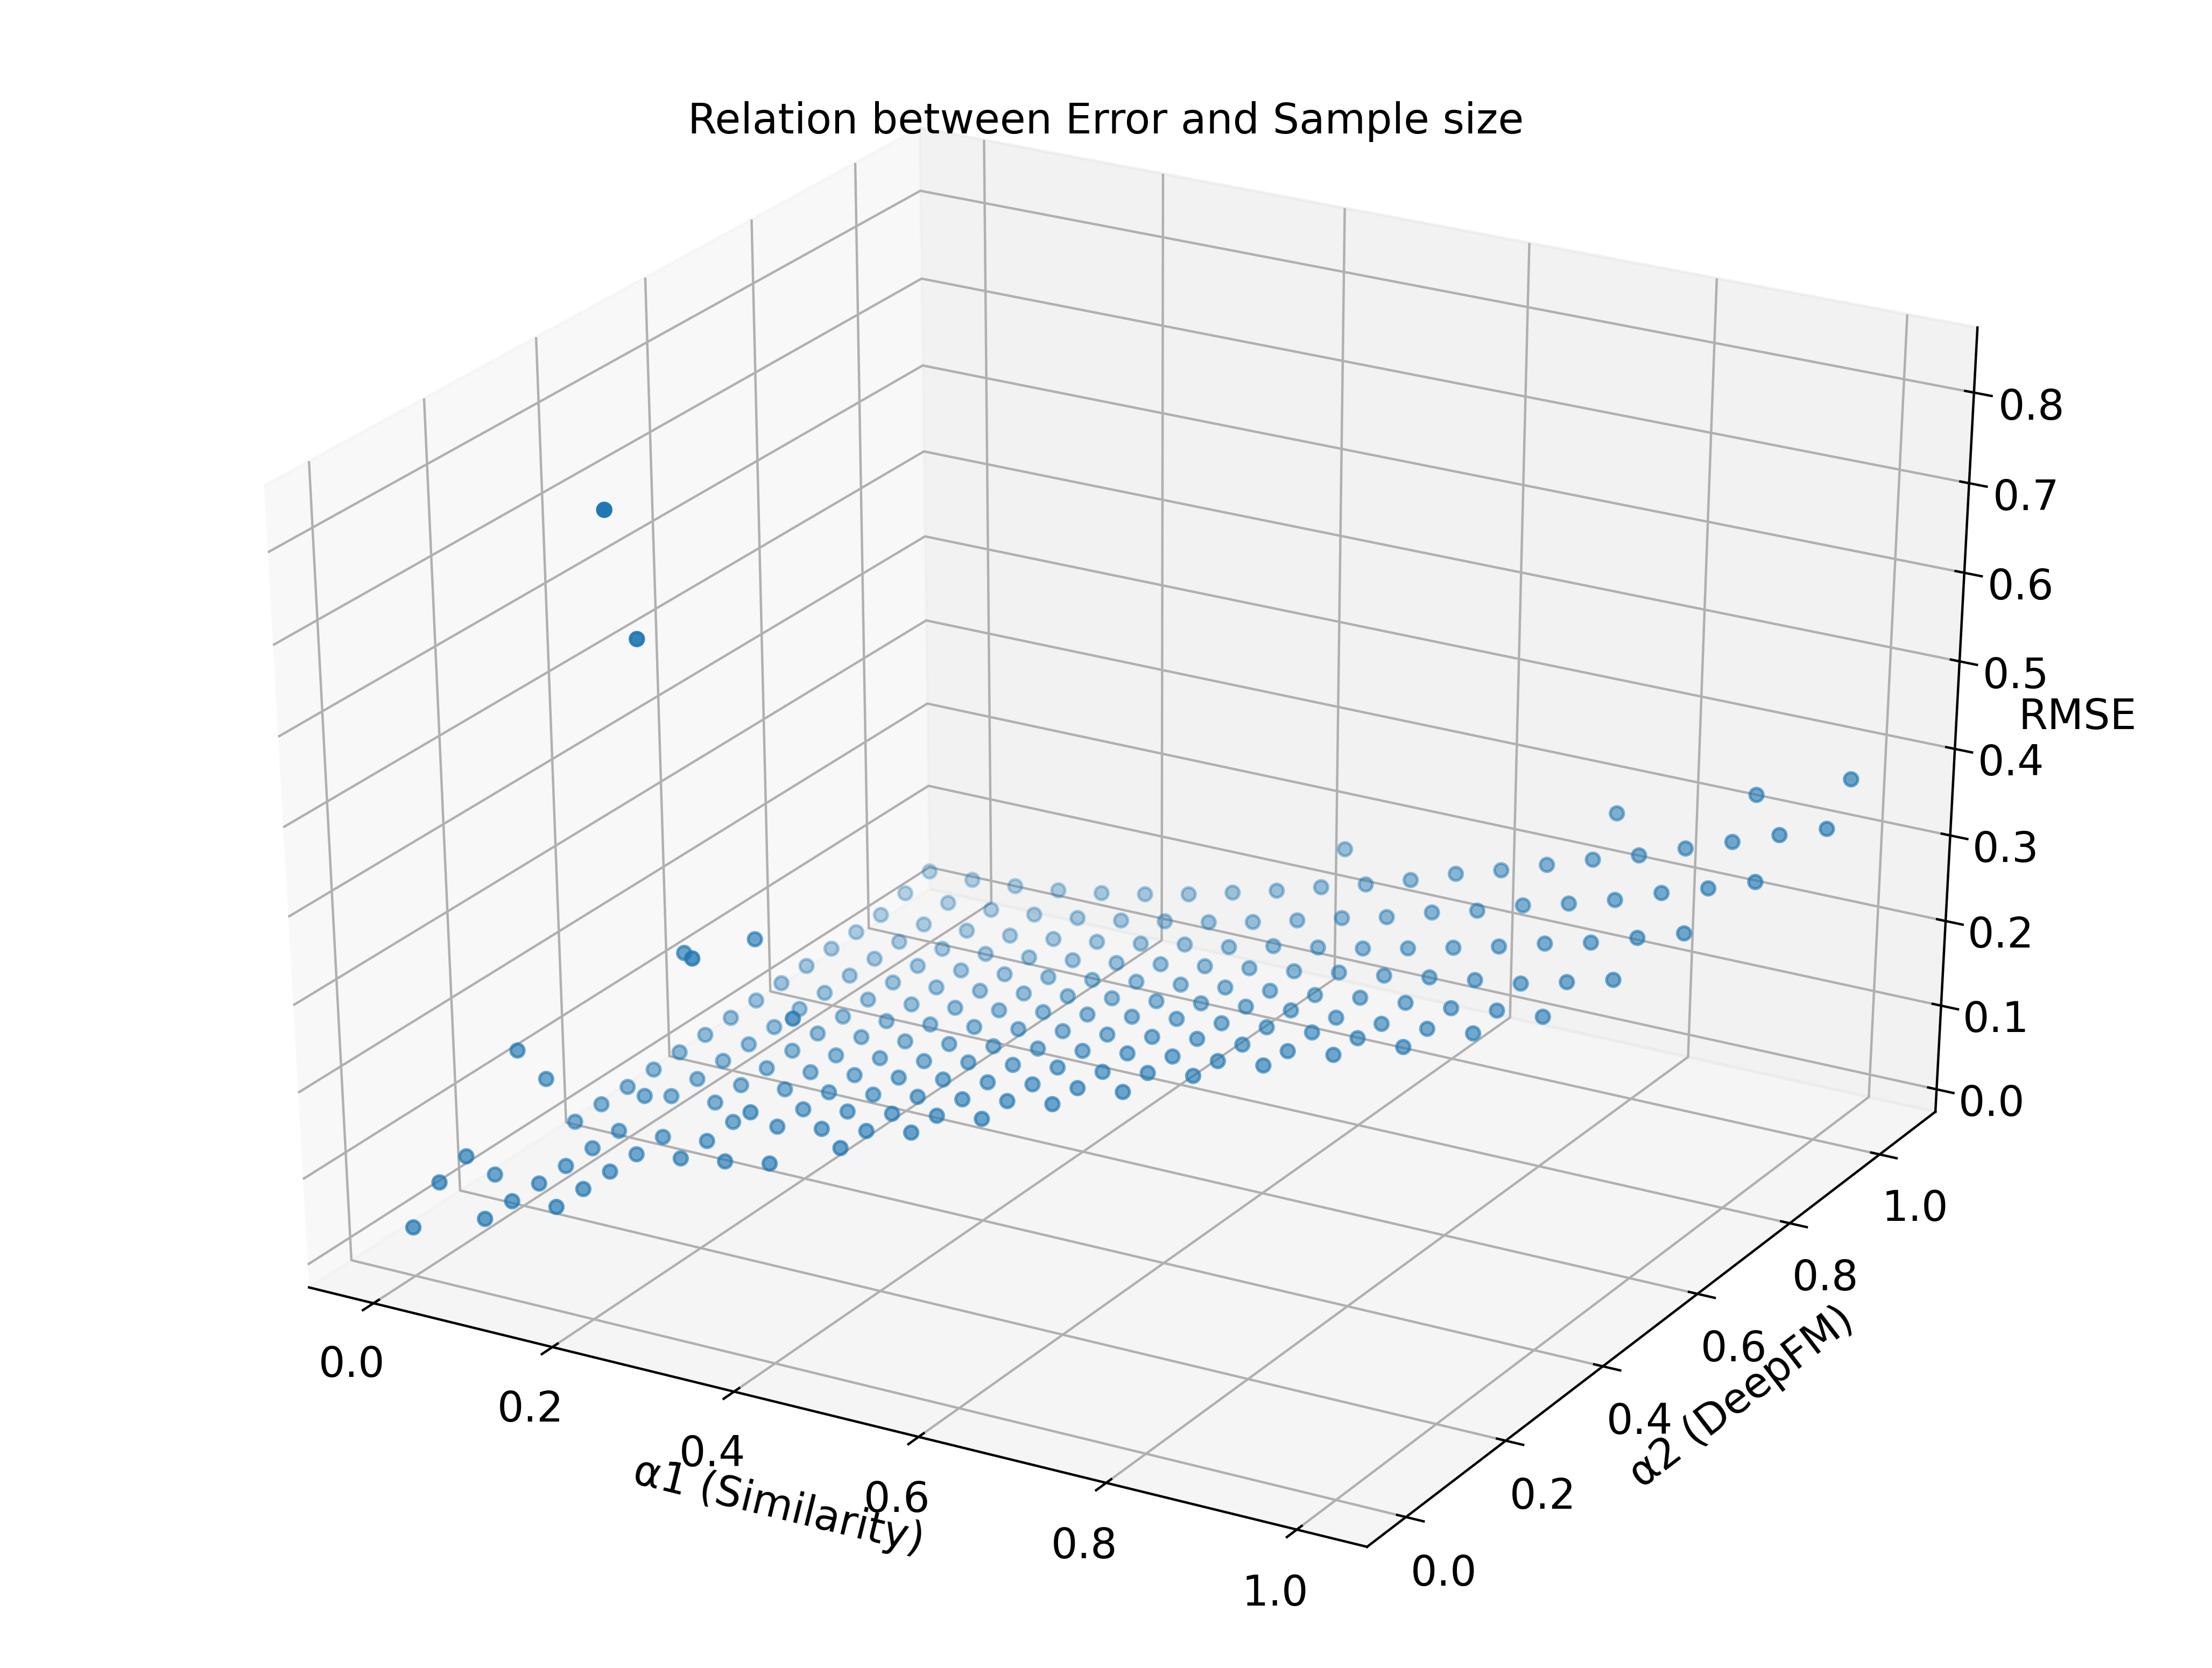

In [143]:
fig = plt.figure(figsize=(13, 10), dpi=400)
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Error depending on α1 and α2")
ax.set_xlabel("α1 (Similarity)")
ax.set_ylabel("α2 (DeepFM)")
ax.set_zlabel("RMSE")
ax.scatter(a1_vec, a2_vec, rmse_vec)

---

In [18]:
algo.predict(0,0)

Prediction(uid=0, iid=0, r_ui=None, est=1.1485986799697216, details={'was_impossible': False})

In [37]:
algo.predict(3, 1500)

Prediction(uid=32323423, iid=234982304982, r_ui=None, est=1.2151029748283753, details={'was_impossible': False})

In [70]:
import itertools
_all_pairs = list(itertools.product(range(0, 138), range(0, 769)))

In [71]:
result = [algo.predict(u, i) for u, i in _all_pairs]

In [72]:
_res = pd.DataFrame(_all_pairs)

In [73]:
_res["rating_pred"] = [r.est for r in result]

In [74]:
_res["user_id"] = _res[0]
_res["item_id"] = _res[1]

In [75]:
_res

,0,1,rating_pred,user_id,item_id
0,0,0,1.148599,0,0
1,0,1,1.148599,0,1
2,0,2,1.148599,0,2
3,0,3,1.148599,0,3
4,0,4,1.148599,0,4
...,...,...,...,...,...
106117,137,764,1.215103,137,764
106118,137,765,1.155508,137,765
106119,137,766,1.215103,137,766
106120,137,767,1.196847,137,767


In [76]:
_res_matrix = _res.drop([0, 1], axis=1).pivot(index="user_id", columns="item_id", values="rating_pred")

In [77]:
_res_matrix

item_id,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
user_id,,,,,,,,,,,,,,,,,,,,,
0,1.148599,1.148599,1.148599,1.148599,1.148599,1.148599,1.148599,1.148599,1.148599,1.148599,...,1.148599,1.148599,1.148599,1.148599,0.900737,1.148599,1.064258,1.148599,1.007040,1.148599
1,1.251929,1.251929,1.251929,1.251929,1.251929,1.251929,1.251929,1.251929,1.251929,1.251929,...,1.251929,1.251929,1.251929,1.251929,1.181017,1.251929,1.064416,1.251929,1.068347,1.251929
2,1.443255,1.443255,1.443255,1.443255,1.443255,1.443255,1.443255,1.443255,1.443255,1.443255,...,1.443255,1.443255,1.443255,1.443255,1.174913,1.443255,1.515076,1.443255,1.594263,1.443255
3,1.215103,1.215103,1.215103,1.215103,1.215103,1.215103,1.215103,1.215103,1.215103,1.215103,...,1.215103,1.215103,1.215103,1.215103,0.998159,1.215103,1.155508,1.215103,1.196847,1.215103
4,1.304402,1.304402,1.304402,1.304402,1.304402,1.304402,1.304402,1.304402,1.304402,1.304402,...,1.304402,1.304402,1.304402,1.304402,1.235779,1.304402,1.290938,1.304402,1.301249,1.304402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.333551,1.333551,1.333551,1.333551,1.333551,1.333551,1.333551,1.333551,1.333551,1.333551,...,1.333551,1.333551,1.333551,1.333551,1.066216,1.333551,1.258961,1.333551,1.357214,1.333551
134,0.720617,0.720617,0.720617,0.720617,0.720617,0.720617,0.720617,0.720617,0.720617,0.720617,...,0.720617,0.720617,0.720617,0.720617,0.372914,0.720617,0.721966,0.720617,0.748751,0.720617
135,1.437870,1.437870,1.437870,1.437870,1.437870,1.437870,1.437870,1.437870,1.437870,1.437870,...,1.437870,1.437870,1.437870,1.437870,1.127364,1.437870,1.215332,1.437870,1.677085,1.437870


In [120]:
import numpy as np
from numpy import random as npr


class ResponseFunction:
    def __init__(self, heu_matrix, nn_matrix):
        assert heu_matrix.shape == nn_matrix.shape
        self._heu_matrix = heu_matrix
        self._nn_matrix = nn_matrix
        
    def __call__(self, a1: float, a2: float):
        a3 = max(0.0, 1 - a1 - a2)
        return (
            a1 * self._heu_matrix
            + a2 * self._nn_matrix
            + a3 * npr.normal(0, 1)
        )
    


In [64]:
resp_fn = ResponseFunction(_heu_matrix, _nn_matrix)

In [78]:
_o = resp_fn(0.7, 0.1)

In [79]:
_o.shape

(138, 769)

In [80]:
from sklearn import metrics

In [81]:
metrics.mean_squared_error(_o, _res_matrix)

0.965318399444561